# Binary black hole mergers in AGN disks -- Playing With Gas

### Chiara Mingarelli, cmingarelli@flatironinstitute.org

In [1]:
# RUN IN PYTHON 3.XX
from IPython.display import display, Math, Latex
import math
from math import sqrt, cos, sin, pi, log10
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, LinearLocator, NullFormatter, NullLocator, MultipleLocator
import matplotlib.ticker
import matplotlib.colors
from matplotlib.font_manager import FontProperties
from matplotlib import rc, text

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [4]:
mchirp(1,1)

4.288976130559507e-06

In [2]:
# physical constants for natural units c = G = 1
c=2.99792458*(10**8)
G=6.67428*(10**(-11))
s_mass=G*(1.98892*10**(30))/(c**3)
solar_mass_gr = 1.989e33
secs_in_pc = 102927133.01 #about 1e8 s per pc

In [3]:
# Mass functions

def mu(m1,m2): return s_mass*(m1*m2)/(m1+m2) # reduced mass

def M(m1,m2):  return s_mass*(m1+m2) # total mass

def mchirp(m1,m2): return ((mu(m1,m2))**(3./5))*((M(m1,m2))**(2./5))  # chirp mass

def mchirp_q(q,Mtot): 
    """
    chirp mass in terms of q and M_tot. Answer in seconds.
    """
    ans = (q/(1+q)**2)**(3/5)*Mtot*s_mass
    return ans

def parsec2sec(d): return d*3.08568025e16/299792458

def sec2pc(sec): return 299792458*sec/3.08568025e16


# For GWs: strain, GW frequency and time to coalescence 


def generic_strain(q_mass_ratio, Mtot, dist, freq):
    strain = sqrt(32./5)*mchirp_q(q_mass_ratio,Mtot)**(5/3)*(pi*freq)**(2/3)/parsec2sec(dist*1e6)
    return strain

def generic_strain_wMc(chirp_mass, dist, freq):
    strain = sqrt(32./5)*(chirp_mass*s_mass)**(5/3)*(pi*freq)**(2/3)/parsec2sec(dist*1e6)
    return strain

def freq_gw(q, Mtot, tc):
    """
    GW frquency as a function of time to coalescence in years, total mass and mass ratio
    Result from integration of standard df/dt for GWs
    """
    ans = mchirp_q(q,Mtot)**(-5/8)/pi*(256/5*tc*31556926)**(-3/8)
    return ans

def freq_gw_wMc(chirp_mass, tc):
    """
    GW frquency as a function of time to coalescence in years and chirp mass (directly)
    Result from integration of standard df/dt for GWs
    """
    ans = (chirp_mass*s_mass)**(-5/8)/pi*(256/5*tc*31556926)**(-3/8)
    return ans

def time_to_c(q, Mtot, freq):
    """
    time to coalescence of a binary in seconds
    """
    ans = (pi*freq)**(-8/3)*mchirp_q(q,Mtot)**(-5/3)*5/256
    return ans

def time_to_c_wMc(chirp_mass, freq):
    """
    freq. in Hz, input chirp mass in solar masses, answer in years
    """
    ans = (pi*freq)**(-8/3)*(chirp_mass*s_mass)**(-5/3)*5/256
    return (ans/31556926)

def a_to_f(Mtot, fgw):
    # Kepler's 3rd law
    # answer in seconds
    frac = (Mtot*s_mass/(pi*fgw)**2)**(1./3)
    return frac

def fgw_to_a(Mtot, a_bh):
    """
    Kepler's 3rd law
    input BH mass in solar masses
    a in pc
    answer in seconds
    """
    ans = (Mtot*s_mass/parsec2sec(a_bh)**3)**(0.5)/pi
    return ans

In [6]:
# lisa starts at 0.5 AU
# ends at around 1e-2 AU

In [7]:
## Hardening and Dynamical Friction Timescales

In [32]:
# Black hole merger timescales from galaxy merger timescale; Binney and Tremaine 1987 
# "Galactic Dynamics"; also Sesana and Khan 2015

def t_hard(Mstar,q,gamma,Mtot):
    """
    Hardening timescale with stars, Eq. 7 Sesana & Khan 2015
    Answer in yrs
    """
    a_val = parsec2sec(r0_sol(Mstar, gamma))
    H = 15
    aStarGW = a_StarGW(Mstar,q,Mtot,gamma,H) #check units
    sigma_inf = sigmaVel(Mstar)*1000/c
    rinf_val = r_inf(Mstar,gamma,Mtot)
    rho_inf = rho_r(Mstar, gamma, rinf_val)
    ans = sigma_inf/(H*rho_inf*aStarGW)
    return ans/31536000

def t_gw(a, q, Mtot):
    # ans in yr
    # a in pc
    const = 5/256
    num = parsec2sec(a)**4
    deno = (Mtot*s_mass)**3 * q/(1+q)**2
    ans = const*num/deno
    return ans/31556926

def soundSpeed(Temp):
    """
    This is the sound speed, c_s, where c_s^2 = k_B*T/m_p
    Returns dimensionless quantity. To get physical units, multiply by c.
    """
    kbTemp_GR = 3.80526e-76*Temp # seconds, for 1K
    mProton = 4.14324e-63 #seconds
    ans = kbTemp_GR/mProton
    return sqrt(ans)
    
def Mdot_to_Sigma(a_bin, alpha, Temp, SigmaSurf, bin_Mass):
    """
    Parameters from Baruteau et al. 2011.
    SigmaSurf input in g/cm^2 (change to kg/m**2)
    input binary mass in solar masses (converts to seconds)
    input semimajor axis in pc (converts to seconds)
    answer is kg/s
    for solar masses, divide by 1.98892*1e30.
    """
    SigmaSurf = SigmaSurf*(1e-3)/(1e-2)**2
    num = 3*pi*alpha*(soundSpeed(Temp)*c)**2*SigmaSurf
    Omega = (bin_Mass*s_mass/(parsec2sec(a_bin)**3))**0.5 ## parsec to seconds, make sure all in seconds
    deno = Omega
    ans = num/deno #kg/s
    return ans

def a_bin(a_bhs,qmass):
    """
    Set a_bin to be the Hill radius, R_H ~ a(q/3)**1/3 for circular systems
    a_bhs is the semimajor axis of the stellar mass BHs, in pc
    answer in seconds
    """
    return parsec2sec(a_bhs)*(qmass/3)**(1/3)

def t_ACC(a_bhs,M1,M2,SigmaSurf,Temp, alpha):
    """
    temperature in Kelvin
    SigmaSurf input in g/cm^2
    BH masses in solar masses
    a_bhs in pc; start with 1e-3pc
    Answer in YEARS
    """
    SigmaSurf = SigmaSurf*(1/solar_mass_gr*s_mass)/(1e-2/c)**2
    a0 = sqrt(M(M1,M2)*s_mass/SigmaSurf)
    num = mu(M1,M2)*M(M1,M2)**0.25
    q=M2/M1
    deno = a_bin(a_bhs,q)*3*pi*alpha*soundSpeed(Temp)**2*SigmaSurf**0.75
    ans = num/deno
    return ans/31556926 #yrs
    
def t_baruteau(Temp, SigmaSurf, bin_Mass, SMBH_mass, a_SMBH, a_bin):
    """
    temperature in Kelvin
    SigmaSurf input in g/cm^2
    SMBH_mass in solar masses
    bin_mass in solar masses
    a_SMBH in pc
    a_bin in AU
    Answer in YEARS
    """
    const = 1/5.443310539518173e-10
    ans = const*(Temp/2000)**3*(SigmaSurf/100)**(-1)*(SMBH_mass/3e6)**(-0.5)*(bin_Mass/2)**(-2)*(a_SMBH/0.1)**(3/2)*(a_bin/50)
    return 900*ans
  
def t_sh(Mstar,q,gamma, Mtot, a_bin):
    # answer in yr
    sig = sigmaVel(Mstar) # M-sigma
    H = 15
    inf_rad = r_inf(Mstar,gamma,Mtot) # Influence radius
    rho_influence = rho_r(Mstar, gamma, inf_rad) #density profile at influence radius
    num = sig*1000/c
    deno = H*parsec2sec(a_bin)*rho_influence
    ans = num/deno
    return ans/31556926

def dy_fric_a(Mstar,M2, a):
    """
    Final eq from https://webhome.weizmann.ac.il/home/iair/astrocourse/tutorial8.pdf
    returns timescale in yr
    Mbh should be mass of secondary
    a in kpc
    """
    # assume log(Lambda) = 10
    vc = sqrt(2)*sigmaVel(Mstar)
    ans = 2.64e10*(a/2)**2*(vc/250)*(1e6/M2)
    return ans

def fmax(Mtot):
    const = 1/(np.pi*6**(3/2))
    ans = const/(Mtot*s_mass)
    return ans

def find_nearest(array,value):
    #returns index of matching value in array
    idx = (np.abs(array-value)).argmin()
    return idx 

def pc_to_AU(parParam):
    """
    change parsecs to AU
    input parsecs
    output in AU
    """
    return parParam*206265

def AU_to_pc(auParam): 
    """
    change AU measurement to parsecs
    """
    return auParam*4.8481e-6

def a_to_Om(Mtot, semi_a):
    # Kepler's 3rd law
    # answer in seconds
    semi_a = parsec2sec(semi_a) #parsecs to seconds
    frac = Mtot*s_mass/(semi_a)**3
    ans = frac**(1/2)
    return ans

def tempCheckwUnits(temp):
    mp = 938.23e6/c**2 #Mev/c^2
    kB = 8.617e-5 #eV/K
    ans = sqrt(kB*temp/mp)
    return ans

def fdot_gw(Mchirp,fgw):
    const = 96./5*pi**(8./3)
    num = (Mchirp*s_mass)**(5./3)*fgw**(11./3)
    ans = num*const
    return ans

def fdot_gw_mod(m1,m2,fgw):
    const = 96./5*pi**(8./3)
    num = (mchirp(m1,m2))**(5./3)*fgw**(11./3)
    ans = num*const
    return ans

def fdot_drag(m1,m2,temperature, Const, fgw):
    rho_0=1e-6*(1e-3)/(0.01)**3 # cm -> m
    num = 2*rho_0*Const*3*(6.67428*(10**(-11)))**(5/3.)*((m1+m2)*2e30)**(2/3.)*fgw**(2./3)
    deno = (soundSpeed(temperature)*c)**2*2*pi**(1/3.)
    ans = num/deno
    return ans
    

In [54]:
gw_vec = []
drag_vec = []
xax = []
m1=1
m2=1
temperature = 1e5
Const=1

for qq in range (1,10000):
    qq=qq/10000
    xax.append(qq)
    gw_vec.append(fdot_gw_mod(m1,m2,qq))
    drag_vec.append(fdot_drag(m1,m2,temperature, Const, qq))
    

/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


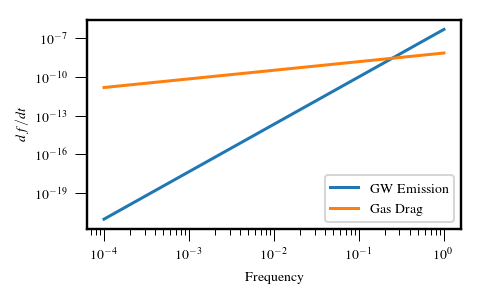

In [55]:
plt.loglog(xax, gw_vec, label = "GW Emission")
plt.loglog(xax, drag_vec, label="Gas Drag")
plt.xlabel("Frequency")
plt.ylabel(r"$df/dt$")
plt.legend(loc=4)
plt.tight_layout()
plt.savefig("test_run_m1isOne.pdf")

In [57]:
np.savetxt("fdot_and_f.txt", np.array(xax, gw_vec, drag_vec))


AttributeError: fmt has wrong shape.  [9.914944130051235e-22, 1.2591194193799403e-20, 5.56845702067341e-20, 1.5989819927018446e-19, 3.6239340637074174e-19, 7.071499625965339e-19, 1.2444661402691737e-18, 2.0305805578344926e-18, 3.1273714893768917e-18, 4.602109395994036e-18, 6.527248046133339e-18, 8.980244756200086e-18, 1.2043403296741712e-17, 1.580373488161673e-17, 2.0352833878656273e-17, 2.5786765708901174e-17, 3.2205964982389096e-17, 3.9715142337057853e-17, 4.8423198756127345e-17, 5.844314637178935e-17, 6.989203494116323e-17, 8.289088331911549e-17, 9.756461536194936e-17, 1.1404199978339138e-16, 1.32455593554929e-16, 1.5294168850020058e-16, 1.7564026078061855e-16, 2.0069492300883936e-16, 2.282528787597059e-16, 2.5846487927610383e-16, 2.9148518219078236e-16, 3.2747151210533767e-16, 3.6658502288484576e-16, 4.0899026154156355e-16, 4.548551335940456e-16, 5.043508697992993e-16, 5.576519941654621e-16, 6.149362931611339e-16, 6.763847860451448e-16, 7.421816962472788e-16, 8.125144237364801e-16, 8.875735183184053e-16, 9.675526538089567e-16, 1.0526486030346975e-15, 1.1430612136149023e-15, 1.2389933844834494e-15, 1.340651043111867e-15, 1.4482431233977013e-15, 1.5619815441849114e-15, 1.6820811883853322e-15, 1.8087598826723794e-15, 1.9422383777200887e-15, 2.082740328962374e-15, 2.2304922778489823e-15, 2.3857236335761425e-15, 2.548666655271267e-15, 2.7195564346122845e-15, 2.8986308788634157e-15, 3.086130694310226e-15, 3.2822993700777665e-15, 3.4873831623166053e-15, 3.701631078742321e-15, 3.925294863514886e-15, 4.158628982445039e-15, 4.401890608515508e-15, 4.6553396077055244e-15, 4.919238525107655e-15, 5.193852571326616e-15, 5.479449609150148e-15, 5.776300140482589e-15, 6.084677293532224e-15, 6.404856810243872e-15, 6.7371170339686904e-15, 7.081738897363349e-15, 7.439005910511337e-15, 7.809204149259274e-15, 8.192622243761535e-15, 8.589551367226786e-15, 9.000285224860245e-15, 9.425120042995783e-15, 9.864354558412321e-15, 1.031829000782899e-14, 1.0787230117573962e-14, 1.1271481093422019e-14, 1.177135161059602e-14, 1.2287152803927688e-14, 1.2819198258173478e-14, 1.3367803998481074e-14, 1.393328848100261e-14, 1.4515972583650738e-14, 1.5116179596993616e-14, 1.5734235215285336e-14, 1.6370467527628346e-14, 1.7025207009264335e-14, 1.7698786512990438e-14, 1.839154126069777e-14, 1.9103808835029022e-14, 1.9835929171152327e-14, 2.0588244548648753e-14, 2.1361099583510366e-14, 2.2154841220246587e-14, 2.2969818724096094e-14, 2.3806383673341846e-14, 2.466488995172702e-14, 2.5545693740969347e-14, 2.644915351337173e-14, 2.7375630024527125e-14, 2.832548630611535e-14, 2.929908765878996e-14, 3.029680164515331e-14, 3.131899808281773e-14, 3.236604903755105e-14, 3.343832881650484e-14, 3.453621396152341e-14, 3.566008324253192e-14, 3.681031765100234e-14, 3.798730039349509e-14, 3.919141688527522e-14, 4.0423054744001717e-14, 4.168260378348804e-14, 4.297045600753305e-14, 4.4287005603820525e-14, 4.5632648937885976e-14, 4.700778454714993e-14, 4.8412813135015775e-14, 4.984813756503121e-14, 5.131416285511248e-14, 5.2811296171829586e-14, 5.4339946824751655e-14, 5.5900526260851645e-14, 5.749344805896874e-14, 5.911912792432779e-14, 6.077798368311477e-14, 6.247043527710708e-14, 6.419690475835775e-14, 6.595781628393284e-14, 6.775359611070092e-14, 6.958467259017346e-14, 7.14514761633961e-14, 7.335443935588897e-14, 7.529399677263568e-14, 7.727058509312053e-14, 7.928464306641225e-14, 8.133661150629447e-14, 8.342693328644137e-14, 8.555605333563819e-14, 8.7724418633046e-14, 8.993247820350956e-14, 9.218068311290785e-14, 9.446948646354676e-14, 9.679934338959308e-14, 9.917071105254876e-14, 1.01584048636766e-13, 1.0403981734500106e-13, 1.0653848039400707e-13, 1.0908050301016549e-13, 1.1166635242515466e-13, 1.1429649787165598e-13, 1.1697141057909576e-13, 1.1969156376942453e-13, 1.224574326529304e-13, 1.2526949442408815e-13, 1.2812822825744252e-13, 1.310341153035256e-13, 1.339876386848073e-13, 1.3698928349167957e-13, 1.4003953677847246e-13, 1.4313888755950227e-13, 1.462878268051518e-13, 1.4948684743798143e-13, 1.5273644432887058e-13, 1.5603711429319058e-13, 1.5938935608700631e-13, 1.6279367040330787e-13, 1.662505598682715e-13, 1.6976052903754844e-13, 1.7332408439258334e-13, 1.7694173433695953e-13, 1.8061398919277237e-13, 1.8434136119702976e-13, 1.8812436449807964e-13, 1.9196351515206318e-13, 1.9585933111939576e-13, 1.9981233226127226e-13, 2.038230403361985e-13, 2.0789197899654786e-13, 2.120196737851429e-13, 2.1620665213186053e-13, 2.2045344335026326e-13, 2.2476057863425278e-13, 2.2912859105474784e-13, 2.335580155563855e-13, 2.3804938895424524e-13, 2.4260324993059564e-13, 2.472201390316647e-13, 2.5190059866443113e-13, 2.5664517309343806e-13, 2.614544084376286e-13, 2.663288526672024e-13, 2.712690556004945e-13, 2.7627556890087375e-13, 2.8134894607366283e-13, 2.864897424630784e-13, 2.916985152491918e-13, 2.96975823444909e-13, 3.023222278929713e-13, 3.077382912629751e-13, 3.132245780484107e-13, 3.187816545637208e-13, 3.244100889413775e-13, 3.301104511289775e-13, 3.3588331288635744e-13, 3.417292477827256e-13, 3.4764883119381263e-13, 3.536426402990401e-13, 3.597112540787067e-13, 3.6585525331119087e-13, 3.7207522057017336e-13, 3.783717402218737e-13, 3.847453984223059e-13, 3.9119678311454987e-13, 3.9772648402603914e-13, 4.043350926658662e-13, 4.1102320232210296e-13, 4.1779140805913744e-13, 4.2464030671502673e-13, 4.3157049689886533e-13, 4.3858257898816853e-13, 4.456771551262728e-13, 4.5285482921974976e-13, 4.601162069358361e-13, 4.674618956998775e-13, 4.748925046927894e-13, 4.824086448485288e-13, 4.900109288515849e-13, 4.976999711344811e-13, 5.054763878752911e-13, 5.133407969951715e-13, 5.21293818155905e-13, 5.293360727574603e-13, 5.37468183935565e-13, 5.456907765592896e-13, 5.540044772286478e-13, 5.624099142722099e-13, 5.709077177447256e-13, 5.794985194247659e-13, 5.881829528123723e-13, 5.969616531267222e-13, 6.058352573038046e-13, 6.148044039941111e-13, 6.23869733560335e-13, 6.330318880750884e-13, 6.42291511318626e-13, 6.516492487765844e-13, 6.61105747637732e-13, 6.706616567917312e-13, 6.803176268269113e-13, 6.900743100280543e-13, 6.999323603741923e-13, 7.098924335364149e-13, 7.199551868756887e-13, 7.301212794406881e-13, 7.403913719656376e-13, 7.507661268681638e-13, 7.6124620824716e-13, 7.718322818806594e-13, 7.825250152237223e-13, 7.933250774063288e-13, 8.042331392312883e-13, 8.152498731721552e-13, 8.263759533711546e-13, 8.376120556371218e-13, 8.48958857443449e-13, 8.604170379260411e-13, 8.719872778812867e-13, 8.836702597640328e-13, 8.954666676855731e-13, 9.073771874116457e-13, 9.194025063604384e-13, 9.31543313600605e-13, 9.438002998492928e-13, 9.561741574701766e-13, 9.686655804715021e-13, 9.812752645041424e-13, 9.94003906859657e-13, 1.0068522064683682e-12, 1.019820863897439e-12, 1.0329105813489644e-12, 1.046122062658071e-12, 1.0594560132910225e-12, 1.0729131403433375e-12, 1.0864941525379154e-12, 1.1001997602231692e-12, 1.1140306753711672e-12, 1.1279876115757858e-12, 1.142071284050866e-12, 1.1562824096283819e-12, 1.1706217067566171e-12, 1.1850898954983487e-12, 1.1996876975290376e-12, 1.2144158361350308e-12, 1.229275036211768e-12, 1.2442660242619974e-12, 1.2593895283940021e-12, 1.2746462783198285e-12, 1.2900370053535288e-12, 1.3055624424094067e-12, 1.3212233240002719e-12, 1.337020386235704e-12, 1.3529543668203216e-12, 1.3690260050520601e-12, 1.3852360418204562e-12, 1.4015852196049414e-12, 1.4180742824731377e-12, 1.4347039760791722e-12, 1.4514750476619818e-12, 1.4683882460436397e-12, 1.485444321627686e-12, 1.5026440263974548e-12, 1.5199881139144265e-12, 1.5374773393165669e-12, 1.5551124593166934e-12, 1.5728942322008292e-12, 1.5908234178265763e-12, 1.608900777621497e-12, 1.6271270745814863e-12, 1.6455030732691744e-12, 1.664029539812311e-12, 1.6827072419021745e-12, 1.7015369487919844e-12, 1.7205194312953092e-12, 1.7396554617844965e-12, 1.7589458141890946e-12, 1.778391263994292e-12, 1.79799258823936e-12, 1.8177505655160933e-12, 1.8376659759672737e-12, 1.8577396012851175e-12, 1.8779722247097553e-12, 1.8983646310276916e-12, 1.918917606570288e-12, 1.939631939212252e-12, 1.960508418370115e-12, 1.9815478350007434e-12, 2.002750981599824e-12, 2.0241186522003817e-12, 2.0456516423712945e-12, 2.0673507492158018e-12, 2.089216771370042e-12, 2.1112505090015703e-12, 2.1334527638079034e-12, 2.1558243390150597e-12, 2.178366039376101e-12, 2.201078671169694e-12, 2.2239630421986576e-12, 2.247019961788538e-12, 2.270250240786166e-12, 2.293654691558239e-12, 2.3172341279899006e-12, 2.3409893654833187e-12, 2.3649212209562863e-12, 2.3890305128408047e-12, 2.4133180610816907e-12, 2.437784687135187e-12, 2.4624312139675613e-12, 2.4872584660537335e-12, 2.512267269375888e-12, 2.5374584514221035e-12, 2.562832841184988e-12, 2.588391269160306e-12, 2.6141345673456278e-12, 2.640063569238967e-12, 2.666179109837443e-12, 2.6924820256359224e-12, 2.7189731546256868e-12, 2.745653336293103e-12, 2.7725234116182803e-12, 2.7995842230737578e-12, 2.8268366146231737e-12, 2.8542814317199525e-12, 2.8819195213060004e-12, 2.909751731810385e-12, 2.9377789131480478e-12, 2.966001916718491e-12, 2.9944215954045014e-12, 3.023038803570847e-12, 3.0518543970629974e-12, 3.080869233205851e-12, 3.110084170802449e-12, 3.1395000701327127e-12, 3.16911779295217e-12, 3.198938202490698e-12, 3.228962163451266e-12, 3.2591905420086734e-12, 3.2896242058083147e-12, 3.3202640239649193e-12, 3.3511108670613166e-12, 3.382165607147206e-12, 3.413429117737909e-12, 3.444902273813159e-12, 3.4765859518158593e-12, 3.5084810296508777e-12, 3.540588386683818e-12, 3.572908903739812e-12, 3.605443463102321e-12, 3.638192948511913e-12, 3.671158245165081e-12, 3.704340239713032e-12, 3.7377398202605e-12, 3.771357876364567e-12, 3.805195299033456e-12, 3.839252980725379e-12, 3.873531815347333e-12, 3.908032698253942e-12, 3.9427565262462894e-12, 3.97770419757074e-12, 4.012876611917793e-12, 4.048274670420908e-12, 4.083899275655369e-12, 4.119751331637118e-12, 4.15583174382161e-12, 4.192141419102685e-12, 4.228681265811406e-12, 4.265452193714941e-12, 4.302455114015418e-12, 4.3396909393488e-12, 4.377160583783769e-12, 4.414864962820585e-12, 4.452804993389988e-12, 4.4909815938520625e-12, 4.5293956839951485e-12, 4.568048185034714e-12, 4.606940019612256e-12, 4.646072111794212e-12, 4.68544538707084e-12, 4.725060772355144e-12, 4.764919195981771e-12, 4.805021587705925e-12, 4.845368878702291e-12, 4.885962001563938e-12, 4.926801890301264e-12, 4.967889480340896e-12, 5.009225708524632e-12, 5.050811513108382e-12, 5.0926478337610775e-12, 5.134735611563642e-12, 5.177075789007902e-12, 5.219669309995554e-12, 5.262517119837099e-12, 5.3056201652508e-12, 5.348979394361638e-12, 5.392595756700258e-12, 5.436470203201947e-12, 5.4806036862055795e-12, 5.52499715945259e-12, 5.569651578085957e-12, 5.614567898649146e-12, 5.659747079085119e-12, 5.705190078735282e-12, 5.750897858338481e-12, 5.796871380029998e-12, 5.8431116073405105e-12, 5.889619505195111e-12, 5.9363960399122745e-12, 5.9834421792028755e-12, 6.030758892169175e-12, 6.07834714930382e-12, 6.126207922488864e-12, 6.1743421849947544e-12, 6.222750911479364e-12, 6.271435077986982e-12, 6.320395661947341e-12, 6.369633642174649e-12, 6.419149998866581e-12, 6.468945713603334e-12, 6.519021769346632e-12, 6.569379150438763e-12, 6.620018842601621e-12, 6.6709418329357225e-12, 6.722149109919264e-12, 6.7736416634071445e-12, 6.8254204846300295e-12, 6.877486566193373e-12, 6.9298409020764794e-12, 6.9824844876315634e-12, 7.035418319582784e-12, 7.0886433960253175e-12, 7.142160716424405e-12, 7.1959712816144165e-12, 7.250076093797929e-12, 7.304476156544767e-12, 7.359172474791099e-12, 7.414166054838483e-12, 7.469457904352973e-12, 7.525049032364159e-12, 7.580940449264273e-12, 7.637133166807265e-12, 7.693628198107873e-12, 7.750426557640741e-12, 7.807529261239469e-12, 7.864937326095732e-12, 7.922651770758368e-12, 7.980673615132467e-12, 8.039003880478486e-12, 8.097643589411324e-12, 8.156593765899451e-12, 8.215855435264005e-12, 8.275429624177896e-12, 8.335317360664919e-12, 8.395519674098868e-12, 8.456037595202664e-12, 8.516872156047439e-12, 8.578024390051686e-12, 8.639495331980382e-12, 8.701286017944088e-12, 8.763397485398103e-12, 8.82583077314157e-12, 8.88858692131662e-12, 8.951666971407518e-12, 9.01507196623976e-12, 9.078802949979256e-12, 9.14286096813144e-12, 9.207247067540415e-12, 9.271962296388126e-12, 9.337007704193463e-12, 9.402384341811451e-12, 9.468093261432362e-12, 9.53413551658091e-12, 9.600512162115371e-12, 9.667224254226757e-12, 9.73427285043798e-12, 9.801659009602997e-12, 9.869383791905998e-12, 9.937448258860544e-12, 1.0005853473308751e-11, 1.0074600499420476e-11, 1.0143690402692443e-11, 1.0213124249947476e-11, 1.0282903109333624e-11, 1.0353028050323361e-11, 1.0423500143712783e-11, 1.0494320461620755e-11, 1.0565490077488132e-11, 1.0637010066076904e-11, 1.0708881503469438e-11, 1.078110546706761e-11, 1.085368303559204e-11, 1.0926615289081278e-11, 1.0999903308890977e-11, 1.1073548177693128e-11, 1.114755097947523e-11, 1.12219127995395e-11, 1.1296634724502096e-11, 1.1371717842292294e-11, 1.144716324215172e-11, 1.1522972014633537e-11, 1.1599145251601685e-11, 1.167568404623007e-11, 1.1752589493001784e-11, 1.1829862687708341e-11, 1.1907504727448869e-11, 1.1985516710629359e-11, 1.206389973696186e-11, 1.214265490746372e-11, 1.2221783324456825e-11, 1.2301286091566793e-11, 1.2381164313722238e-11, 1.2461419097153988e-11, 1.2542051549394306e-11, 1.2623062779276156e-11, 1.2704453896932413e-11, 1.2786226013795123e-11, 1.2868380242594718e-11, 1.29509176973593e-11, 1.303383949341384e-11, 1.3117146747379446e-11, 1.320084057717263e-11, 1.3284922102004513e-11, 1.3369392442380128e-11, 1.3454252720097628e-11, 1.353950405824756e-11, 1.3625147581212144e-11, 1.3711184414664483e-11, 1.3797615685567873e-11, 1.3884442522175028e-11, 1.3971666054027354e-11, 1.405928741195424e-11, 1.4147307728072278e-11, 1.4235728135784578e-11, 1.4324549769779992e-11, 1.4413773766032441e-11, 1.4503401261800136e-11, 1.4593433395624876e-11, 1.4683871307331344e-11, 1.4774716138026336e-11, 1.4865969030098103e-11, 1.4957631127215585e-11, 1.5049703574327696e-11, 1.5142187517662657e-11, 1.523508410472721e-11, 1.5328394484305984e-11, 1.5422119806460706e-11, 1.5516261222529568e-11, 1.561081988512646e-11, 1.570579694814028e-11, 1.5801193566734273e-11, 1.5897010897345256e-11, 1.5993250097682986e-11, 1.6089912326729402e-11, 1.6186998744737967e-11, 1.6284510513232964e-11, 1.6382448795008777e-11, 1.648081475412924e-11, 1.6579609555926912e-11, 1.667883436700238e-11, 1.677849035522362e-11, 1.6878578689725245e-11, 1.6979100540907878e-11, 1.708005708043741e-11, 1.718144948124438e-11, 1.728327891752324e-11, 1.7385546564731693e-11, 1.7488253599590037e-11, 1.7591401200080455e-11, 1.7694990545446357e-11, 1.7799022816191706e-11, 1.7903499194080335e-11, 1.8008420862135265e-11, 1.811378900463811e-11, 1.8219604807128288e-11, 1.832586945640245e-11, 1.8432584140513778e-11, 1.8539750048771302e-11, 1.8647368371739304e-11, 1.875544030123658e-11, 1.8863967030335817e-11, 1.8972949753362934e-11, 1.9082389665896406e-11, 1.9192287964766665e-11, 1.930264584805536e-11, 1.9413464515094764e-11, 1.952474516646709e-11, 1.9636489004003905e-11, 1.9748697230785382e-11, 1.9861371051139714e-11, 1.997451167064247e-11, 2.0088120296115914e-11, 2.0202198135628428e-11, 2.0316746398493778e-11, 2.0431766295270543e-11, 2.0547259037761448e-11, 2.0663225839012724e-11, 2.07796679133135e-11, 2.089658647619514e-11, 2.101398274443058e-11, 2.1131857936033767e-11, 2.1250213270258952e-11, 2.1369049967600153e-11, 2.1488369249790412e-11, 2.1608172339801254e-11, 2.1728460461842012e-11, 2.1849234841359217e-11, 2.1970496705036016e-11, 2.2092247280791464e-11, 2.221448779777997e-11, 2.2337219486390638e-11, 2.2460443578246665e-11, 2.258416130620476e-11, 2.2708373904354437e-11, 2.2833082608017483e-11, 2.29582886537473e-11, 2.3083993279328286e-11, 2.32101977237753e-11, 2.3336903227332942e-11, 2.3464111031475e-11, 2.3591822378903833e-11, 2.3720038513549803e-11, 2.3848760680570602e-11, 2.3977990126350676e-11, 2.4107728098500643e-11, 2.423797584585663e-11, 2.4368734618479795e-11, 2.4500005667655573e-11, 2.4631790245893175e-11, 2.4764089606924968e-11, 2.4896905005705856e-11, 2.503023769841275e-11, 2.5164088942443902e-11, 2.529845999641832e-11, 2.5433352120175232e-11, 2.556876657477342e-11, 2.5704704622490722e-11, 2.5841167526823348e-11, 2.597815655248534e-11, 2.6115672965408007e-11, 2.625371803273927e-11, 2.6392293022843198e-11, 2.6531399205299272e-11, 2.667103785090193e-11, 2.6811210231659918e-11, 2.6951917620795708e-11, 2.709316129274502e-11, 2.7234942523156103e-11, 2.7377262588889226e-11, 2.752012276801611e-11, 2.7663524339819383e-11, 2.780746858479191e-11, 2.795195678463631e-11, 2.8096990222264354e-11, 2.824257018179637e-11, 2.8388697948560765e-11, 2.8535374809093343e-11, 2.8682602051136794e-11, 2.8830380963640144e-11, 2.8978712836758126e-11, 2.912759896185075e-11, 2.927704063148258e-11, 2.942703913942225e-11, 2.9577595780641936e-11, 2.9728711851316705e-11, 2.988038864882409e-11, 3.003262747174342e-11, 3.018542961985527e-11, 3.033879639414096e-11, 3.0492729096781975e-11, 3.064722903115945e-11, 3.0802297501853535e-11, 3.095793581464291e-11, 3.111414527650423e-11, 3.1270927195611495e-11, 3.142828288133569e-11, 3.158621364424406e-11, 3.174472079609956e-11, 3.1903805649860483e-11, 3.2063469519679706e-11, 3.222371372090436e-11, 3.238453957007508e-11, 3.25459483849256e-11, 3.270794148438214e-11, 3.2870520188562976e-11, 3.303368581877776e-11, 3.3197439697527064e-11, 3.336178314850184e-11, 3.352671749658285e-11, 3.369224406784021e-11, 3.385836418953275e-11, 3.4025079190107567e-11, 3.419239039919945e-11, 3.436029914763033e-11, 3.452880676740887e-11, 3.469791459172977e-11, 3.486762395497334e-11, 3.503793619270497e-11, 3.520885264167455e-11, 3.538037463981604e-11, 3.555250352624686e-11, 3.5725240641267364e-11, 3.5898587326360394e-11, 3.6072544924190674e-11, 3.6247114778604404e-11, 3.64222982346286e-11, 3.659809663847068e-11, 3.677451133751788e-11, 3.695154368033676e-11, 3.712919501667279e-11, 3.7307466697449634e-11, 3.7486360074768794e-11, 3.766587650190902e-11, 3.784601733332591e-11, 3.8026783924651195e-11, 3.820817763269244e-11, 3.8390199815432394e-11, 3.857285183202853e-11, 3.875613504281261e-11, 3.8940050809290033e-11, 3.9124600494139425e-11, 3.930978546121212e-11, 3.9495607075531616e-11, 3.9682066703293187e-11, 3.986916571186323e-11, 4.0056905469778836e-11, 4.024528734674731e-11, 4.0434312713645606e-11, 4.062398294251995e-11, 4.08142994065852e-11, 4.100526348022441e-11, 4.119687653898836e-11, 4.138913995959499e-11, 4.158205511992904e-11, 4.177562339904137e-11, 4.196984617714862e-11, 4.216472483563264e-11, 4.236026075703999e-11, 4.255645532508159e-11, 4.275330992463199e-11, 4.29508259417291e-11, 4.314900476357354e-11, 4.334784777852831e-11, 4.354735637611818e-11, 4.374753194702921e-11, 4.3948375883108355e-11, 4.414988957736287e-11, 4.435207442395998e-11, 4.4554931818226195e-11, 4.475846315664699e-11, 4.496266983686626e-11, 4.51675532576858e-11, 4.537311481906499e-11, 4.5579355922120095e-11, 4.578627796912394e-11, 4.5993882363505366e-11, 4.620217050984877e-11, 4.641114381389369e-11, 4.662080368253423e-11, 4.683115152381862e-11, 4.704218874694878e-11, 4.725391676227981e-11, 4.746633698131957e-11, 4.767945081672812e-11, 4.7893259682317334e-11, 4.8107764993050376e-11, 4.832296816504124e-11, 4.8538870615554384e-11, 4.875547376300409e-11, 4.89727790269541e-11, 4.919078782811717e-11, 4.940950158835448e-11, 4.9628921730675426e-11, 4.984904967923685e-11, 5.0069886859342746e-11, 5.02914346974438e-11, 5.0513694621136916e-11, 5.0736668059164713e-11, 5.09603564414151e-11, 5.118476119892081e-11, 5.140988376385892e-11, 5.163572556955051e-11, 5.1862288050460006e-11, 5.20895726421949e-11, 5.2317580781505204e-11, 5.2546313906283e-11, 5.2775773455562084e-11, 5.300596086951736e-11, 5.3236877589464494e-11, 5.3468525057859454e-11, 5.370090471829794e-11, 5.3934018015515195e-11, 5.4167866395385284e-11, 5.440245130492077e-11, 5.4637774192272265e-11, 5.4873836506727933e-11, 5.511063969871318e-11, 5.5348185219790025e-11, 5.558647452265674e-11, 5.5825509061147435e-11, 5.606529029023153e-11, 5.630581966601349e-11, 5.6547098645732134e-11, 5.6789128687760366e-11, 5.7031911251604665e-11, 5.727544779790476e-11, 5.751973978843296e-11, 5.776478868609396e-11, 5.8010595954924224e-11, 5.825716306009163e-11, 5.850449146789515e-11, 5.875258264576408e-11, 5.900143806225796e-11, 5.925105918706595e-11, 5.950144749100638e-11, 5.97526044460265e-11, 6.000453152520184e-11, 6.025723020273581e-11, 6.051070195395945e-11, 6.07649482553307e-11, 6.101997058443434e-11, 6.127577041998119e-11, 6.153234924180792e-11, 6.178970853087656e-11, 6.204784976927396e-11, 6.230677444021166e-11, 6.256648402802512e-11, 6.282698001817349e-11, 6.308826389723912e-11, 6.335033715292715e-11, 6.36132012740652e-11, 6.387685775060272e-11, 6.41413080736107e-11, 6.440655373528129e-11, 6.467259622892726e-11, 6.493943704898173e-11, 6.52070776909976e-11, 6.547551965164723e-11, 6.57447644287219e-11, 6.601481352113165e-11, 6.628566842890454e-11, 6.655733065318644e-11, 6.682980169624057e-11, 6.7103083061447e-11, 6.73771762533025e-11, 6.765208277741972e-11, 6.792780414052708e-11, 6.82043418504683e-11, 6.848169741620189e-11, 6.87598723478009e-11, 6.903886815645233e-11, 6.931868635445681e-11, 6.959932845522821e-11, 6.988079597329318e-11, 7.016309042429085e-11, 7.04462133249722e-11, 7.07301661931999e-11, 7.101495054794776e-11, 7.130056790930031e-11, 7.158701979845253e-11, 7.187430773770929e-11, 7.216243325048503e-11, 7.245139786130336e-11, 7.274120309579655e-11, 7.303185048070535e-11, 7.332334154387836e-11, 7.361567781427173e-11, 7.390886082194869e-11, 7.420289209807938e-11, 7.449777317494009e-11, 7.479350558591315e-11, 7.50900908654864e-11, 7.538753054925278e-11, 7.568582617391006e-11, 7.598497927726032e-11, 7.628499139820957e-11, 7.658586407676736e-11, 7.688759885404642e-11, 7.719019727226231e-11, 7.749366087473286e-11, 7.779799120587792e-11, 7.810318981121891e-11, 7.840925823737843e-11, 7.871619803207997e-11, 7.902401074414731e-11, 7.933269792350428e-11, 7.96422611211744e-11, 7.99527018892803e-11, 8.026402178104362e-11, 8.057622235078434e-11, 8.088930515392056e-11, 8.120327174696805e-11, 8.151812368753981e-11, 8.183386253434592e-11, 8.215048984719285e-11, 8.246800718698324e-11, 8.278641611571549e-11, 8.310571819648332e-11, 8.342591499347558e-11, 8.374700807197557e-11, 8.406899899836091e-11, 8.439188934010294e-11, 8.471568066576666e-11, 8.504037454500994e-11, 8.536597254858347e-11, 8.56924762483302e-11, 8.6019887217185e-11, 8.634820702917441e-11, 8.667743725941603e-11, 8.700757948411833e-11, 8.733863528058015e-11, 8.767060622719037e-11, 8.800349390342767e-11, 8.833729988985989e-11, 8.867202576814383e-11, 8.900767312102484e-11, 8.934424353233641e-11, 8.968173858699996e-11, 9.002015987102416e-11, 9.03595089715048e-11, 9.069978747662438e-11, 9.104099697565166e-11, 9.138313905894142e-11, 9.172621531793392e-11, 9.207022734515461e-11, 9.241517673421384e-11, 9.276106507980635e-11, 9.310789397771101e-11, 9.345566502479045e-11, 9.380437981899055e-11, 9.415403995934017e-11, 9.450464704595099e-11, 9.485620268001673e-11, 9.520870846381305e-11, 9.556216600069717e-11, 9.591657689510741e-11, 9.627194275256303e-11, 9.662826517966355e-11, 9.698554578408861e-11, 9.73437861745976e-11, 9.770298796102913e-11, 9.8063152754301e-11, 9.842428216640947e-11, 9.878637781042907e-11, 9.914944130051226e-11, 9.951347425188901e-11, 9.987847828086657e-11, 1.0024445500482887e-10, 1.0061140604223641e-10, 1.0097933301262572e-10, 1.0134823753660905e-10, 1.017181212358742e-10, 1.0208898573318386e-10, 1.0246083265237546e-10, 1.0283366361836067e-10, 1.0320748025712517e-10, 1.0358228419572836e-10, 1.0395807706230277e-10, 1.0433486048605387e-10, 1.0471263609725965e-10, 1.0509140552727032e-10, 1.0547117040850805e-10, 1.058519323744663e-10, 1.0623369305970984e-10, 1.0661645409987407e-10, 1.0700021713166505e-10, 1.0738498379285879e-10, 1.0777075572230103e-10, 1.0815753455990694e-10, 1.0854532194666072e-10, 1.0893411952461535e-10, 1.0932392893689203e-10, 1.0971475182768006e-10, 1.1010658984223632e-10, 1.1049944462688504e-10, 1.1089331782901744e-10, 1.1128821109709136e-10, 1.1168412608063083e-10, 1.1208106443022587e-10, 1.1247902779753205e-10, 1.1287801783527026e-10, 1.1327803619722624e-10, 1.1367908453825023e-10, 1.1408116451425677e-10, 1.1448427778222412e-10, 1.1488842600019435e-10, 1.1529361082727248e-10, 1.1569983392362645e-10, 1.1610709695048669e-10, 1.1651540157014574e-10, 1.1692474944595818e-10, 1.173351422423399e-10, 1.1774658162476796e-10, 1.181590692597802e-10, 1.1857260681497507e-10, 1.189871959590111e-10, 1.1940283836160657e-10, 1.1981953569353927e-10, 1.2023728962664602e-10, 1.2065610183382263e-10, 1.2107597398902329e-10, 1.214969077672602e-10, 1.2191890484460346e-10, 1.223419668981806e-10, 1.2276609560617636e-10, 1.2319129264783213e-10, 1.2361755970344587e-10, 1.2404489845437157e-10, 1.2447331058301902e-10, 1.2490279777285362e-10, 1.253333617083958e-10, 1.257650040752208e-10, 1.2619772655995822e-10, 1.2663153085029198e-10, 1.2706641863495978e-10, 1.275023916037528e-10, 1.2793945144751528e-10, 1.2837759985814438e-10, 1.288168385285897e-10, 1.2925716915285317e-10, 1.296985934259884e-10, 1.3014111304410058e-10, 1.3058472970434611e-10, 1.3102944510493212e-10, 1.314752609451166e-10, 1.3192217892520754e-10, 1.323702007465628e-10, 1.3281932811158983e-10, 1.3326956272374547e-10, 1.3372090628753542e-10, 1.3417336050851385e-10, 1.3462692709328338e-10, 1.3508160774949444e-10, 1.355374041858453e-10, 1.359943181120814e-10, 1.3645235123899522e-10, 1.3691150527842587e-10, 1.3737178194325876e-10, 1.3783318294742563e-10, 1.3829571000590366e-10, 1.3875936483471544e-10, 1.392241491509288e-10, 1.396900646726561e-10, 1.4015711311905444e-10, 1.4062529621032487e-10, 1.4109461566771222e-10, 1.4156507321350488e-10, 1.4203667057103438e-10, 1.4250940946467522e-10, 1.4298329161984435e-10, 1.4345831876300095e-10, 1.4393449262164618e-10, 1.4441181492432263e-10, 1.4489028740061453e-10, 1.4536991178114674e-10, 1.45850689797585e-10, 1.463326231826352e-10, 1.468157136700435e-10, 1.4729996299459568e-10, 1.477853728921169e-10, 1.482719450994715e-10, 1.4875968135456244e-10, 1.4924858339633148e-10, 1.4973865296475831e-10, 1.5022989180086056e-10, 1.5072230164669337e-10, 1.512158842453491e-10, 1.517106413409573e-10, 1.522065746786838e-10, 1.5270368600473095e-10, 1.5320197706633711e-10, 1.5370144961177621e-10, 1.5420210539035782e-10, 1.5470394615242642e-10, 1.5520697364936132e-10, 1.5571118963357626e-10, 1.5621659585851924e-10, 1.5672319407867222e-10, 1.5723098604955052e-10, 1.5773997352770284e-10, 1.582501582707108e-10, 1.5876154203718867e-10, 1.5927412658678324e-10, 1.597879136801731e-10, 1.6030290507906874e-10, 1.60819102546212e-10, 1.61336507845376e-10, 1.6185512274136462e-10, 1.6237494900001224e-10, 1.6289598838818357e-10, 1.634182426737732e-10, 1.639417136257054e-10, 1.6446640301393375e-10, 1.6499231260944096e-10, 1.6551944418423833e-10, 1.6604779951136565e-10, 1.6657738036489102e-10, 1.6710818851991023e-10, 1.676402257525466e-10, 1.6817349383995083e-10, 1.6870799456030038e-10, 1.6924372969279967e-10, 1.6978070101767927e-10, 1.7031891031619585e-10, 1.7085835937063188e-10, 1.7139904996429517e-10, 1.7194098388151907e-10, 1.7248416290766148e-10, 1.73028588829105e-10, 1.735742634332566e-10, 1.7412118850854702e-10, 1.7466936584443117e-10, 1.7521879723138694e-10, 1.7576948446091557e-10, 1.763214293255411e-10, 1.7687463361880998e-10, 1.774290991352912e-10, 1.7798482767057554e-10, 1.785418210212754e-10, 1.7910008098502456e-10, 1.7965960936047818e-10, 1.8022040794731183e-10, 1.8078247854622183e-10, 1.813458229589247e-10, 1.8191044298815669e-10, 1.824763404376741e-10, 1.8304351711225224e-10, 1.8361197481768565e-10, 1.8418171536078756e-10, 1.8475274054938972e-10, 1.8532505219234225e-10, 1.8589865209951295e-10, 1.8647354208178745e-10, 1.8704972395106858e-10, 1.876271995202763e-10, 1.8820597060334745e-10, 1.8878603901523522e-10, 1.8936740657190909e-10, 1.8995007509035438e-10, 1.9053404638857213e-10, 1.9111932228557885e-10, 1.917059046014059e-10, 1.9229379515709948e-10, 1.9288299577472047e-10, 1.9347350827734372e-10, 1.9406533448905838e-10, 1.946584762349669e-10, 1.952529353411853e-10, 1.958487136348426e-10, 1.964458129440809e-10, 1.9704423509805448e-10, 1.9764398192693016e-10, 1.9824505526188658e-10, 1.9884745693511403e-10, 1.994511887798145e-10, 2.0005625263020087e-10, 2.0066265032149703e-10, 2.0127038368993728e-10, 2.0187945457276629e-10, 2.02489864808239e-10, 2.0310161623561984e-10, 2.0371471069518268e-10, 2.0432915002821083e-10, 2.049449360769962e-10, 2.0556207068483974e-10, 2.061805556960505e-10, 2.0680039295594564e-10, 2.074215843108502e-10, 2.0804413160809673e-10, 2.086680366960251e-10, 2.0929330142398225e-10, 2.0991992764232154e-10, 2.1054791720240313e-10, 2.11177271956593e-10, 2.1180799375826348e-10, 2.1244008446179218e-10, 2.1307354592256213e-10, 2.1370837999696143e-10, 2.143445885423831e-10, 2.1498217341722468e-10, 2.156211364808879e-10, 2.1626147959377846e-10, 2.1690320461730588e-10, 2.1754631341388318e-10, 2.181908078469264e-10, 2.1883668978085463e-10, 2.1948396108108956e-10, 2.2013262361405506e-10, 2.2078267924717763e-10, 2.2143412984888509e-10, 2.2208697728860702e-10, 2.2274122343677433e-10, 2.2339687016481883e-10, 2.2405391934517338e-10, 2.247123728512711e-10, 2.253722325575453e-10, 2.2603350033942958e-10, 2.2669617807335666e-10, 2.2736026763675948e-10, 2.2802577090806925e-10, 2.2869268976671672e-10, 2.2936102609313134e-10, 2.3003078176874026e-10, 2.3070195867596961e-10, 2.313745586982425e-10, 2.3204858371998008e-10, 2.3272403562660119e-10, 2.334009163045207e-10, 2.3407922764115134e-10, 2.347589715249015e-10, 2.3544014984517626e-10, 2.36122764492377e-10, 2.3680681735789996e-10, 2.3749231033413783e-10, 2.381792453144776e-10, 2.3886762419330197e-10, 2.39557448865988e-10, 2.40248721228907e-10, 2.4094144317942487e-10, 2.416356166159009e-10, 2.4233124343768836e-10, 2.430283255451342e-10, 2.437268648395777e-10, 2.4442686322335185e-10, 2.451283225997814e-10, 2.458312448731841e-10, 2.465356319488699e-10, 2.472414857331398e-10, 2.47948808133287e-10, 2.486576010575962e-10, 2.4936786641534226e-10, 2.500796061167919e-10, 2.5079282207320146e-10, 2.5150751619681815e-10, 2.522236904008794e-10, 2.5294134659961154e-10, 2.5366048670823144e-10, 2.5438111264294436e-10, 2.551032263209451e-10, 2.558268296604173e-10, 2.5655192458053247e-10, 2.5727851300145116e-10, 2.580065968443212e-10, 2.587361780312786e-10, 2.5946725848544686e-10, 2.601998401309364e-10, 2.609339248928449e-10, 2.6166951469725655e-10, 2.624066114712422e-10, 2.63145217142859e-10, 2.6388533364114957e-10, 2.6462696289614296e-10, 2.653701068388529e-10, 2.6611476740127885e-10, 2.668609465164055e-10, 2.6760864611820134e-10, 2.6835786814162033e-10, 2.6910861452259963e-10, 2.698608871980612e-10, 2.706146881059105e-10, 2.713700191850359e-10, 2.7212688237531e-10, 2.7288527961758726e-10, 2.736452128537056e-10, 2.7440668402648525e-10, 2.751696950797283e-10, 2.759342479582195e-10, 2.767003446077244e-10, 2.774679869749908e-10, 2.7823717700774766e-10, 2.790079166547042e-10, 2.797802078655514e-10, 2.805540525909597e-10, 2.813294527825805e-10, 2.8210641039304516e-10, 2.828849273759642e-10, 2.836650056859285e-10, 2.844466472785072e-10, 2.852298541102491e-10, 2.8601462813868204e-10, 2.8680097132231145e-10, 2.87588885620622e-10, 2.8837837299407553e-10, 2.891694354041122e-10, 2.8996207481314997e-10, 2.9075629318458327e-10, 2.915520924827843e-10, 2.9234947467310155e-10, 2.9314844172186055e-10, 2.939489955963631e-10, 2.9475113826488656e-10, 2.955548716966847e-10, 2.9636019786198706e-10, 2.971671187319975e-10, 2.979756362788964e-10, 2.9878575247583765e-10, 2.9959746929695074e-10, 3.0041078871733957e-10, 3.012257127130813e-10, 3.0204224326122804e-10, 3.028603823398048e-10, 3.036801319278105e-10, 3.0450149400521727e-10, 3.053244705529697e-10, 3.061490635529859e-10, 3.069752749881554e-10, 3.0780310684234096e-10, 3.086325611003772e-10, 3.094636397480696e-10, 3.1029634477219653e-10, 3.111306781605064e-10, 3.119666419017195e-10, 3.1280423798552685e-10, 3.1364346840258945e-10, 3.144843351445396e-10, 3.153268402039785e-10, 3.161709855744784e-10, 3.170167732505807e-10, 3.1786420522779587e-10, 3.1871328350260424e-10, 3.195640100724542e-10, 3.204163869357637e-10, 3.2127041609191884e-10, 3.221260995412735e-10, 3.229834392851504e-10, 3.2384243732583903e-10, 3.2470309566659726e-10, 3.2556541631165005e-10, 3.2642940126618883e-10, 3.272950525363728e-10, 3.281623721293268e-10, 3.2903136205314263e-10, 3.299020243168784e-10, 3.3077436093055727e-10, 3.3164837390516906e-10, 3.325240652526681e-10, 3.3340143698597446e-10, 3.3428049111897335e-10, 3.3516122966651403e-10, 3.3604365464441114e-10, 3.3692776806944253e-10, 3.37813571959351e-10, 3.3870106833284305e-10, 3.3959025920958817e-10, 3.4048114661021995e-10, 3.4137373255633437e-10, 3.4226801907049086e-10, 3.4316400817621157e-10, 3.440617018979804e-10, 3.4496110226124436e-10, 3.458622112924115e-10, 3.4676503101885244e-10, 3.4766956346889916e-10, 3.485758106718442e-10, 3.4948377465794213e-10, 3.5039345745840813e-10, 3.5130486110541734e-10, 3.522179876321063e-10, 3.5313283907257067e-10, 3.540494174618667e-10, 3.5496772483601063e-10, 3.55887763231977e-10, 3.5680953468770114e-10, 3.5773304124207596e-10, 3.5865828493495397e-10, 3.5958526780714664e-10, 3.6051399190042256e-10, 3.614444592575097e-10, 3.62376671922093e-10, 3.633106319388156e-10, 3.642463413532782e-10, 3.651838022120381e-10, 3.661230165626105e-10, 3.670639864534662e-10, 3.680067139340337e-10, 3.6895120105469754e-10, 3.6989744986679766e-10, 3.708454624226311e-10, 3.7179524077544924e-10, 3.727467869794599e-10, 3.73700103089826e-10, 3.7465519116266486e-10, 3.756120532550494e-10, 3.7657069142500616e-10, 3.7753110773151685e-10, 3.7849330423451723e-10, 3.7945728299489605e-10, 3.804230460744971e-10, 3.8139059553611636e-10, 3.823599334435037e-10, 3.8333106186136227e-10, 3.8430398285534714e-10, 3.8527869849206695e-10, 3.862552108390817e-10, 3.8723352196490425e-10, 3.8821363393899927e-10, 3.891955488317828e-10, 3.9017926871462285e-10, 3.9116479565983797e-10, 3.921521317406984e-10, 3.9314127903142523e-10, 3.941322396071895e-10, 3.9512501554411344e-10, 3.961196089192686e-10, 3.9711602181067734e-10, 3.981142562973113e-10, 3.991143144590915e-10, 4.001161983768888e-10, 4.0111991013252237e-10, 4.021254518087609e-10, 4.031328254893218e-10, 4.0414203325887004e-10, 4.051530772030201e-10, 4.0616595940833306e-10, 4.07180681962319e-10, 4.08197246953435e-10, 4.0921565647108544e-10, 4.102359126056221e-10, 4.1125801744834365e-10, 4.1228197309149514e-10, 4.133077816282688e-10, 4.1433544515280235e-10, 4.1536496576018006e-10, 4.163963455464324e-10, 4.1742958660853437e-10, 4.184646910444078e-10, 4.1950166095291837e-10, 4.205404984338779e-10, 4.215812055880426e-10, 4.226237845171128e-10, 4.236682373237341e-10, 4.247145661114953e-10, 4.257627729849299e-10, 4.2681286004951515e-10, 4.2786482941167086e-10, 4.2891868317876164e-10, 4.299744234590936e-10, 4.3103205236191693e-10, 4.320915719974243e-10, 4.3315298447675027e-10, 4.342162919119725e-10, 4.352814964161097e-10, 4.363486001031233e-10, 4.3741760508791623e-10, 4.3848851348633207e-10, 4.39561327415157e-10, 4.4063604899211653e-10, 4.4171268033587825e-10, 4.427912235660502e-10, 4.4387168080317984e-10, 4.449540541687562e-10, 4.460383457852068e-10, 4.471245577758999e-10, 4.4821269226514357e-10, 4.493027513781839e-10, 4.5039473724120765e-10, 4.51488651981339e-10, 4.5258449772664193e-10, 4.5368227660611895e-10, 4.5478199074971e-10, 4.5588364228829406e-10, 4.56987233353687e-10, 4.5809276607864324e-10, 4.5920024259685465e-10, 4.603096650429496e-10, 4.614210355524944e-10, 4.6253435626199153e-10, 4.6364962930888036e-10, 4.647668568315373e-10, 4.658860409692739e-10, 4.670071838623388e-10, 4.681302876519153e-10, 4.692553544801236e-10, 4.703823864900187e-10, 4.715113858255904e-10, 4.726423546317646e-10, 4.737752950544009e-10, 4.749102092402941e-10, 4.760470993371735e-10, 4.77185967493702e-10, 4.783268158594773e-10, 4.794696465850306e-10, 4.80614461821826e-10, 4.817612637222621e-10, 4.829100544396698e-10, 4.840608361283134e-10, 4.852136109433905e-10, 4.863683810410297e-10, 4.875251485782939e-10, 4.886839157131768e-10, 4.898446846046046e-10, 4.910074574124356e-10, 4.921722362974586e-10, 4.933390234213954e-10, 4.945078209468971e-10, 4.95678631037547e-10, 4.968514558578596e-10, 4.980262975732784e-10, 4.992031583501787e-10, 5.00382040355865e-10, 5.015629457585724e-10, 5.027458767274658e-10, 5.039308354326389e-10, 5.05117824045116e-10, 5.063068447368491e-10, 5.074978996807206e-10, 5.086909910505412e-10, 5.098861210210491e-10, 5.110832917679131e-10, 5.122825054677278e-10, 5.134837642980173e-10, 5.146870704372336e-10, 5.15892426064755e-10, 5.170998333608885e-10, 5.183092945068672e-10, 5.195208116848523e-10, 5.207343870779313e-10, 5.219500228701179e-10, 5.231677212463533e-10, 5.243874843925032e-10, 5.256093144953609e-10, 5.268332137426454e-10, 5.28059184323e-10, 5.292872284259951e-10, 5.305173482421247e-10, 5.317495459628093e-10, 5.329838237803938e-10, 5.34220183888147e-10, 5.354586284802633e-10, 5.366991597518602e-10, 5.379417798989801e-10, 5.391864911185896e-10, 5.404332956085774e-10, 5.416821955677578e-10, 5.429331931958663e-10, 5.441862906935628e-10, 5.454414902624304e-10, 5.466987941049733e-10, 5.479582044246198e-10, 5.492197234257201e-10, 5.504833533135457e-10, 5.517490962942915e-10, 5.530169545750725e-10, 5.542869303639265e-10, 5.555590258698127e-10, 5.5683324330261e-10, 5.581095848731204e-10, 5.593880527930645e-10, 5.606686492750852e-10, 5.619513765327455e-10, 5.632362367805275e-10, 5.645232322338347e-10, 5.658123651089893e-10, 5.671036376232338e-10, 5.683970519947306e-10, 5.696926104425598e-10, 5.709903151867225e-10, 5.722901684481368e-10, 5.73592172448641e-10, 5.748963294109911e-10, 5.762026415588613e-10, 5.775111111168448e-10, 5.788217403104514e-10, 5.801345313661097e-10, 5.814494865111659e-10, 5.827666079738824e-10, 5.840858979834402e-10, 5.854073587699361e-10, 5.867309925643844e-10, 5.880568015987162e-10, 5.893847881057778e-10, 5.907149543193335e-10, 5.920473024740618e-10, 5.933818348055585e-10, 5.947185535503345e-10, 5.96057460945816e-10, 5.973985592303448e-10, 5.987418506431773e-10, 6.000873374244856e-10, 6.014350218153563e-10, 6.027849060577898e-10, 6.041369923947021e-10, 6.054912830699219e-10, 6.068477803281931e-10, 6.082064864151734e-10, 6.095674035774329e-10, 6.109305340624566e-10, 6.122958801186414e-10, 6.136634439952981e-10, 6.150332279426508e-10, 6.164052342118347e-10, 6.177794650548994e-10, 6.19155922724805e-10, 6.205346094754251e-10, 6.21915527561545e-10, 6.232986792388607e-10, 6.246840667639815e-10, 6.260716923944264e-10, 6.274615583886266e-10, 6.288536670059248e-10, 6.302480205065728e-10, 6.316446211517347e-10, 6.330434712034848e-10, 6.344445729248067e-10, 6.358479285795952e-10, 6.372535404326542e-10, 6.386614107496982e-10, 6.400715417973511e-10, 6.414839358431449e-10, 6.428985951555228e-10, 6.443155220038353e-10, 6.457347186583427e-10, 6.471561873902139e-10, 6.485799304715255e-10, 6.500059501752637e-10, 6.514342487753213e-10, 6.528648285465e-10, 6.542976917645095e-10, 6.557328407059657e-10, 6.571702776483937e-10, 6.586100048702238e-10, 6.600520246507951e-10, 6.61496339270353e-10, 6.629429510100485e-10, 6.643918621519408e-10, 6.658430749789938e-10, 6.672965917750788e-10, 6.687524148249726e-10, 6.70210546414357e-10, 6.716709888298208e-10, 6.731337443588566e-10, 6.745988152898635e-10, 6.760662039121456e-10, 6.775359125159108e-10, 6.790079433922729e-10, 6.804822988332489e-10, 6.819589811317614e-10, 6.834379925816371e-10, 6.849193354776052e-10, 6.864030121153004e-10, 6.878890247912597e-10, 6.893773758029246e-10, 6.908680674486398e-10, 6.923611020276516e-10, 6.938564818401113e-10, 6.953542091870713e-10, 6.968542863704872e-10, 6.983567156932176e-10, 6.998614994590218e-10, 7.013686399725626e-10, 7.028781395394034e-10, 7.043900004660102e-10, 7.059042250597506e-10, 7.074208156288922e-10, 7.089397744826054e-10, 7.104611039309601e-10, 7.11984806284928e-10, 7.135108838563815e-10, 7.150393389580923e-10, 7.165701739037337e-10, 7.181033910078777e-10, 7.196389925859977e-10, 7.211769809544661e-10, 7.227173584305542e-10, 7.242601273324338e-10, 7.25805289979176e-10, 7.273528486907495e-10, 7.289028057880237e-10, 7.304551635927646e-10, 7.320099244276386e-10, 7.335670906162102e-10, 7.351266644829407e-10, 7.36688648353191e-10, 7.382530445532185e-10, 7.398198554101791e-10, 7.413890832521265e-10, 7.429607304080103e-10, 7.445347992076787e-10, 7.461112919818757e-10, 7.476902110622429e-10, 7.492715587813188e-10, 7.508553374725368e-10, 7.524415494702281e-10, 7.540301971096191e-10, 7.556212827268327e-10, 7.572148086588877e-10, 7.588107772436972e-10, 7.604091908200718e-10, 7.620100517277148e-10, 7.636133623072266e-10, 7.652191249001022e-10, 7.668273418487301e-10, 7.68438015496395e-10, 7.700511481872745e-10, 7.716667422664412e-10, 7.732848000798622e-10, 7.749053239743972e-10, 7.765283162978009e-10, 7.781537793987201e-10, 7.797817156266963e-10, 7.814121273321642e-10, 7.830450168664502e-10, 7.846803865817749e-10, 7.863182388312503e-10, 7.879585759688822e-10, 7.896014003495686e-10, 7.912467143290984e-10, 7.928945202641542e-10, 7.945448205123089e-10, 7.961976174320282e-10, 7.97852913382669e-10, 7.995107107244789e-10, 8.01171011818598e-10, 8.028338190270555e-10, 8.044991347127734e-10, 8.061669612395634e-10, 8.078373009721271e-10, 8.09510156276058e-10, 8.111855295178382e-10, 8.128634230648404e-10, 8.145438392853277e-10, 8.162267805484519e-10, 8.179122492242549e-10, 8.196002476836673e-10, 8.212907782985098e-10, 8.229838434414916e-10, 8.246794454862101e-10, 8.263775868071522e-10, 8.280782697796936e-10, 8.297814967800969e-10, 8.314872701855145e-10, 8.331955923739852e-10, 8.349064657244368e-10, 8.366198926166848e-10, 8.383358754314311e-10, 8.400544165502662e-10, 8.417755183556664e-10, 8.434991832309965e-10, 8.452254135605075e-10, 8.469542117293361e-10, 8.486855801235073e-10, 8.504195211299309e-10, 8.521560371364036e-10, 8.538951305316084e-10, 8.556368037051132e-10, 8.57381059047373e-10, 8.591278989497262e-10, 8.608773258043982e-10, 8.626293420045001e-10, 8.643839499440258e-10, 8.661411520178567e-10, 8.679009506217564e-10, 8.696633481523745e-10, 8.714283470072453e-10, 8.73195949584786e-10, 8.749661582842993e-10, 8.767389755059698e-10, 8.785144036508681e-10, 8.802924451209472e-10, 8.82073102319043e-10, 8.83856377648876e-10, 8.856422735150481e-10, 8.874307923230457e-10, 8.892219364792374e-10, 8.910157083908735e-10, 8.928121104660882e-10, 8.946111451138966e-10, 8.964128147441967e-10, 8.982171217677688e-10, 9.000240685962738e-10, 9.018336576422555e-10, 9.036458913191376e-10, 9.054607720412265e-10, 9.072783022237099e-10, 9.090984842826547e-10, 9.109213206350107e-10, 9.127468136986065e-10, 9.145749658921524e-10, 9.164057796352393e-10, 9.182392573483367e-10, 9.200754014527959e-10, 9.219142143708465e-10, 9.237556985255989e-10, 9.255998563410433e-10, 9.274466902420474e-10, 9.292962026543606e-10, 9.311483960046087e-10, 9.330032727202987e-10, 9.34860835229816e-10, 9.367210859624224e-10, 9.385840273482608e-10, 9.404496618183516e-10, 9.423179918045918e-10, 9.44189019739759e-10, 9.46062748057506e-10, 9.47939179192364e-10, 9.498183155797436e-10, 9.517001596559295e-10, 9.535847138580864e-10, 9.554719806242535e-10, 9.57361962393349e-10, 9.592546616051668e-10, 9.61150080700377e-10, 9.630482221205267e-10, 9.64949088308039e-10, 9.668526817062124e-10, 9.687590047592233e-10, 9.706680599121205e-10, 9.725798496108323e-10, 9.744943763021588e-10, 9.764116424337777e-10, 9.783316504542412e-10, 9.802544028129761e-10, 9.821799019602849e-10, 9.841081503473425e-10, 9.860391504262013e-10, 9.879729046497867e-10, 9.89909415471897e-10, 9.918486853472069e-10, 9.937907167312627e-10, 9.957355120804858e-10, 9.976830738521715e-10, 9.996334045044867e-10, 1.0015865064964736e-09, 1.0035423822880458e-09, 1.0055010343399906e-09, 1.007462465113969e-09, 1.0094266770725119e-09, 1.0113936726790262e-09, 1.013363454397788e-09, 1.015336024693947e-09, 1.017311386033526e-09, 1.0192895408834168e-09, 1.0212704917113859e-09, 1.023254240986069e-09, 1.025240791176974e-09, 1.0272301447544815e-09, 1.0292223041898404e-09, 1.0312172719551728e-09, 1.0332150505234704e-09, 1.0352156423685958e-09, 1.0372190499652826e-09, 1.0392252757891337e-09, 1.0412343223166237e-09, 1.0432461920250946e-09, 1.0452608873927606e-09, 1.0472784108987058e-09, 1.0492987650228813e-09, 1.0513219522461108e-09, 1.0533479750500844e-09, 1.055376835917363e-09, 1.0574085373313763e-09, 1.0594430817764217e-09, 1.0614804717376665e-09, 1.0635207097011466e-09, 1.0655637981537643e-09, 1.0676097395832928e-09, 1.0696585364783709e-09, 1.071710191328506e-09, 1.0737647066240754e-09, 1.0758220848563204e-09, 1.077882328517352e-09, 1.079945440100148e-09, 1.0820114220985524e-09, 1.0840802770072786e-09, 1.0861520073219038e-09, 1.0882266155388745e-09, 1.0903041041555012e-09, 1.0923844756699626e-09, 1.094467732581304e-09, 1.0965538773894346e-09, 1.0986429125951317e-09, 1.100734840700037e-09, 1.1028296642066582e-09, 1.104927385618369e-09, 1.1070280074394077e-09, 1.1091315321748785e-09, 1.1112379623307493e-09, 1.113347300413854e-09, 1.1154595489318921e-09, 1.1175747103934247e-09, 1.1196927873078808e-09, 1.1218137821855511e-09, 1.1239376975375915e-09, 1.1260645358760223e-09, 1.1281942997137264e-09, 1.1303269915644517e-09, 1.132462613942808e-09, 1.1346011693642706e-09, 1.1367426603451769e-09, 1.1388870894027262e-09, 1.1410344590549835e-09, 1.1431847718208738e-09, 1.1453380302201864e-09, 1.1474942367735733e-09, 1.1496533940025473e-09, 1.1518155044294855e-09, 1.1539805705776244e-09, 1.1561485949710648e-09, 1.158319580134769e-09, 1.160493528594559e-09, 1.1626704428771205e-09, 1.1648503255099987e-09, 1.1670331790216014e-09, 1.1692190059411976e-09, 1.171407808798915e-09, 1.1735995901257449e-09, 1.1757943524535365e-09, 1.1779920983150013e-09, 1.1801928302437112e-09, 1.1823965507740964e-09, 1.1846032624414493e-09, 1.1868129677819201e-09, 1.1890256693325202e-09, 1.1912413696311209e-09, 1.1934600712164508e-09, 1.1956817766280998e-09, 1.1979064884065167e-09, 1.2001342090930078e-09, 1.2023649412297403e-09, 1.2045986873597382e-09, 1.2068354500268852e-09, 1.2090752317759235e-09, 1.2113180351524524e-09, 1.213563862702931e-09, 1.2158127169746747e-09, 1.2180646005158576e-09, 1.2203195158755124e-09, 1.2225774656035266e-09, 1.2248384522506484e-09, 1.2271024783684802e-09, 1.229369546509484e-09, 1.2316396592269778e-09, 1.2339128190751354e-09, 1.2361890286089894e-09, 1.2384682903844264e-09, 1.2407506069581917e-09, 1.243035980887886e-09, 1.245324414731965e-09, 1.2476159110497427e-09, 1.249910472401386e-09, 1.25220810134792e-09, 1.2545088004512246e-09, 1.2568125722740339e-09, 1.2591194193799392e-09, 1.2614293443333846e-09, 1.2637423496996713e-09, 1.266058438044955e-09, 1.2683776119362443e-09, 1.2706998739414046e-09, 1.2730252266291535e-09, 1.2753536725690647e-09, 1.277685214331566e-09, 1.2800198544879367e-09, 1.2823575956103135e-09, 1.2846984402716833e-09, 1.2870423910458893e-09, 1.2893894505076272e-09, 1.2917396212324442e-09, 1.2940929057967443e-09, 1.2964493067777804e-09, 1.2988088267536612e-09, 1.3011714683033474e-09, 1.3035372340066504e-09, 1.3059061264442372e-09, 1.3082781481976239e-09, 1.3106533018491811e-09, 1.3130315899821308e-09, 1.3154130151805456e-09, 1.3177975800293514e-09, 1.3201852871143245e-09, 1.322576139022093e-09, 1.3249701383401376e-09, 1.3273672876567874e-09, 1.3297675895612256e-09, 1.3321710466434831e-09, 1.3345776614944443e-09, 1.3369874367058433e-09, 1.3394003748702628e-09, 1.3418164785811386e-09, 1.344235750432756e-09, 1.3466581930202482e-09, 1.3490838089396015e-09, 1.3515126007876488e-09, 1.3539445711620747e-09, 1.3563797226614137e-09, 1.358818057885047e-09, 1.361259579433208e-09, 1.3637042899069765e-09, 1.3661521919082835e-09, 1.368603288039908e-09, 1.3710575809054761e-09, 1.3735150731094654e-09, 1.3759757672571984e-09, 1.3784396659548488e-09, 1.3809067718094374e-09, 1.3833770874288316e-09, 1.385850615421749e-09, 1.3883273583977525e-09, 1.3908073189672542e-09, 1.393290499741514e-09, 1.3957769033326362e-09, 1.398266532353576e-09, 1.400759389418132e-09, 1.4032554771409527e-09, 1.405754798137532e-09, 1.4082573550242093e-09, 1.410763150418173e-09, 1.4132721869374548e-09, 1.4157844672009347e-09, 1.4182999938283392e-09, 1.4208187694402375e-09, 1.4233407966580485e-09, 1.4258660781040337e-09, 1.4283946164013015e-09, 1.4309264141738064e-09, 1.4334614740463455e-09, 1.435999798644564e-09, 1.4385413905949493e-09, 1.4410862525248357e-09, 1.443634387062402e-09, 1.4461857968366697e-09, 1.448740484477507e-09, 1.4512984526156242e-09, 1.453859703882577e-09, 1.456424240910766e-09, 1.458992066333433e-09, 1.4615631827846667e-09, 1.4641375928993961e-09, 1.4667152993133959e-09, 1.4692963046632846e-09, 1.471880611586521e-09, 1.47446822272141e-09, 1.4770591407070971e-09, 1.4796533681835722e-09, 1.482250907791668e-09, 1.4848517621730573e-09, 1.4874559339702585e-09, 1.4900634258266293e-09, 1.4926742403863714e-09, 1.4952883802945285e-09, 1.4979058481969849e-09, 1.500526646740467e-09, 1.5031507785725444e-09, 1.5057782463416252e-09, 1.5084090526969613e-09, 1.5110432002886442e-09, 1.5136806917676073e-09, 1.516321529785625e-09, 1.5189657169953119e-09, 1.5216132560501234e-09, 1.5242641496043551e-09, 1.5269184003131437e-09, 1.529576010832466e-09, 1.5322369838191378e-09, 1.5349013219308172e-09, 1.537569027825999e-09, 1.5402401041640203e-09, 1.542914553605057e-09, 1.5455923788101231e-09, 1.5482735824410748e-09, 1.5509581671606042e-09, 1.553646135632244e-09, 1.5563374905203675e-09, 1.5590322344901832e-09, 1.5617303702077412e-09, 1.5644319003399284e-09, 1.5671368275544705e-09, 1.5698451545199333e-09, 1.5725568839057168e-09, 1.5752720183820628e-09, 1.5779905606200487e-09, 1.5807125132915901e-09, 1.5834378790694418e-09, 1.586166660627193e-09, 1.5888988606392734e-09, 1.5916344817809467e-09, 1.5943735267283164e-09, 1.5971159981583226e-09, 1.59986189874874e-09, 1.6026112311781827e-09, 1.6053639981260992e-09, 1.6081202022727756e-09, 1.610879846299335e-09, 1.6136429328877343e-09, 1.6164094647207688e-09, 1.6191794444820678e-09, 1.6219528748560977e-09, 1.624729758528161e-09, 1.6275100981843929e-09, 1.6302938965117677e-09, 1.6330811561980915e-09, 1.6358718799320076e-09, 1.6386660704029951e-09, 1.641463730301365e-09, 1.6442648623182657e-09, 1.6470694691456782e-09, 1.6498775534764194e-09, 1.6526891180041408e-09, 1.6555041654233262e-09, 1.6583226984292954e-09, 1.661144719718201e-09, 1.6639702319870295e-09, 1.6667992379336027e-09, 1.6696317402565733e-09, 1.672467741655429e-09, 1.6753072448304918e-09, 1.678150252482914e-09, 1.680996767314684e-09, 1.6838467920286204e-09, 1.686700329328377e-09, 1.6895573819184395e-09, 1.692417952504124e-09, 1.695282043791583e-09, 1.6981496584877975e-09, 1.7010207993005828e-09, 1.7038954689385866e-09, 1.7067736701112859e-09, 1.709655405528993e-09, 1.7125406779028478e-09, 1.7154294899448251e-09, 1.7183218443677304e-09, 1.7212177438851991e-09, 1.724117191211699e-09, 1.7270201890625278e-09, 1.7299267401538153e-09, 1.732836847202522e-09, 1.7357505129264367e-09, 1.738667740044183e-09, 1.74158853127521e-09, 1.7445128893398005e-09, 1.747440816959067e-09, 1.75037231685495e-09, 1.7533073917502221e-09, 1.7562460443684837e-09, 1.7591882774341664e-09, 1.7621340936725318e-09, 1.7650834958096676e-09, 1.7680364865724947e-09, 1.7709930686887598e-09, 1.7739532448870406e-09, 1.7769170178967443e-09, 1.7798843904481038e-09, 1.7828553652721835e-09, 1.7858299451008746e-09, 1.7888081326668972e-09, 1.7917899307038012e-09, 1.7947753419459608e-09, 1.7977643691285826e-09, 1.8007570149876969e-09, 1.8037532822601644e-09, 1.8067531736836738e-09, 1.8097566919967382e-09, 1.8127638399387026e-09, 1.8157746202497338e-09, 1.81878903567083e-09, 1.8218070889438157e-09, 1.82482878281134e-09, 1.827854120016881e-09, 1.8308831033047416e-09, 1.8339157354200534e-09, 1.836952019108773e-09, 1.8399919571176817e-09, 1.8430355521943903e-09, 1.8460828070873335e-09, 1.8491337245457713e-09, 1.8521883073197916e-09, 1.8552465581603046e-09, 1.8583084798190497e-09, 1.86137407504859e-09, 1.8644433466023123e-09, 1.867516297234431e-09, 1.8705929296999844e-09, 1.873673246754835e-09, 1.876757251155672e-09, 1.8798449456600066e-09, 1.882936333026177e-09, 1.8860314160133436e-09, 1.8891301973814925e-09, 1.8922326798914343e-09, 1.8953388663048013e-09, 1.898448759384053e-09, 1.901562361892468e-09, 1.9046796765941536e-09, 1.9078007062540386e-09, 1.9109254536378733e-09, 1.9140539215122343e-09, 1.917186112644519e-09, 1.920322029802949e-09, 1.92346167575657e-09, 1.9266050532752464e-09, 1.92975216512967e-09, 1.9329030140913517e-09, 1.9360576029326263e-09, 1.9392159344266518e-09, 1.9423780113474066e-09, 1.9455438364696916e-09, 1.9487134125691296e-09, 1.951886742422166e-09, 1.9550638288060673e-09, 1.958244674498921e-09, 1.961429282279638e-09, 1.9646176549279466e-09, 1.9678097952244005e-09, 1.9710057059503734e-09, 1.974205389888058e-09, 1.9774088498204697e-09, 1.9806160885314437e-09, 1.9838271088056363e-09, 1.9870419134285245e-09, 1.990260505186404e-09, 1.993482886866394e-09, 1.99670906125643e-09, 1.9999390311452697e-09, 2.003172799322491e-09, 2.006410368578489e-09, 2.009651741704483e-09, 2.012896921492506e-09, 2.0161459107354145e-09, 2.019398712226884e-09, 2.022655328761407e-09, 2.025915763134297e-09, 2.0291800181416853e-09, 2.0324480965805215e-09, 2.035720001248577e-09, 2.0389957349444373e-09, 2.042275300467509e-09, 2.0455587006180178e-09, 2.0488459381970036e-09, 2.0521370160063305e-09, 2.0554319368486736e-09, 2.058730703527531e-09, 2.0620333188472176e-09, 2.0653397856128622e-09, 2.0686501066304175e-09, 2.0719642847066473e-09, 2.075282322649136e-09, 2.0786042232662856e-09, 2.081929989367312e-09, 2.085259623762252e-09, 2.0885931292619545e-09, 2.091930508678089e-09, 2.0952717648231404e-09, 2.0986169005104087e-09, 2.1019659185540126e-09, 2.105318821768883e-09, 2.108675612970772e-09, 2.1120362949762436e-09, 2.115400870602679e-09, 2.1187693426682755e-09, 2.122141713992045e-09, 2.125517987393815e-09, 2.1288981656942307e-09, 2.1322822517147486e-09, 2.1356702482776433e-09, 2.1390621582060015e-09, 2.1424579843237286e-09, 2.1458577294555426e-09, 2.1492613964269744e-09, 2.1526689880643734e-09, 2.1560805071948993e-09, 2.159495956646529e-09, 2.1629153392480537e-09, 2.1663386578290752e-09, 2.1697659152200132e-09, 2.1731971142520984e-09, 2.1766322577573768e-09, 2.1800713485687086e-09, 2.1835143895197645e-09, 2.186961383445032e-09, 2.1904123331798088e-09, 2.193867241560207e-09, 2.1973261114231545e-09, 2.200788945606386e-09, 2.204255746948455e-09, 2.207726518288722e-09, 2.211201262467366e-09, 2.214679982325374e-09, 2.218162680704546e-09, 2.2216493604474974e-09, 2.22514002439765e-09, 2.2286346753992423e-09, 2.2321333162973234e-09, 2.235635949937753e-09, 2.2391425791672033e-09, 2.242653206833157e-09, 2.2461678357839103e-09, 2.2496864688685692e-09, 2.2532091089370496e-09, 2.25673575884008e-09, 2.260266421429202e-09, 2.2638010995567622e-09, 2.2673397960759243e-09, 2.2708825138406564e-09, 2.2744292557057415e-09, 2.2779800245267725e-09, 2.2815348231601505e-09, 2.285093654463088e-09, 2.2886565212936067e-09, 2.2922234265105385e-09, 2.2957943729735276e-09, 2.2993693635430227e-09, 2.302948401080287e-09, 2.3065314884473883e-09, 2.3101186285072084e-09, 2.3137098241234365e-09, 2.317305078160569e-09, 2.320904393483914e-09, 2.324507772959586e-09, 2.3281152194545106e-09, 2.3317267358364213e-09, 2.3353423249738584e-09, 2.3389619897361727e-09, 2.3425857329935216e-09, 2.346213557616872e-09, 2.3498454664779994e-09, 2.353481462449484e-09, 2.357121548404718e-09, 2.3607657272178972e-09, 2.364414001764028e-09, 2.3680663749189253e-09, 2.3717228495592064e-09, 2.375383428562301e-09, 2.379048114806441e-09, 2.3827169111706706e-09, 2.3863898205348385e-09, 2.3900668457795976e-09, 2.3937479897864136e-09, 2.397433255437552e-09, 2.401122645616088e-09, 2.4048161632059058e-09, 2.40851381109169e-09, 2.4122155921589366e-09, 2.4159215092939434e-09, 2.419631565383817e-09, 2.4233457633164703e-09, 2.4270641059806173e-09, 2.430786596265784e-09, 2.4345132370622954e-09, 2.438244031261287e-09, 2.4419789817546977e-09, 2.4457180914352693e-09, 2.4494613631965524e-09, 2.453208799932899e-09, 2.4569604045394686e-09, 2.460716179912225e-09, 2.464476128947934e-09, 2.468240254544169e-09, 2.4720085595993057e-09, 2.475781047012524e-09, 2.479557719683811e-09, 2.4833385805139527e-09, 2.4871236324045423e-09, 2.490912878257978e-09, 2.494706320977457e-09, 2.498503963466985e-09, 2.5023058086313668e-09, 2.5061118593762146e-09, 2.5099221186079418e-09, 2.513736589233763e-09, 2.5175552741617003e-09, 2.5213781763005737e-09, 2.5252052985600096e-09, 2.529036643850437e-09, 2.532872215083084e-09, 2.536712015169985e-09, 2.5405560470239743e-09, 2.544404313558689e-09, 2.5482568176885703e-09, 2.552113562328858e-09, 2.5559745503955963e-09, 2.559839784805629e-09, 2.563709268476604e-09, 2.567583004326971e-09, 2.571460995275977e-09, 2.5753432442436746e-09, 2.579229754150915e-09, 2.583120527919353e-09, 2.587015568471443e-09, 2.5909148787304394e-09, 2.5948184616203994e-09, 2.5987263200661777e-09, 2.602638456993433e-09, 2.6065548753286245e-09, 2.610475577999008e-09, 2.6144005679326435e-09, 2.618329848058388e-09, 2.6222634213059e-09, 2.626201290605641e-09, 2.6301434588888655e-09, 2.6340899290876333e-09, 2.6380407041348016e-09, 2.6419957869640257e-09, 2.6459551805097652e-09, 2.649918887707273e-09, 2.653886911492605e-09, 2.6578592548026147e-09, 2.6618359205749542e-09, 2.665816911748076e-09, 2.6698022312612294e-09, 2.673791882054464e-09, 2.6777858670686263e-09, 2.681784189245362e-09, 2.6857868515271168e-09, 2.68979385685713e-09, 2.6938052081794447e-09, 2.6978209084388958e-09, 2.7018409605811212e-09, 2.705865367552556e-09, 2.7098941323004286e-09, 2.7139272577727704e-09, 2.7179647469184055e-09, 2.722006602686958e-09, 2.7260528280288506e-09, 2.7301034258952983e-09, 2.7341583992383175e-09, 2.738217751010721e-09, 2.7422814841661147e-09, 2.7463496016589058e-09, 2.750422106444295e-09, 2.7544990014782797e-09, 2.7585802897176564e-09, 2.762665974120014e-09, 2.766756057643741e-09, 2.770850543248018e-09, 2.774949433892825e-09, 2.7790527325389372e-09, 2.7831604421479234e-09, 2.787272565682151e-09, 2.791389106104779e-09, 2.7955100663797656e-09, 2.7996354494718636e-09, 2.8037652583466187e-09, 2.8078994959703736e-09, 2.812038165310264e-09, 2.816181269334223e-09, 2.820328811010979e-09, 2.8244807933100502e-09, 2.8286372192017545e-09, 2.8327980916572005e-09, 2.8369634136482935e-09, 2.8411331881477334e-09, 2.845307418129011e-09, 2.849486106566415e-09, 2.853669256435024e-09, 2.8578568707107142e-09, 2.8620489523701526e-09, 2.866245504390804e-09, 2.8704465297509188e-09, 2.874652031429548e-09, 2.8788620124065333e-09, 2.8830764756625093e-09, 2.887295424178906e-09, 2.891518860937941e-09, 2.8957467889226295e-09, 2.899979211116778e-09, 2.9042161305049855e-09, 2.9084575500726456e-09, 2.912703472805938e-09, 2.9169539016918415e-09, 2.921208839718125e-09, 2.9254682898733478e-09, 2.9297322551468657e-09, 2.934000738528818e-09, 2.9382737430101435e-09, 2.9425512715825702e-09, 2.9468333272386176e-09, 2.9511199129715986e-09, 2.955411031775611e-09, 2.959706686645551e-09, 2.964006880577102e-09, 2.9683116165667416e-09, 2.972620897611738e-09, 2.9769347267101436e-09, 2.9812531068608093e-09, 2.985576041063374e-09, 2.9899035323182663e-09, 2.9942355836267097e-09, 2.9985721979907094e-09, 3.0029133784130665e-09, 3.0072591278973737e-09, 3.01160944944801e-09, 3.0159643460701478e-09, 3.020323820769744e-09, 3.0246878765535494e-09, 3.0290565164291044e-09, 3.0334297434047366e-09, 3.037807560489568e-09, 3.0421899706935007e-09, 3.0465769770272335e-09, 3.0509685825022533e-09, 3.0553647901308336e-09, 3.0597656029260413e-09, 3.064171023901724e-09, 3.068581056072525e-09, 3.0729957024538734e-09, 3.077414966061987e-09, 3.0818388499138754e-09, 3.0862673570273285e-09, 3.090700490420931e-09, 3.095138253114054e-09, 3.0995806481268565e-09, 3.1040276784802865e-09, 3.1084793471960742e-09, 3.1129356572967443e-09, 3.1173966118056062e-09, 3.1218622137467563e-09, 3.1263324661450785e-09, 3.1308073720262467e-09, 3.135286934416716e-09, 3.139771156343733e-09, 3.1442600408353306e-09, 3.148753590920328e-09, 3.1532518096283337e-09, 3.1577546999897355e-09, 3.162262265035715e-09, 3.1667745077982374e-09, 3.171291431310054e-09, 3.1758130386047063e-09, 3.180339332716513e-09, 3.1848703166805864e-09, 3.189405993532824e-09, 3.193946366309905e-09, 3.1984914380493005e-09, 3.2030412117892586e-09, 3.2075956905688207e-09, 3.2121548774278105e-09, 3.2167187754068373e-09, 3.221287387547297e-09, 3.225860716891364e-09, 3.230438766482007e-09, 3.2350215393629742e-09, 3.239609038578799e-09, 3.244201267174803e-09, 3.2487982281970858e-09, 3.2533999246925365e-09, 3.2580063597088274e-09, 3.2626175362944143e-09, 3.267233457498541e-09, 3.2718541263712277e-09, 3.2764795459632847e-09, 3.2811097193263036e-09, 3.285744649512663e-09, 3.2903843395755234e-09, 3.295028792568824e-09, 3.2996780115472946e-09, 3.3043319995664454e-09, 3.3089907596825684e-09, 3.3136542949527455e-09, 3.3183226084348295e-09, 3.3229957031874657e-09, 3.327673582270081e-09, 3.3323562487428835e-09, 3.3370437056668657e-09, 3.3417359561037968e-09, 3.3464330031162356e-09, 3.351134849767521e-09, 3.355841499121772e-09, 3.3605529542438953e-09, 3.365269218199571e-09, 3.3699902940552675e-09, 3.374716184878235e-09, 3.3794468937365026e-09, 3.3841824236988847e-09, 3.3889227778349725e-09, 3.3936679592151408e-09, 3.3984179709105474e-09, 3.4031728159931306e-09, 3.4079324975356112e-09, 3.4126970186114847e-09, 3.4174663822950347e-09, 3.4222405916613223e-09, 3.427019649786191e-09, 3.4318035597462667e-09, 3.436592324618948e-09, 3.4413859474824214e-09, 3.446184431415652e-09, 3.4509877794983856e-09, 3.455795994811149e-09, 3.4606090804352423e-09, 3.465427039452754e-09, 3.470249874946549e-09, 3.475077590000272e-09, 3.479910187698351e-09, 3.4847476711259836e-09, 3.4895900433691574e-09, 3.4944373075146353e-09, 3.499289466649958e-09, 3.504146523863453e-09, 3.509008482244212e-09, 3.5138753448821203e-09, 3.5187471148678345e-09, 3.5236237952927925e-09, 3.528505389249213e-09, 3.5333918998300852e-09, 3.5382833301291854e-09, 3.543179683241065e-09, 3.5480809622610537e-09, 3.5529871702852617e-09, 3.5578983104105707e-09, 3.5628143857346477e-09, 3.5677353993559337e-09, 3.5726613543736492e-09, 3.5775922538877945e-09, 3.58252810099914e-09, 3.5874688988092407e-09, 3.5924146504204264e-09, 3.5973653589358052e-09, 3.6023210274592654e-09, 3.607281659095462e-09, 3.6122472569498373e-09, 3.6172178241286064e-09, 3.6221933637387637e-09, 3.627173878888081e-09, 3.632159372685098e-09, 3.6371498482391405e-09, 3.6421453086603085e-09, 3.647145757059477e-09, 3.6521511965483006e-09, 3.657161630239201e-09, 3.662177061245386e-09, 3.6671974926808354e-09, 3.6722229276603047e-09, 3.677253369299328e-09, 3.6822888207142087e-09, 3.6873292850220307e-09, 3.6923747653406526e-09, 3.697425264788709e-09, 3.702480786485612e-09, 3.7075413335515406e-09, 3.712606909107455e-09, 3.7176775162750916e-09, 3.7227531581769587e-09, 3.72783383793634e-09, 3.7329195586772986e-09, 3.738010323524662e-09, 3.7431061356040405e-09, 3.7482069980418175e-09, 3.753312913965148e-09, 3.7584238865019674e-09, 3.763539918780975e-09, 3.768661013931652e-09, 3.773787175084254e-09, 3.778918405369804e-09, 3.784054707920109e-09, 3.789196085867736e-09, 3.794342542346037e-09, 3.799494080489134e-09, 3.8046507034319206e-09, 3.809812414310067e-09, 3.81497921626001e-09, 3.820151112418968e-09, 3.825328105924927e-09, 3.830510199916647e-09, 3.835697397533666e-09, 3.840889701916282e-09, 3.846087116205577e-09, 3.851289643543404e-09, 3.8564972870723834e-09, 3.861710049935915e-09, 3.866927935278162e-09, 3.8721509462440665e-09, 3.8773790859793406e-09, 3.8826123576304694e-09, 3.887850764344711e-09, 3.893094309270087e-09, 3.898342995555401e-09, 3.903596826350223e-09, 3.908855804804897e-09, 3.914119934070537e-09, 3.919389217299025e-09, 3.9246636576430205e-09, 3.929943258255949e-09, 3.93522802229201e-09, 3.940517952906175e-09, 3.94581305325418e-09, 3.951113326492537e-09, 3.95641877577853e-09, 3.961729404270208e-09, 3.967045215126399e-09, 3.97236621150669e-09, 3.977692396571447e-09, 3.983023773481802e-09, 3.98836034539966e-09, 3.993702115487695e-09, 3.999049086909347e-09, 4.0044012628288305e-09, 4.00975864641113e-09, 4.015121240821995e-09, 4.020489049227953e-09, 4.025862074796288e-09, 4.031240320695063e-09, 4.036623790093109e-09, 4.0420124861600265e-09, 4.047406412066183e-09, 4.052805570982712e-09, 4.058209966081521e-09, 4.063619600535285e-09, 4.069034477517446e-09, 4.074454600202222e-09, 4.079879971764584e-09, 4.085310595380286e-09, 4.090746474225843e-09, 4.096187611478542e-09, 4.101634010316438e-09, 4.107085673918346e-09, 4.1125426054638604e-09, 4.118004808133336e-09, 4.1234722851078984e-09, 4.128945039569443e-09, 4.134423074700624e-09, 4.1399063936848715e-09, 4.145394999706381e-09, 4.150888895950113e-09, 4.156388085601802e-09, 4.161892571847937e-09, 4.167402357875784e-09, 4.172917446873375e-09, 4.178437842029504e-09, 4.183963546533742e-09, 4.18949456357641e-09, 4.19503089634861e-09, 4.200572548042204e-09, 4.206119521849823e-09, 4.211671820964865e-09, 4.217229448581487e-09, 4.22279240789462e-09, 4.2283607020999575e-09, 4.233934334393961e-09, 4.239513307973859e-09, 4.245097626037637e-09, 4.250687291784056e-09, 4.256282308412637e-09, 4.26188267912367e-09, 4.267488407118212e-09, 4.273099495598074e-09, 4.278715947765844e-09, 4.284337766824872e-09, 4.28996495597927e-09, 4.295597518433922e-09, 4.301235457394464e-09, 4.3068787760673094e-09, 4.31252747765963e-09, 4.318181565379363e-09, 4.323841042435216e-09, 4.329505912036645e-09, 4.335176177393887e-09, 4.3408518417179366e-09, 4.346532908220551e-09, 4.352219380114257e-09, 4.357911260612336e-09, 4.36360855292884e-09, 4.369311260278584e-09, 4.3750193858771466e-09, 4.38073293294087e-09, 4.386451904686856e-09, 4.3921763043329736e-09, 4.397906135097855e-09, 4.403641400200893e-09, 4.409382102862247e-09, 4.4151282463028415e-09, 4.420879833744351e-09, 4.426636868409227e-09, 4.432399353520679e-09, 4.438167292302676e-09, 4.443940687979957e-09, 4.449719543778014e-09, 4.455503862923105e-09, 4.461293648642254e-09, 4.467088904163244e-09, 4.472889632714622e-09, 4.478695837525691e-09, 4.484507521826524e-09, 4.49032468884795e-09, 4.496147341821563e-09, 4.501975483979721e-09, 4.507809118555532e-09, 4.5136482487828785e-09, 4.519492877896398e-09, 4.525343009131493e-09, 4.531198645724324e-09, 4.53705979091181e-09, 4.542926447931636e-09, 4.548798620022248e-09, 4.55467631042285e-09, 4.5605595223734105e-09, 4.566448259114649e-09, 4.572342523888059e-09, 4.578242319935885e-09, 4.5841476505011364e-09, 4.590058518827583e-09, 4.595974928159749e-09, 4.6018968817429235e-09, 4.607824382823158e-09, 4.613757434647257e-09, 4.619696040462795e-09, 4.625640203518093e-09, 4.6315899270622424e-09, 4.637545214345089e-09, 4.6435060686172405e-09, 4.6494724931300665e-09, 4.655444491135685e-09, 4.661422065886985e-09, 4.66740522063761e-09, 4.673393958641962e-09, 4.679388283155208e-09, 4.685388197433259e-09, 4.691393704732802e-09, 4.697404808311272e-09, 4.703421511426866e-09, 4.709443817338543e-09, 4.715471729306011e-09, 4.7215052505897445e-09, 4.727544384450973e-09, 4.733589134151688e-09, 4.739639502954635e-09, 4.745695494123315e-09, 4.751757110921992e-09, 4.7578243566156885e-09, 4.7638972344701795e-09, 4.769975747752006e-09, 4.776059899728453e-09, 4.782149693667576e-09, 4.788245132838182e-09, 4.794346220509836e-09, 4.800452959952863e-09, 4.8065653544383385e-09, 4.812683407238101e-09, 4.818807121624743e-09, 4.824936500871615e-09, 4.8310715482528275e-09, 4.83721226704324e-09, 4.843358660518473e-09, 4.849510731954904e-09, 4.855668484629667e-09, 4.861831921820656e-09, 4.868001046806507e-09, 4.874175862866628e-09, 4.880356373281175e-09, 4.886542581331064e-09, 4.8927344902979664e-09, 4.8989321034643015e-09, 4.9051354241132554e-09, 4.9113444555287634e-09, 4.9175592009955175e-09, 4.9237796637989716e-09, 4.930005847225321e-09, 4.9362377545615256e-09, 4.942475389095302e-09, 4.9487187541151175e-09, 4.9549678529102e-09, 4.961222688770522e-09, 4.96748326498682e-09, 4.9737495848505825e-09, 4.980021651654052e-09, 4.98629946869023e-09, 4.992583039252862e-09, 4.998872366636459e-09, 5.00516745413628e-09, 5.011468305048341e-09, 5.017774922669414e-09, 5.024087310297018e-09, 5.03040547122943e-09, 5.036729408765685e-09, 5.043059126205565e-09, 5.049394626849613e-09, 5.055735913999115e-09, 5.06208299095612e-09, 5.068435861023429e-09, 5.0747945275045914e-09, 5.081158993703921e-09, 5.087529262926466e-09, 5.0939053384780445e-09, 5.100287223665222e-09, 5.106674921795316e-09, 5.113068436176402e-09, 5.119467770117296e-09, 5.125872926927578e-09, 5.132283909917579e-09, 5.1387007223983795e-09, 5.145123367681817e-09, 5.151551849080472e-09, 5.1579861699076875e-09, 5.164426333477552e-09, 5.170872343104911e-09, 5.177324202105359e-09, 5.183781913795245e-09, 5.190245481491663e-09, 5.196714908512466e-09, 5.203190198176257e-09, 5.209671353802389e-09, 5.216158378710972e-09, 5.222651276222854e-09, 5.229150049659649e-09, 5.235654702343714e-09, 5.242165237598161e-09, 5.248681658746855e-09, 5.2552039691144005e-09, 5.2617321720261646e-09, 5.268266270808263e-09, 5.274806268787559e-09, 5.281352169291673e-09, 5.287903975648965e-09, 5.294461691188552e-09, 5.301025319240305e-09, 5.3075948631348375e-09, 5.314170326203523e-09, 5.320751711778473e-09, 5.327339023192556e-09, 5.333932263779392e-09, 5.340531436873348e-09, 5.3471365458095456e-09, 5.353747593923843e-09, 5.360364584552863e-09, 5.366987521033972e-09, 5.373616406705283e-09, 5.380251244905667e-09, 5.386892038974729e-09, 5.39353879225284e-09, 5.400191508081111e-09, 5.4068501898014035e-09, 5.413514840756332e-09, 5.420185464289249e-09, 5.426862063744268e-09, 5.433544642466245e-09, 5.440233203800785e-09, 5.446927751094248e-09, 5.453628287693729e-09, 5.460334816947082e-09, 5.467047342202906e-09, 5.473765866810551e-09, 5.480490394120115e-09, 5.487220927482435e-09, 5.493957470249106e-09, 5.500700025772468e-09, 5.507448597405608e-09, 5.514203188502367e-09, 5.520963802417318e-09, 5.527730442505797e-09, 5.534503112123879e-09, 5.541281814628392e-09, 5.548066553376911e-09, 5.554857331727749e-09, 5.561654153039975e-09, 5.568457020673405e-09, 5.575265937988598e-09, 5.582080908346866e-09, 5.588901935110256e-09, 5.595729021641574e-09, 5.602562171304367e-09, 5.609401387462929e-09, 5.616246673482304e-09, 5.6230980327282735e-09, 5.629955468567374e-09, 5.636818984366883e-09, 5.643688583494831e-09, 5.65056426931999e-09, 5.6574460452118705e-09, 5.664333914540741e-09, 5.671227880677611e-09, 5.678127946994236e-09, 5.685034116863119e-09, 5.691946393657502e-09, 5.6988647807513775e-09, 5.705789281519484e-09, 5.712719899337304e-09, 5.71965663758107e-09, 5.726599499627746e-09, 5.733548488855054e-09, 5.740503608641458e-09, 5.747464862366164e-09, 5.754432253409131e-09, 5.7614057851510465e-09, 5.768385460973359e-09, 5.775371284258252e-09, 5.782363258388659e-09, 5.789361386748257e-09, 5.796365672721461e-09, 5.803376119693438e-09, 5.810392731050094e-09, 5.817415510178084e-09, 5.8244444604648075e-09, 5.831479585298396e-09, 5.838520888067737e-09, 5.845568372162461e-09, 5.852622040972937e-09, 5.859681897890285e-09, 5.8667479463063544e-09, 5.873820189613753e-09, 5.880898631205825e-09, 5.887983274476659e-09, 5.8950741228210905e-09, 5.902171179634687e-09, 5.90927444831377e-09, 5.9163839322554e-09, 5.92349963485738e-09, 5.930621559518263e-09, 5.937749709637327e-09, 5.944884088614609e-09, 5.952024699850885e-09, 5.959171546747666e-09, 5.966324632707221e-09, 5.973483961132542e-09, 5.980649535427375e-09, 5.987821358996206e-09, 5.9949994352442624e-09, 6.00218376757752e-09, 6.009374359402679e-09, 6.0165712141272e-09, 6.023774335159276e-09, 6.030983725907844e-09, 6.0381993897825814e-09, 6.045421330193914e-09, 6.052649550552993e-09, 6.059884054271726e-09, 6.0671248447627555e-09, 6.074371925439468e-09, 6.0816252997159925e-09, 6.088884971007188e-09, 6.096150942728663e-09, 6.103423218296773e-09, 6.110701801128601e-09, 6.117986694641984e-09, 6.1252779022554845e-09, 6.132575427388418e-09, 6.139879273460834e-09, 6.147189443893527e-09, 6.154505942108032e-09, 6.161828771526613e-09, 6.1691579355722856e-09, 6.176493437668805e-09, 6.183835281240661e-09, 6.1911834697130925e-09, 6.198538006512063e-09, 6.2058988950642856e-09, 6.213266138797215e-09, 6.22063974113904e-09, 6.228019705518698e-09, 6.235406035365849e-09, 6.242798734110905e-09, 6.250197805185017e-09, 6.25760325202007e-09, 6.265015078048697e-09, 6.2724332867042535e-09, 6.279857881420851e-09, 6.28728886563333e-09, 6.294726242777274e-09, 6.302170016289008e-09, 6.309620189605582e-09, 6.317076766164799e-09, 6.324539749405196e-09, 6.332009142766047e-09, 6.339484949687371e-09, 6.346967173609908e-09, 6.3544558179751524e-09, 6.361950886225333e-09, 6.369452381803413e-09, 6.376960308153102e-09, 6.38447466871883e-09, 6.391995466945783e-09, 6.399522706279875e-09, 6.407056390167762e-09, 6.414596522056839e-09, 6.4221431053952265e-09, 6.429696143631793e-09, 6.4372556402161445e-09, 6.4448215985986206e-09, 6.452394022230302e-09, 6.459972914562999e-09, 6.467558279049263e-09, 6.4751501191423846e-09, 6.482748438296389e-09, 6.4903532399660426e-09, 6.497964527606835e-09, 6.505582304675007e-09, 6.513206574627528e-09, 6.520837340922108e-09, 6.528474607017195e-09, 6.536118376371962e-09, 6.5437686524463275e-09, 6.551425438700946e-09, 6.559088738597208e-09, 6.5667585555972385e-09, 6.574434893163893e-09, 6.58211775476077e-09, 6.589807143852201e-09, 6.597503063903258e-09, 6.6052055183797435e-09, 6.61291451074819e-09, 6.620630044475874e-09, 6.628352123030807e-09, 6.636080749881733e-09, 6.643815928498134e-09, 6.651557662350219e-09, 6.6593059549089374e-09, 6.66706080964598e-09, 6.674822230033761e-09, 6.682590219545442e-09, 6.6903647816549e-09, 6.698145919836765e-09, 6.705933637566395e-09, 6.713727938319882e-09, 6.721528825574057e-09, 6.7293363028064715e-09, 6.737150373495426e-09, 6.74497104111995e-09, 6.752798309159806e-09, 6.760632181095497e-09, 6.768472660408244e-09, 6.7763197505800165e-09, 6.784173455093514e-09, 6.792033777432169e-09, 6.799900721080153e-09, 6.807774289522354e-09, 6.815654486244411e-09, 6.82354131473269e-09, 6.831434778474292e-09, 6.839334880957053e-09, 6.84724162566953e-09, 6.8551550161010266e-09, 6.863075055741573e-09, 6.871001748081937e-09, 6.878935096613621e-09, 6.886875104828844e-09, 6.894821776220574e-09, 6.902775114282507e-09, 6.910735122509072e-09, 6.918701804395433e-09, 6.926675163437475e-09, 6.934655203131827e-09, 6.942641926975846e-09, 6.950635338467622e-09, 6.958635441105977e-09, 6.966642238390468e-09, 6.974655733821373e-09, 6.982675930899713e-09, 6.990702833127235e-09, 6.998736444006424e-09, 7.0067767670404925e-09, 7.014823805733378e-09, 7.02287756358976e-09, 7.0309380441150445e-09, 7.039005250815368e-09, 7.047079187197606e-09, 7.055159856769349e-09, 7.063247263038933e-09, 7.07134140951542e-09, 7.079442299708603e-09, 7.08754993712901e-09, 7.095664325287888e-09, 7.103785467697227e-09, 7.111913367869741e-09, 7.120048029318879e-09, 7.128189455558819e-09, 7.136337650104463e-09, 7.144492616471452e-09, 7.152654358176154e-09, 7.160822878735664e-09, 7.168998181667818e-09, 7.1771802704911645e-09, 7.185369148724995e-09, 7.193564819889329e-09, 7.2017672875049124e-09, 7.209976555093225e-09, 7.2181926261764695e-09, 7.226415504277585e-09, 7.234645192920234e-09, 7.242881695628815e-09, 7.251125015928457e-09, 7.259375157345005e-09, 7.2676321234050435e-09, 7.2758959176358885e-09, 7.284166543565579e-09, 7.292444004722889e-09, 7.300728304637309e-09, 7.309019446839072e-09, 7.3173174348591344e-09, 7.325622272229178e-09, 7.3339339624816245e-09, 7.3422525091496035e-09, 7.350577915766996e-09, 7.358910185868394e-09, 7.367249322989126e-09, 7.375595330665256e-09, 7.383948212433553e-09, 7.392307971831534e-09, 7.400674612397441e-09, 7.409048137670239e-09, 7.417428551189628e-09, 7.4258158564960196e-09, 7.434210057130573e-09, 7.442611156635164e-09, 7.451019158552396e-09, 7.459434066425608e-09, 7.467855883798854e-09, 7.476284614216922e-09, 7.484720261225329e-09, 7.493162828370315e-09, 7.501612319198856e-09, 7.510068737258635e-09, 7.518532086098084e-09, 7.527002369266348e-09, 7.53547959031331e-09, 7.543963752789573e-09, 7.552454860246454e-09, 7.560952916236024e-09, 7.569457924311055e-09, 7.577969888025064e-09, 7.586488810932287e-09, 7.595014696587677e-09, 7.60354754854693e-09, 7.612087370366453e-09, 7.620634165603392e-09, 7.629187937815618e-09, 7.637748690561708e-09, 7.646316427400987e-09, 7.654891151893501e-09, 7.663472867600018e-09, 7.672061578082034e-09, 7.680657286901761e-09, 7.68925999762215e-09, 7.697869713806874e-09, 7.706486439020326e-09, 7.71511017682763e-09, 7.723740930794628e-09, 7.732378704487896e-09, 7.741023501474726e-09, 7.749675325323144e-09, 7.7583341796019e-09, 7.767000067880452e-09, 7.775672993729006e-09, 7.78435296071848e-09, 7.793039972420516e-09, 7.801734032407491e-09, 7.81043514425249e-09, 7.819143311529334e-09, 7.827858537812567e-09, 7.836580826677453e-09, 7.84531018169999e-09, 7.854046606456883e-09, 7.862790104525573e-09, 7.871540679484225e-09, 7.880298334911723e-09, 7.889063074387686e-09, 7.897834901492432e-09, 7.906613819807027e-09, 7.915399832913254e-09, 7.924192944393613e-09, 7.932993157831335e-09, 7.941800476810369e-09, 7.950614904915386e-09, 7.959436445731787e-09, 7.968265102845692e-09, 7.977100879843951e-09, 7.985943780314119e-09, 7.994793807844488e-09, 8.003650966024072e-09, 8.012515258442606e-09, 8.021386688690545e-09, 8.030265260359081e-09, 8.039150977040097e-09, 8.048043842326229e-09, 8.056943859810824e-09, 8.065851033087947e-09, 8.0747653657524e-09, 8.083686861399682e-09, 8.09261552362604e-09, 8.101551356028425e-09, 8.110494362204521e-09, 8.119444545752735e-09, 8.128401910272178e-09, 8.137366459362702e-09, 8.146338196624874e-09, 8.155317125659979e-09, 8.164303250070035e-09, 8.173296573457763e-09, 8.182297099426622e-09, 8.19130483158078e-09, 8.200319773525138e-09, 8.209341928865314e-09, 8.218371301207638e-09, 8.22740789415917e-09, 8.23645171132769e-09, 8.245502756321697e-09, 8.25456103275042e-09, 8.263626544223789e-09, 8.272699294352468e-09, 8.281779286747844e-09, 8.290866525022017e-09, 8.299961012787816e-09, 8.309062753658775e-09, 8.318171751249165e-09, 8.327288009173964e-09, 8.336411531048884e-09, 8.34554232049035e-09, 8.354680381115496e-09, 8.363825716542195e-09, 8.372978330389025e-09, 8.382138226275296e-09, 8.391305407821033e-09, 8.40047987864697e-09, 8.409661642374574e-09, 8.418850702626027e-09, 8.428047063024232e-09, 8.437250727192813e-09, 8.446461698756104e-09, 8.455679981339163e-09, 8.464905578567775e-09, 8.474138494068433e-09, 8.48337873146836e-09, 8.49262629439548e-09, 8.501881186478455e-09, 8.511143411346657e-09, 8.520412972630174e-09, 8.529689873959825e-09, 8.538974118967127e-09, 8.548265711284335e-09, 8.557564654544412e-09, 8.566870952381042e-09, 8.576184608428636e-09, 8.585505626322298e-09, 8.594834009697876e-09, 8.604169762191925e-09, 8.613512887441721e-09, 8.62286338908526e-09, 8.632221270761243e-09, 8.641586536109103e-09, 8.650959188768988e-09, 8.660339232381755e-09, 8.669726670589e-09, 8.679121507032999e-09, 8.688523745356784e-09, 8.697933389204083e-09, 8.707350442219347e-09, 8.716774908047748e-09, 8.726206790335162e-09, 8.735646092728197e-09, 8.745092818874167e-09, 8.754546972421114e-09, 8.764008557017792e-09, 8.773477576313662e-09, 8.782954033958913e-09, 8.792437933604448e-09, 8.801929278901887e-09, 8.811428073503573e-09, 8.820934321062545e-09, 8.830448025232578e-09, 8.839969189668157e-09, 8.849497818024482e-09, 8.859033913957478e-09, 8.868577481123762e-09, 8.878128523180694e-09, 8.88768704378634e-09, 8.897253046599478e-09, 8.90682653527961e-09, 8.916407513486938e-09, 8.925995984882398e-09, 8.935591953127632e-09, 8.945195421885001e-09, 8.954806394817582e-09, 8.964424875589156e-09, 8.974050867864236e-09, 8.98368437530804e-09, 8.993325401586505e-09, 9.002973950366286e-09, 9.01263002531474e-09, 9.022293630099953e-09, 9.031964768390722e-09, 9.041643443856553e-09, 9.051329660167684e-09, 9.061023420995038e-09, 9.070724730010279e-09, 9.080433590885772e-09, 9.090150007294605e-09, 9.09987398291058e-09, 9.109605521408197e-09, 9.11934462646269e-09, 9.129091301750001e-09, 9.138845550946784e-09, 9.14860737773041e-09, 9.158376785778956e-09, 9.168153778771223e-09, 9.17793836038672e-09, 9.187730534305674e-09, 9.19753030420902e-09, 9.20733767377842e-09, 9.217152646696225e-09, 9.22697522664552e-09, 9.236805417310097e-09, 9.246643222374465e-09, 9.256488645523846e-09, 9.26634169044416e-09, 9.276202360822062e-09, 9.286070660344906e-09, 9.295946592700765e-09, 9.305830161578431e-09, 9.315721370667389e-09, 9.325620223657854e-09, 9.33552672424075e-09, 9.34544087610771e-09, 9.355362682951091e-09, 9.365292148463942e-09, 9.37522927634004e-09, 9.385174070273872e-09, 9.395126533960636e-09, 9.405086671096246e-09, 9.415054485377317e-09, 9.425029980501185e-09, 9.435013160165897e-09, 9.445004028070214e-09, 9.455002587913611e-09, 9.465008843396258e-09, 9.475022798219056e-09, 9.48504445608361e-09, 9.495073820692236e-09, 9.505110895747971e-09, 9.515155684954544e-09, 9.52520819201641e-09, 9.535268420638736e-09, 9.545336374527395e-09, 9.555412057388976e-09, 9.56549547293077e-09, 9.575586624860786e-09, 9.585685516887744e-09, 9.595792152721076e-09, 9.605906536070926e-09, 9.616028670648139e-09, 9.626158560164276e-09, 9.636296208331616e-09, 9.646441618863142e-09, 9.656594795472553e-09, 9.666755741874241e-09, 9.676924461783331e-09, 9.687100958915646e-09, 9.697285236987721e-09, 9.70747729971681e-09, 9.717677150820858e-09, 9.727884794018534e-09, 9.738100233029217e-09, 9.748323471572995e-09, 9.758554513370665e-09, 9.768793362143724e-09, 9.779040021614394e-09, 9.789294495505599e-09, 9.799556787540977e-09, 9.809826901444875e-09, 9.820104840942337e-09, 9.830390609759131e-09, 9.84068421162173e-09, 9.850985650257317e-09, 9.86129492939379e-09, 9.871612052759734e-09, 9.881937024084466e-09, 9.892269847098007e-09, 9.90261052553108e-09, 9.912959063115129e-09, 9.923315463582289e-09, 9.933679730665415e-09, 9.944051868098074e-09, 9.954431879614534e-09, 9.964819768949781e-09, 9.97521553983949e-09, 9.985619196020067e-09, 9.996030741228613e-09, 1.0006450179202942e-08, 1.0016877513681583e-08, 1.0027312748403749e-08, 1.0037755887109385e-08, 1.0048206933539136e-08, 1.0058665891434358e-08, 1.0069132764537114e-08, 1.0079607556590163e-08, 1.0090090271336986e-08, 1.0100580912521768e-08, 1.0111079483889403e-08, 1.012158598918549e-08, 1.013210043215633e-08, 1.014262281654894e-08, 1.0153153146111043e-08, 1.0163691424591066e-08, 1.0174237655738151e-08, 1.018479184330213e-08, 1.0195353991033559e-08, 1.0205924102683694e-08, 1.0216502182004499e-08, 1.022708823274865e-08, 1.0237682258669515e-08, 1.0248284263521183e-08, 1.0258894251058443e-08, 1.0269512225036795e-08, 1.028013818921245e-08, 1.02907721473423e-08, 1.0301414103183977e-08, 1.0312064060495797e-08, 1.0322722023036793e-08, 1.0333387994566706e-08, 1.0344061978845962e-08, 1.035474397963572e-08, 1.0365434000697833e-08, 1.0376132045794858e-08, 1.0386838118690067e-08, 1.0397552223147421e-08, 1.0408274362931604e-08, 1.0419004541807996e-08, 1.0429742763542683e-08, 1.0440489031902473e-08, 1.0451243350654845e-08, 1.0462005723568015e-08, 1.0472776154410889e-08, 1.0483554646953086e-08, 1.0494341204964924e-08, 1.0505135832217433e-08, 1.0515938532482337e-08, 1.0526749309532074e-08, 1.0537568167139783e-08, 1.0548395109079313e-08, 1.0559230139125217e-08, 1.0570073261052742e-08, 1.0580924478637849e-08, 1.0591783795657206e-08, 1.0602651215888178e-08, 1.0613526743108848e-08, 1.062441038109798e-08, 1.0635302133635062e-08, 1.064620200450028e-08, 1.0657109997474526e-08, 1.0668026116339396e-08, 1.0678950364877183e-08, 1.0689882746870891e-08, 1.0700823266104227e-08, 1.0711771926361605e-08, 1.0722728731428142e-08, 1.0733693685089646e-08, 1.0744666791132645e-08, 1.0755648053344362e-08, 1.0766637475512726e-08, 1.0777635061426378e-08, 1.078864081487464e-08, 1.0799654739647557e-08, 1.0810676839535873e-08, 1.082170711833103e-08, 1.0832745579825189e-08, 1.0843792227811186e-08, 1.0854847066082582e-08, 1.0865910098433637e-08, 1.0876981328659306e-08, 1.0888060760555268e-08, 1.0899148397917869e-08, 1.091024424454419e-08, 1.0921348304232002e-08, 1.0932460580779776e-08, 1.0943581077986696e-08, 1.0954709799652633e-08, 1.096584674957817e-08, 1.0976991931564592e-08, 1.0988145349413888e-08, 1.0999307006928751e-08, 1.1010476907912559e-08, 1.102165505616941e-08, 1.10328414555041e-08, 1.1044036109722124e-08, 1.105523902262969e-08, 1.1066450198033683e-08, 1.1077669639741713e-08, 1.108889735156208e-08, 1.1100133337303794e-08, 1.1111377600776564e-08, 1.112263014579079e-08, 1.1133890976157585e-08, 1.1145160095688757e-08, 1.1156437508196825e-08, 1.1167723217495006e-08, 1.11790172273972e-08, 1.1190319541718031e-08, 1.1201630164272817e-08, 1.1212949098877572e-08, 1.1224276349349023e-08, 1.1235611919504576e-08, 1.124695581316236e-08, 1.1258308034141196e-08, 1.12696685862606e-08, 1.1281037473340808e-08, 1.1292414699202725e-08, 1.130380026766798e-08, 1.1315194182558902e-08, 1.1326596447698508e-08, 1.1338007066910531e-08, 1.1349426044019385e-08, 1.1360853382850198e-08, 1.1372289087228795e-08, 1.1383733160981697e-08, 1.1395185607936141e-08, 1.1406646431920035e-08, 1.1418115636762011e-08, 1.1429593226291391e-08, 1.1441079204338198e-08, 1.1452573574733162e-08, 1.1464076341307693e-08, 1.147558750789392e-08, 1.1487107078324667e-08, 1.149863505643345e-08, 1.1510171446054495e-08, 1.1521716251022713e-08, 1.1533269475173725e-08, 1.1544831122343853e-08, 1.155640119637011e-08, 1.156797970109022e-08, 1.1579566640342582e-08, 1.159116201796632e-08, 1.1602765837801242e-08, 1.1614378103687861e-08, 1.1625998819467395e-08, 1.1637627988981734e-08, 1.1649265616073493e-08, 1.1660911704585981e-08, 1.1672566258363198e-08, 1.1684229281249851e-08, 1.1695900777091333e-08, 1.1707580749733743e-08, 1.1719269203023878e-08, 1.1730966140809237e-08, 1.1742671566938014e-08, 1.175438548525909e-08, 1.1766107899622057e-08, 1.1777838813877205e-08, 1.1789578231875515e-08, 1.1801326157468678e-08, 1.1813082594509057e-08, 1.1824847546849739e-08, 1.1836621018344496e-08, 1.1848403012847798e-08, 1.1860193534214826e-08, 1.1871992586301434e-08, 1.1883800172964186e-08, 1.1895616298060347e-08, 1.1907440965447875e-08, 1.1919274178985427e-08, 1.1931115942532358e-08, 1.1942966259948708e-08, 1.195482513509523e-08, 1.1966692571833364e-08, 1.1978568574025249e-08, 1.1990453145533732e-08, 1.2002346290222332e-08, 1.201424801195528e-08, 1.202615831459751e-08, 1.2038077202014641e-08, 1.2050004678072999e-08, 1.2061940746639583e-08, 1.2073885411582118e-08, 1.2085838676769006e-08, 1.2097800546069354e-08, 1.2109771023352965e-08, 1.2121750112490325e-08, 1.2133737817352633e-08, 1.2145734141811776e-08, 1.2157739089740333e-08, 1.2169752665011597e-08, 1.2181774871499527e-08, 1.21938057130788e-08, 1.2205845193624782e-08, 1.2217893317013538e-08, 1.2229950087121828e-08, 1.2242015507827092e-08, 1.2254089583007486e-08, 1.2266172316541854e-08, 1.227826371230973e-08, 1.2290363774191359e-08, 1.2302472506067653e-08, 1.2314589911820245e-08, 1.2326715995331451e-08, 1.2338850760484286e-08, 1.2350994211162467e-08, 1.2363146351250379e-08, 1.2375307184633129e-08, 1.2387476715196509e-08, 1.2399654946827007e-08, 1.2411841883411807e-08, 1.242403752883878e-08, 1.2436241886996495e-08, 1.2448454961774218e-08, 1.246067675706191e-08, 1.2472907276750232e-08, 1.2485146524730511e-08, 1.2497394504894804e-08, 1.250965122113584e-08, 1.2521916677347051e-08, 1.2534190877422566e-08, 1.2546473825257192e-08, 1.255876552474644e-08, 1.2571065979786517e-08, 1.2583375194274322e-08, 1.2595693172107454e-08, 1.2608019917184182e-08, 1.2620355433403496e-08, 1.2632699724665065e-08, 1.2645052794869254e-08, 1.265741464791713e-08, 1.2669785287710428e-08, 1.2682164718151605e-08, 1.2694552943143799e-08, 1.2706949966590835e-08, 1.271935579239725e-08, 1.2731770424468243e-08, 1.2744193866709733e-08, 1.2756626123028324e-08, 1.2769067197331309e-08, 1.2781517093526685e-08, 1.2793975815523114e-08, 1.2806443367229984e-08, 1.2818919752557354e-08, 1.2831404975415986e-08, 1.2843899039717335e-08, 1.2856401949373529e-08, 1.2868913708297414e-08, 1.2881434320402515e-08, 1.2893963789603049e-08, 1.2906502119813938e-08, 1.2919049314950769e-08, 1.2931605378929843e-08, 1.294417031566815e-08, 1.2956744129083369e-08, 1.2969326823093875e-08, 1.2981918401618719e-08, 1.2994518868577656e-08, 1.300712822789114e-08, 1.30197464834803e-08, 1.3032373639266979e-08, 1.3045009699173676e-08, 1.3057654667123615e-08, 1.3070308547040692e-08, 1.3082971342849507e-08, 1.3095643058475345e-08, 1.3108323697844173e-08, 1.3121013264882666e-08, 1.3133711763518175e-08, 1.3146419197678753e-08, 1.3159135571293144e-08, 1.3171860888290768e-08, 1.3184595152601752e-08, 1.3197338368156904e-08, 1.321009053888773e-08, 1.3222851668726426e-08, 1.3235621761605865e-08, 1.3248400821459625e-08, 1.326118885222197e-08, 1.3273985857827853e-08, 1.3286791842212929e-08, 1.3299606809313515e-08, 1.3312430763066647e-08, 1.3325263707410036e-08, 1.3338105646282084e-08, 1.33509565836219e-08, 1.3363816523369246e-08, 1.3376685469464611e-08, 1.3389563425849155e-08, 1.3402450396464729e-08, 1.3415346385253884e-08, 1.3428251396159852e-08, 1.3441165433126545e-08, 1.3454088500098581e-08, 1.3467020601021261e-08, 1.3479961739840577e-08, 1.3492911920503215e-08, 1.3505871146956528e-08, 1.3518839423148582e-08, 1.3531816753028123e-08, 1.3544803140544592e-08, 1.3557798589648114e-08, 1.3570803104289495e-08, 1.3583816688420241e-08, 1.3596839345992547e-08, 1.3609871080959288e-08, 1.3622911897274043e-08, 1.363596179889106e-08, 1.3649020789765283e-08, 1.3662088873852353e-08, 1.367516605510859e-08, 1.3688252337491018e-08, 1.3701347724957313e-08, 1.3714452221465876e-08, 1.3727565830975783e-08, 1.3740688557446796e-08, 1.3753820404839376e-08, 1.3766961377114648e-08, 1.3780111478234447e-08, 1.379327071216129e-08, 1.3806439082858382e-08, 1.3819616594289619e-08, 1.3832803250419567e-08, 1.3845999055213502e-08, 1.3859204012637375e-08, 1.3872418126657829e-08, 1.38856414012422e-08, 1.3898873840358495e-08, 1.3912115447975421e-08, 1.3925366228062372e-08, 1.3938626184589422e-08, 1.3951895321527352e-08, 1.396517364284759e-08, 1.3978461152522295e-08, 1.3991757854524288e-08, 1.4005063752827078e-08, 1.4018378851404885e-08, 1.4031703154232572e-08, 1.4045036665285724e-08, 1.4058379388540601e-08, 1.4071731327974154e-08, 1.4085092487564023e-08, 1.409846287128851e-08, 1.4111842483126634e-08, 1.4125231327058092e-08, 1.4138629407063252e-08, 1.41520367271232e-08, 1.4165453291219667e-08, 1.41788791033351e-08, 1.4192314167452625e-08, 1.420575848755605e-08, 1.4219212067629884e-08, 1.4232674911659287e-08, 1.4246147023630144e-08, 1.4259628407529005e-08, 1.4273119067343106e-08, 1.4286619007060387e-08, 1.430012823066944e-08, 1.431364674215957e-08, 1.4327174545520759e-08, 1.4340711644743678e-08, 1.4354258043819685e-08, 1.4367813746740802e-08, 1.4381378757499763e-08, 1.4394953080089975e-08, 1.4408536718505537e-08, 1.4422129676741231e-08, 1.4435731958792504e-08, 1.4449343568655519e-08, 1.4462964510327106e-08, 1.4476594787804786e-08, 1.449023440508677e-08, 1.4503883366171927e-08, 1.4517541675059847e-08, 1.453120933575078e-08, 1.4544886352245671e-08, 1.4558572728546156e-08, 1.4572268468654531e-08, 1.4585973576573797e-08, 1.4599688056307633e-08, 1.461341191186041e-08, 1.462714514723718e-08, 1.4640887766443656e-08, 1.4654639773486271e-08, 1.4668401172372121e-08, 1.4682171967108992e-08, 1.4695952161705359e-08, 1.470974176017036e-08, 1.4723540766513842e-08, 1.4737349184746322e-08, 1.4751167018879004e-08, 1.4764994272923786e-08, 1.4778830950893219e-08, 1.4792677056800572e-08, 1.4806532594659778e-08, 1.4820397568485457e-08, 1.4834271982292925e-08, 1.4848155840098156e-08, 1.4862049145917825e-08, 1.4875951903769288e-08, 1.4889864117670582e-08, 1.490378579164044e-08, 1.4917716929698248e-08, 1.4931657535864096e-08, 1.4945607614158752e-08, 1.4959567168603676e-08, 1.4973536203221008e-08, 1.498751472203355e-08, 1.500150272906481e-08, 1.501550022833897e-08, 1.5029507223880894e-08, 1.5043523719716142e-08, 1.5057549719870925e-08, 1.5071585228372164e-08, 1.5085630249247457e-08, 1.5099684786525077e-08, 1.511374884423399e-08, 1.512782242640384e-08, 1.5141905537064936e-08, 1.5155998180248286e-08, 1.517010035998559e-08, 1.518421208030921e-08, 1.5198333345252203e-08, 1.5212464158848287e-08, 1.5226604525131894e-08, 1.524075444813811e-08, 1.5254913931902712e-08, 1.526908298046218e-08, 1.5283261597853624e-08, 1.5297449788114883e-08, 1.5311647555284458e-08, 1.5325854903401538e-08, 1.5340071836505995e-08, 1.535429835863836e-08, 1.5368534473839873e-08, 1.538278018615244e-08, 1.5397035499618655e-08, 1.5411300418281795e-08, 1.54255749461858e-08, 1.5439859087375303e-08, 1.5454152845895633e-08, 1.5468456225792775e-08, 1.5482769231113416e-08, 1.5497091865904897e-08, 1.5511424134215258e-08, 1.5525766040093227e-08, 1.5540117587588188e-08, 1.5554478780750242e-08, 1.5568849623630122e-08, 1.5583230120279283e-08, 1.5597620274749834e-08, 1.5612020091094583e-08, 1.5626429573367016e-08, 1.564084872562127e-08, 1.5655277551912205e-08, 1.5669716056295328e-08, 1.568416424282685e-08, 1.5698622115563646e-08, 1.571308967856327e-08, 1.5727566935883968e-08, 1.574205389158465e-08, 1.575655054972492e-08, 1.5771056914365063e-08, 1.5785572989566023e-08, 1.5800098779389436e-08, 1.5814634287897627e-08, 1.5829179519153584e-08, 1.5843734477221e-08, 1.5858299166164202e-08, 1.5872873590048235e-08, 1.5887457752938805e-08, 1.590205165890232e-08, 1.5916655312005836e-08, 1.59312687163171e-08, 1.594589187590455e-08, 1.5960524794837282e-08, 1.5975167477185083e-08, 1.5989819927018432e-08, 1.6004482148408448e-08, 1.6019154145426966e-08, 1.6033835922146483e-08, 1.604852748264018e-08, 1.6063228830981917e-08, 1.6077939971246217e-08, 1.60926609075083e-08, 1.6107391643844052e-08, 1.6122132184330052e-08, 1.613688253304355e-08, 1.615164269406246e-08, 1.616641267146539e-08, 1.6181192469331618e-08, 1.6195982091741115e-08, 1.6210781542774522e-08, 1.6225590826513135e-08, 1.6240409947038957e-08, 1.6255238908434656e-08, 1.6270077714783586e-08, 1.628492637016978e-08, 1.629978487867792e-08, 1.6314653244393403e-08, 1.6329531471402278e-08, 1.6344419563791286e-08, 1.6359317525647855e-08, 1.6374225361060046e-08, 1.638914307411664e-08, 1.6404070668907085e-08, 1.6419008149521497e-08, 1.6433955520050687e-08, 1.644891278458611e-08, 1.646387994721993e-08, 1.647885701204498e-08, 1.6493843983154753e-08, 1.6508840864643455e-08, 1.652384766060592e-08, 1.653886437513769e-08, 1.655389101233499e-08, 1.6568927576294695e-08, 1.6583974071114388e-08, 1.6599030500892293e-08, 1.661409686972733e-08, 1.66291731817191e-08, 1.6644259440967873e-08, 1.6659355651574603e-08, 1.6674461817640896e-08, 1.668957794326906e-08, 1.6704704032562072e-08, 1.671984008962358e-08, 1.673498611855792e-08, 1.6750142123470074e-08, 1.6765308108465742e-08, 1.6780484077651266e-08, 1.679567003513368e-08, 1.6810865985020697e-08, 1.682607193142068e-08, 1.68412878784427e-08, 1.685651383019648e-08, 1.687174979079243e-08, 1.6886995764341653e-08, 1.6902251754955872e-08, 1.6917517766747543e-08, 1.6932793803829764e-08, 1.694807987031632e-08, 1.696337597032168e-08, 1.6978682107960974e-08, 1.699399828735e-08, 1.7009324512605246e-08, 1.7024660787843876e-08, 1.7040007117183717e-08, 1.7055363504743283e-08, 1.707072995464175e-08, 1.7086106470998972e-08, 1.7101493057935492e-08, 1.7116889719572506e-08, 1.713229646003191e-08, 1.7147713283436236e-08, 1.7163140193908726e-08, 1.717857719557328e-08, 1.719402429255448e-08, 1.7209481488977582e-08, 1.7224948788968498e-08, 1.724042619665384e-08, 1.7255913716160872e-08, 1.727141135161755e-08, 1.7286919107152505e-08, 1.730243698689501e-08, 1.731796499497505e-08, 1.733350313552326e-08, 1.7349051412670966e-08, 1.736460983055016e-08, 1.7380178393293492e-08, 1.7395757105034307e-08, 1.741134596990662e-08, 1.742694499204511e-08, 1.744255417558515e-08, 1.7458173524662745e-08, 1.7473803043414616e-08, 1.748944273597814e-08, 1.7505092606491363e-08, 1.7520752659093018e-08, 1.7536422897922486e-08, 1.755210332711985e-08, 1.7567793950825846e-08, 1.758349477318189e-08, 1.7599205798330088e-08, 1.761492703041317e-08, 1.7630658473574587e-08, 1.764640013195845e-08, 1.7662152009709524e-08, 1.767791411097328e-08, 1.7693686439895816e-08, 1.7709469000623946e-08, 1.7725261797305137e-08, 1.7741064834087528e-08, 1.775687811511994e-08, 1.7772701644551842e-08, 1.7788535426533402e-08, 1.780437946521545e-08, 1.7820233764749485e-08, 1.783609832928769e-08, 1.7851973162982895e-08, 1.7867858269988625e-08, 1.788375365445907e-08, 1.7899659320549092e-08, 1.791557527241423e-08, 1.793150151421067e-08, 1.7947438050095308e-08, 1.7963384884225678e-08, 1.797934202076e-08, 1.7995309463857185e-08, 1.8011287217676767e-08, 1.8027275286378992e-08, 1.8043273674124762e-08, 1.805928238507566e-08, 1.807530142339393e-08, 1.809133079324248e-08, 1.8107370498784913e-08, 1.8123420544185473e-08, 1.813948093360911e-08, 1.815555167122142e-08, 1.8171632761188667e-08, 1.81877242076778e-08, 1.8203826014856435e-08, 1.8219938186892854e-08, 1.8236060727956024e-08, 1.8252193642215555e-08, 1.8268336933841754e-08, 1.828449060700558e-08, 1.8300654665878678e-08, 1.831682911463336e-08, 1.833301395744259e-08, 1.8349209198480024e-08, 1.8365414841919984e-08, 1.8381630891937456e-08, 1.8397857352708107e-08, 1.841409422840825e-08, 1.843034152321489e-08, 1.84465992413057e-08, 1.8462867386859017e-08, 1.8479145964053864e-08, 1.849543497706989e-08, 1.851173443008746e-08, 1.8528044327287588e-08, 1.8544364672851968e-08, 1.8560695470962957e-08, 1.857703672580357e-08, 1.8593388441557506e-08, 1.860975062240914e-08, 1.8626123272543495e-08, 1.8642506396146293e-08, 1.865889999740389e-08, 1.8675304080503323e-08, 1.8691718649632318e-08, 1.8708143708979253e-08, 1.8724579262733178e-08, 1.8741025315083806e-08, 1.8757481870221525e-08, 1.8773948932337394e-08, 1.8790426505623134e-08, 1.8806914594271156e-08, 1.8823413202474496e-08, 1.8839922334426902e-08, 1.8856441994322767e-08, 1.8872972186357162e-08, 1.8889512914725828e-08, 1.8906064183625164e-08, 1.8922625997252242e-08, 1.8939198359804805e-08, 1.895578127548127e-08, 1.897237474848071e-08, 1.8988978783002876e-08, 1.9005593383248174e-08, 1.9022218553417694e-08, 1.903885429771318e-08, 1.9055500620337058e-08, 1.907215752549242e-08, 1.9088825017383e-08, 1.9105503100213232e-08, 1.912219177818821e-08, 1.9138891055513684e-08, 1.9155600936396092e-08, 1.917232142504251e-08, 1.9189052525660703e-08, 1.9205794242459105e-08, 1.9222546579646808e-08, 1.9239309541433585e-08, 1.9256083132029842e-08, 1.9272867355646695e-08, 1.9289662216495905e-08, 1.9306467718789897e-08, 1.9323283866741784e-08, 1.9340110664565313e-08, 1.9356948116474927e-08, 1.9373796226685723e-08, 1.939065499941347e-08, 1.940752443887461e-08, 1.9424404549286227e-08, 1.944129533486609e-08, 1.9458196799832643e-08, 1.9475108948404976e-08, 1.9492031784802873e-08, 1.9508965313246745e-08, 1.95259095379577e-08, 1.9542864463157504e-08, 1.9559830093068595e-08, 1.957680643191408e-08, 1.9593793483917695e-08, 1.961079125330389e-08, 1.9627799744297768e-08, 1.9644818961125085e-08, 1.9661848908012277e-08, 1.9678889589186428e-08, 1.9695941008875305e-08, 1.9713003171307335e-08, 1.9730076080711612e-08, 1.974715974131791e-08, 1.976425415735663e-08, 1.978135933305887e-08, 1.9798475272656394e-08, 1.9815601980381614e-08, 1.983273946046763e-08, 1.9849887717148183e-08, 1.986704675465769e-08, 1.9884216577231242e-08, 1.9901397189104584e-08, 1.9918588594514144e-08, 1.993579079769698e-08, 1.9953003802890842e-08, 1.9970227614334146e-08, 1.9987462236265964e-08, 2.000470767292604e-08, 2.0021963928554773e-08, 2.003923100739323e-08, 2.005650891368315e-08, 2.0073797651666932e-08, 2.009109722558765e-08, 2.010840763968901e-08, 2.012572889821542e-08, 2.0143061005411935e-08, 2.0160403965524276e-08, 2.0177757782798848e-08, 2.019512246148267e-08, 2.0212498005823476e-08, 2.0229884420069644e-08, 2.0247281708470215e-08, 2.0264689875274918e-08, 2.0282108924734096e-08, 2.0299538861098798e-08, 2.0316979688620722e-08, 2.0334431411552243e-08, 2.0351894034146388e-08, 2.0369367560656835e-08, 2.0386851995337952e-08, 2.040434734244476e-08, 2.042185360623294e-08, 2.043937079095885e-08, 2.0456898900879487e-08, 2.047443794025253e-08, 2.049198791333632e-08, 2.0509548824389855e-08, 2.052712067767282e-08, 2.054470347744552e-08, 2.0562297227968956e-08, 2.057990193350478e-08, 2.0597517598315316e-08, 2.0615144226663558e-08, 2.0632781822813125e-08, 2.0650430391028344e-08, 2.0668089935574183e-08, 2.0685760460716265e-08, 2.0703441970720915e-08, 2.0721134469855066e-08, 2.0738837962386347e-08, 2.0756552452583052e-08, 2.0774277944714117e-08, 2.0792014443049175e-08, 2.0809761951858478e-08, 2.082752047541297e-08, 2.084529001798425e-08, 2.086307058384458e-08, 2.0880862177266892e-08, 2.0898664802524754e-08, 2.0916478463892427e-08, 2.0934303165644815e-08, 2.0952138912057495e-08, 2.0969985707406716e-08, 2.098784355596935e-08, 2.1005712462022966e-08, 2.102359242984579e-08, 2.10414834637167e-08, 2.1059385567915253e-08, 2.1077298746721638e-08, 2.109522300441673e-08, 2.1113158345282068e-08, 2.1131104773599835e-08, 2.1149062293652886e-08, 2.1167030909724754e-08, 2.1185010626099584e-08, 2.1203001447062238e-08, 2.1221003376898205e-08, 2.1239016419893652e-08, 2.1257040580335408e-08, 2.1275075862510947e-08, 2.129312227070841e-08, 2.1311179809216618e-08, 2.132924848232502e-08, 2.1347328294323777e-08, 2.136541924950364e-08, 2.138352135215608e-08, 2.140163460657321e-08, 2.141975901704779e-08, 2.1437894587873277e-08, 2.1456041323343737e-08, 2.1474199227753943e-08, 2.14923683053993e-08, 2.1510548560575892e-08, 2.1528739997580464e-08, 2.154694262071039e-08, 2.1565156434263745e-08, 2.1583381442539243e-08, 2.1601617649836263e-08, 2.161986506045485e-08, 2.1638123678695685e-08, 2.1656393508860143e-08, 2.1674674555250236e-08, 2.1692966822168653e-08, 2.171127031391873e-08, 2.172958503480446e-08, 2.174791098913051e-08, 2.1766248181202192e-08, 2.1784596615325496e-08, 2.1802956295807062e-08, 2.1821327226954176e-08, 2.1839709413074803e-08, 2.1858102858477562e-08, 2.1876507567471734e-08, 2.1894923544367264e-08, 2.191335079347473e-08, 2.1931789319105402e-08, 2.1950239125571187e-08, 2.196870021718467e-08, 2.198717259825909e-08, 2.200565627310833e-08, 2.202415124604694e-08, 2.204265752139014e-08, 2.20611751034538e-08, 2.2079703996554463e-08, 2.2098244205009292e-08, 2.2116795733136155e-08, 2.2135358585253555e-08, 2.215393276568066e-08, 2.21725182787373e-08, 2.2191115128743943e-08, 2.220972332002174e-08, 2.2228342856892496e-08, 2.224697374367866e-08, 2.2265615984703378e-08, 2.2284269584290394e-08, 2.230293454676416e-08, 2.2321610876449764e-08, 2.2340298577672962e-08, 2.2358997654760178e-08, 2.237770811203845e-08, 2.2396429953835525e-08, 2.241516318447978e-08, 2.243390780830027e-08, 2.2452663829626696e-08, 2.24714312527894e-08, 2.2490210082119413e-08, 2.2509000321948405e-08, 2.2527801976608713e-08, 2.2546615050433334e-08, 2.25654395477559e-08, 2.2584275472910724e-08, 2.2603122830232773e-08, 2.2621981624057668e-08, 2.26408518587217e-08, 2.2659733538561782e-08, 2.2678626667915516e-08, 2.2697531251121163e-08, 2.2716447292517624e-08, 2.273537479644448e-08, 2.2754313767241928e-08, 2.277326420925086e-08, 2.2792226126812822e-08, 2.281119952427e-08, 2.2830184405965265e-08, 2.2849180776242092e-08, 2.286818863944467e-08, 2.288720799991782e-08, 2.2906238862007017e-08, 2.292528123005841e-08, 2.2944335108418772e-08, 2.296340050143556e-08, 2.298247741345689e-08, 2.3001565848831513e-08, 2.302066581190887e-08, 2.3039777307039013e-08, 2.305890033857268e-08, 2.3078034910861268e-08, 2.309718102825682e-08, 2.3116338695112048e-08, 2.313550791578029e-08, 2.315468869461557e-08, 2.3173881035972558e-08, 2.319308494420658e-08, 2.3212300423673634e-08, 2.3231527478730333e-08, 2.325076611373399e-08, 2.3270016333042543e-08, 2.3289278141014614e-08, 2.3308551542009457e-08, 2.3327836540386992e-08, 2.3347133140507784e-08, 2.3366441346733073e-08, 2.3385761163424742e-08, 2.3405092594945324e-08, 2.3424435645658042e-08, 2.3443790319926717e-08, 2.3463156622115865e-08, 2.3482534556590653e-08, 2.3501924127716898e-08, 2.3521325339861085e-08, 2.3540738197390316e-08, 2.356016270467239e-08, 2.3579598866075748e-08, 2.3599046685969477e-08, 2.361850616872334e-08, 2.3637977318707726e-08, 2.3657460140293692e-08, 2.3676954637852962e-08, 2.3696460815757904e-08, 2.3715978678381542e-08, 2.3735508230097546e-08, 2.3755049475280244e-08, 2.377460241830464e-08, 2.3794167063546372e-08, 2.3813743415381736e-08, 2.383333147818768e-08, 2.3852931256341806e-08, 2.3872542754222374e-08, 2.3892165976208307e-08, 2.391180092667918e-08, 2.393144761001519e-08, 2.395110603059723e-08, 2.3970776192806836e-08, 2.3990458101026184e-08, 2.4010151759638126e-08, 2.402985717302614e-08, 2.4049574345574378e-08, 2.4069303281667647e-08, 2.4089043985691392e-08, 2.4108796462031745e-08, 2.4128560715075434e-08, 2.41483367492099e-08, 2.41681245688232e-08, 2.4187924178304072e-08, 2.4207735582041895e-08, 2.4227558784426673e-08, 2.4247393789849116e-08, 2.4267240602700548e-08, 2.4287099227372968e-08, 2.4306969668259028e-08, 2.4326851929752003e-08, 2.4346746016245858e-08, 2.436665193213519e-08, 2.4386569681815273e-08, 2.4406499269682013e-08, 2.442644070013195e-08, 2.4446393977562328e-08, 2.4466359106370994e-08, 2.448633609095649e-08, 2.4506324935717987e-08, 2.45263256450553e-08, 2.4546338223368917e-08, 2.456636267505997e-08, 2.458639900453025e-08, 2.4606447216182203e-08, 2.46265073144189e-08, 2.464657930364409e-08, 2.4666663188262175e-08, 2.46867589726782e-08, 2.470686666129788e-08, 2.4726986258527544e-08, 2.474711776877421e-08, 2.4767261196445532e-08, 2.4787416545949818e-08, 2.4807583821696053e-08, 2.4827763028093813e-08, 2.484795416955339e-08, 2.486815725048569e-08, 2.4888372275302288e-08, 2.4908599248415417e-08, 2.4928838174237925e-08, 2.4949089057183352e-08, 2.496935190166588e-08, 2.498962671210032e-08, 2.500991349290219e-08, 2.5030212248487572e-08, 2.5050522983273277e-08, 2.5070845701676737e-08, 2.509118040811604e-08, 2.511152710700993e-08, 2.5131885802777775e-08, 2.5152256499839633e-08, 2.5172639202616184e-08, 2.5193033915528783e-08, 2.521344064299943e-08, 2.5233859389450748e-08, 2.525429015930604e-08, 2.5274732956989262e-08, 2.5295187786925004e-08, 2.5315654653538536e-08, 2.5336133561255726e-08, 2.535662451450314e-08, 2.5377127517707977e-08, 2.53976425752981e-08, 2.5418169691702005e-08, 2.543870887134884e-08, 2.5459260118668406e-08, 2.547982343809117e-08, 2.5500398834048234e-08, 2.5520986310971364e-08, 2.554158587329294e-08, 2.556219752544603e-08, 2.5582821271864347e-08, 2.560345711698224e-08, 2.5624105065234737e-08, 2.5644765121057463e-08, 2.566543728888674e-08, 2.568612157315953e-08, 2.5706817978313437e-08, 2.5727526508786726e-08, 2.5748247169018284e-08, 2.5768979963447684e-08, 2.5789724896515126e-08, 2.581048197266147e-08, 2.5831251196328243e-08, 2.5852032571957557e-08, 2.5872826103992254e-08, 2.5893631796875767e-08, 2.591444965505222e-08, 2.593527968296635e-08, 2.595612188506358e-08, 2.5976976265789953e-08, 2.599784282959216e-08, 2.6018721580917572e-08, 2.6039612524214178e-08, 2.6060515663930644e-08, 2.6081431004516243e-08, 2.610235855042094e-08, 2.6123298306095334e-08, 2.614425027599067e-08, 2.6165214464558848e-08, 2.61861908762524e-08, 2.6207179515524523e-08, 2.6228180386829064e-08, 2.6249193494620516e-08, 2.6270218843354018e-08, 2.6291256437485356e-08, 2.6312306281470957e-08, 2.633336837976792e-08, 2.635444273683397e-08, 2.6375529357127516e-08, 2.639662824510755e-08, 2.6417739405233772e-08, 2.6438862841966504e-08, 2.645999855976673e-08, 2.648114656309608e-08, 2.65023068564168e-08, 2.6523479444191836e-08, 2.6544664330884748e-08, 2.6565861520959746e-08, 2.6587071018881716e-08, 2.6608292829116152e-08, 2.6629526956129215e-08, 2.6650773404387722e-08, 2.667203217835912e-08, 2.6693303282511538e-08, 2.6714586721313695e-08, 2.6735882499235003e-08, 2.6757190620745515e-08, 2.6778511090315924e-08, 2.6799843912417582e-08, 2.6821189091522462e-08, 2.6842546632103202e-08, 2.6863916538633096e-08, 2.6885298815586076e-08, 2.6906693467436725e-08, 2.6928100498660264e-08, 2.6949519913732562e-08, 2.697095171713014e-08, 2.6992395913330178e-08, 2.70138525068105e-08, 2.703532150204954e-08, 2.705680290352642e-08, 2.70782967157209e-08, 2.7099802943113384e-08, 2.712132159018493e-08, 2.7142852661417217e-08, 2.7164396161292594e-08, 2.7185952094294054e-08, 2.7207520464905233e-08, 2.7229101277610437e-08, 2.7250694536894555e-08, 2.727230024724319e-08, 2.7293918413142563e-08, 2.7315549039079532e-08, 2.733719212954164e-08, 2.7358847689017023e-08, 2.73805157219945e-08, 2.7402196232963517e-08, 2.7423889226414185e-08, 2.7445594706837268e-08, 2.746731267872412e-08, 2.7489043146566802e-08, 2.7510786114858004e-08, 2.753254158809105e-08, 2.755430957075994e-08, 2.7576090067359257e-08, 2.7597883082384293e-08, 2.7619688620330956e-08, 2.7641506685695817e-08, 2.766333728297608e-08, 2.7685180416669593e-08, 2.770703609127485e-08, 2.7728904311291e-08, 2.7750785081217826e-08, 2.7772678405555782e-08, 2.7794584288805917e-08, 2.781650273546997e-08, 2.7838433750050312e-08, 2.7860377337049958e-08, 2.7882333500972582e-08, 2.790430224632246e-08, 2.792628357760457e-08, 2.794827749932449e-08, 2.797028401598847e-08, 2.7992303132103408e-08, 2.801433485217681e-08, 2.803637918071686e-08, 2.8058436122232385e-08, 2.808050568123285e-08, 2.810258786222838e-08, 2.812468266972969e-08, 2.8146790108248216e-08, 2.8168910182295986e-08, 2.8191042896385687e-08, 2.821318825503067e-08, 2.82353462627449e-08, 2.825751692404299e-08, 2.8279700243440226e-08, 2.830189622545251e-08, 2.8324104874596405e-08, 2.8346326195389096e-08, 2.8368560192348437e-08, 2.8390806869992907e-08, 2.841306623284165e-08, 2.8435338285414443e-08, 2.84576230322317e-08, 2.8479920477814477e-08, 2.85022306266845e-08, 2.85245534833641e-08, 2.8546889052376307e-08, 2.8569237338244726e-08, 2.8591598345493648e-08, 2.8613972078648017e-08, 2.8636358542233383e-08, 2.865875774077597e-08, 2.8681169678802653e-08, 2.8703594360840902e-08, 2.8726031791418877e-08, 2.874848197506537e-08, 2.877094491630981e-08, 2.879342061968228e-08, 2.8815909089713474e-08, 2.883841033093477e-08, 2.886092434787818e-08, 2.8883451145076345e-08, 2.890599072706256e-08, 2.892854309837075e-08, 2.895110826353549e-08, 2.8973686227092016e-08, 2.899627699357618e-08, 2.9018880567524504e-08, 2.9041496953474113e-08, 2.9064126155962805e-08, 2.9086768179529023e-08, 2.9109423028711838e-08, 2.9132090708050982e-08, 2.91547712220868e-08, 2.9177464575360308e-08, 2.920017077241315e-08, 2.9222889817787607e-08, 2.924562171602664e-08, 2.9268366471673793e-08, 2.9291124089273293e-08, 2.931389457337e-08, 2.9336677928509417e-08, 2.93594741592377e-08, 2.9382283270101607e-08, 2.9405105265648585e-08, 2.94279401504267e-08, 2.9450787928984664e-08, 2.9473648605871854e-08, 2.9496522185638218e-08, 2.9519408672834433e-08, 2.9542308072011756e-08, 2.9565220387722126e-08, 2.9588145624518113e-08, 2.9611083786952887e-08, 2.9634034879580327e-08, 2.9656998906954908e-08, 2.9679975873631754e-08, 2.9702965784166668e-08, 2.9725968643116026e-08, 2.974898445503689e-08, 2.977201322448697e-08, 2.9795054956024588e-08, 2.9818109654208757e-08, 2.984117732359904e-08, 2.986425796875574e-08, 2.9887351594239734e-08, 2.991045820461258e-08, 2.9933577804436484e-08, 2.9956710398274225e-08, 2.997985599068929e-08, 3.000301458624579e-08, 3.002618618950847e-08, 3.004937080504273e-08, 3.007256843741457e-08, 3.009577909119069e-08, 3.011900277093839e-08, 3.014223948122562e-08, 3.016548922662099e-08, 3.01887520116937e-08, 3.0212027841013645e-08, 3.0235316719151335e-08, 3.025861865067792e-08, 3.028193364016522e-08, 3.0305261692185636e-08, 3.032860281131225e-08, 3.0351957002118796e-08, 3.0375324269179616e-08, 3.039870461706972e-08, 3.042209805036472e-08, 3.0445504573640915e-08, 3.0468924191475194e-08, 3.049235690844515e-08, 3.051580272912897e-08, 3.0539261658105465e-08, 3.056273369995413e-08, 3.058621885925508e-08, 3.060971714058907e-08, 3.063322854853751e-08, 3.06567530876824e-08, 3.068029076260645e-08, 3.070384157789295e-08, 3.0727405538125856e-08, 3.0750982647889787e-08, 3.077457291176994e-08, 3.079817633435222e-08, 3.0821792920223115e-08, 3.084542267396979e-08, 3.086906560018003e-08, 3.0892721703442266e-08, 3.0916390988345554e-08, 3.094007345947961e-08, 3.09637691214348e-08, 3.09874779788021e-08, 3.101120003617311e-08, 3.1034935298140115e-08, 3.1058683769296024e-08, 3.108244545423436e-08, 3.1106220357549334e-08, 3.1130008483835725e-08, 3.115380983768902e-08, 3.1177624423705305e-08, 3.120145224648132e-08, 3.122529331061444e-08, 3.124914762070268e-08, 3.127301518134467e-08, 3.129689599713972e-08, 3.132079007268776e-08, 3.1344697412589365e-08, 3.136861802144571e-08, 3.139255190385864e-08, 3.1416499064430665e-08, 3.1440459507764885e-08, 3.146443323846508e-08, 3.1488420261135604e-08, 3.151242058038152e-08, 3.15364342008085e-08, 3.1560461127022845e-08, 3.158450136363152e-08, 3.16085549152421e-08, 3.163262178646279e-08, 3.1656701981902474e-08, 3.168079550617065e-08, 3.1704902363877447e-08, 3.172902255963366e-08, 3.175315609805067e-08, 3.177730298374054e-08, 3.1801463221315965e-08, 3.1825636815390264e-08, 3.1849823770577415e-08, 3.1874024091491985e-08, 3.189823778274924e-08, 3.192246484896503e-08, 3.194670529475589e-08, 3.197095912473897e-08, 3.199522634353204e-08, 3.201950695575352e-08, 3.204380096602249e-08, 3.206810837895864e-08, 3.209242919918232e-08, 3.211676343131446e-08, 3.21411110799767e-08, 3.2165472149791274e-08, 3.218984664538108e-08, 3.2214234571369636e-08, 3.223863593238108e-08, 3.226305073304021e-08, 3.228747897797246e-08, 3.231192067180389e-08, 3.2336375819161225e-08, 3.236084442467178e-08, 3.2385326492963534e-08, 3.24098220286651e-08, 3.243433103640572e-08, 3.2458853520815316e-08, 3.2483389486524365e-08, 3.250793893816404e-08, 3.2532501880366136e-08, 3.255707831776308e-08, 3.2581668254987947e-08, 3.2606271696674426e-08, 3.263088864745686e-08, 3.265551911197022e-08, 3.268016309485013e-08, 3.2704820600732835e-08, 3.2729491634255196e-08, 3.275417620005474e-08, 3.277887430276963e-08, 3.280358594703865e-08, 3.282831113750124e-08, 3.2853049878797426e-08, 3.287780217556792e-08, 3.290256803245407e-08, 3.2927347454097826e-08, 3.2952140445141815e-08, 3.297694701022924e-08, 3.3001767154003985e-08, 3.3026600881110565e-08, 3.305144819619414e-08, 3.307630910390048e-08, 3.310118360887597e-08, 3.312607171576771e-08, 3.315097342922334e-08, 3.3175888753891215e-08, 3.3200817694420293e-08, 3.322576025546012e-08, 3.3250716441660965e-08, 3.327568625767367e-08, 3.3300669708149725e-08, 3.332566679774129e-08, 3.33506775311011e-08, 3.3375701912882554e-08, 3.340073994773971e-08, 3.342579164032721e-08, 3.34508569953004e-08, 3.347593601731516e-08, 3.3501028711028095e-08, 3.352613508109642e-08, 3.355125513217796e-08, 3.3576388868931224e-08, 3.360153629601527e-08, 3.362669741808987e-08, 3.3651872239815404e-08, 3.367706076585289e-08, 3.370226300086398e-08, 3.372747894951093e-08, 3.375270861645667e-08, 3.377795200636476e-08, 3.380320912389937e-08, 3.382847997372535e-08, 3.38537645605081e-08, 3.387906288891373e-08, 3.3904374963608964e-08, 3.392970078926116e-08, 3.3955040370538296e-08, 3.3980393712109e-08, 3.400576081864252e-08, 3.403114169480873e-08, 3.405653634527818e-08, 3.408194477472202e-08, 3.410736698781202e-08, 3.413280298922062e-08, 3.415825278362087e-08, 3.4183716375686454e-08, 3.4209193770091714e-08, 3.423468497151158e-08, 3.426018998462165e-08, 3.4285708814098155e-08, 3.4311241464617936e-08, 3.4336787940858515e-08, 3.4362348247497964e-08, 3.438792238921507e-08, 3.4413510370689215e-08, 3.443911219660041e-08, 3.446472787162933e-08, 3.449035740045723e-08, 3.451600078776606e-08, 3.4541658038238346e-08, 3.4567329156557295e-08, 3.4593014147406724e-08, 3.461871301547106e-08, 3.4644425765435394e-08, 3.4670152401985446e-08, 3.4695892929807575e-08, 3.472164735358875e-08, 3.474741567801659e-08, 3.477319790777932e-08, 3.4798994047565834e-08, 3.482480410206564e-08, 3.4850628075968876e-08, 3.487646597396634e-08, 3.4902317800749395e-08, 3.492818356101011e-08, 3.495406325944114e-08, 3.497995690073581e-08, 3.5005864489588034e-08, 3.503178603069238e-08, 3.5057721528744054e-08, 3.508367098843888e-08, 3.510963441447333e-08, 3.51356118115445e-08, 3.516160318435009e-08, 3.5187608537588476e-08, 3.5213627875958656e-08, 3.5239661204160236e-08, 3.526570852689348e-08, 3.529176984885926e-08, 3.53178451747591e-08, 3.534393450929513e-08, 3.537003785717015e-08, 3.539615522308758e-08, 3.5422286611751424e-08, 3.5448432027866384e-08, 3.547459147613774e-08, 3.5500764961271446e-08, 3.5526952487974075e-08, 3.555315406095279e-08, 3.5579369684915446e-08, 3.5605599364570494e-08, 3.563184310462703e-08, 3.565810090979478e-08, 3.568437278478407e-08, 3.571065873430591e-08, 3.5736958763071896e-08, 3.576327287579428e-08, 3.578960107718595e-08, 3.58159433719604e-08, 3.5842299764831745e-08, 3.586867026051478e-08, 3.589505486372489e-08, 3.592145357917814e-08, 3.594786641159113e-08, 3.597429336568118e-08, 3.600073444616621e-08, 3.602718965776476e-08, 3.605365900519603e-08, 3.6080142493179813e-08, 3.610664012643654e-08, 3.613315190968731e-08, 3.61596778476538e-08, 3.6186217945058367e-08, 3.621277220662394e-08, 3.623934063707413e-08, 3.6265923241133155e-08, 3.629252002352587e-08, 3.631913098897775e-08, 3.634575614221491e-08, 3.637239548796408e-08, 3.6399049030952675e-08, 3.642571677590863e-08, 3.6452398727560607e-08, 3.647909489063786e-08, 3.6505805269870286e-08, 3.653252986998839e-08, 3.6559268695723345e-08, 3.65860217518069e-08, 3.6612789042971484e-08, 3.6639570573950125e-08, 3.666636634947651e-08, 3.6693176374284893e-08, 3.6720000653110214e-08, 3.674683919068804e-08, 3.677369199175454e-08, 3.680055906104653e-08, 3.6827440403301454e-08, 3.685433602325739e-08, 3.688124592565301e-08, 3.690817011522768e-08, 3.693510859672136e-08, 3.6962061374874574e-08, 3.698902845442859e-08, 3.701600984012523e-08, 3.704300553670699e-08, 3.707001554891694e-08, 3.709703988149883e-08, 3.712407853919702e-08, 3.715113152675649e-08, 3.717819884892286e-08, 3.7205280510442394e-08, 3.723237651606191e-08, 3.725948687052895e-08, 3.7286611578591636e-08, 3.731375064499872e-08, 3.73409040744996e-08, 3.7368071871844276e-08, 3.73952540417834e-08, 3.742245058906824e-08, 3.7449661518450704e-08, 3.7476886834683335e-08, 3.750412654251923e-08, 3.753138064671221e-08, 3.755864915201668e-08, 3.7585932063187686e-08, 3.761322938498089e-08, 3.764054112215259e-08, 3.7667867279459705e-08, 3.769520786165978e-08, 3.7722562873511004e-08, 3.7749932319772205e-08, 3.777731620520276e-08, 3.7804714534562766e-08, 3.78321273126129e-08, 3.785955454411448e-08, 3.7886996233829466e-08, 3.791445238652041e-08, 3.7941923006950516e-08, 3.7969408099883606e-08, 3.7996907670084144e-08, 3.802442172231724e-08, 3.805195026134853e-08, 3.807949329194438e-08, 3.8107050818871756e-08, 3.813462284689825e-08, 3.816220938079208e-08, 3.818981042532208e-08, 3.8217425985257736e-08, 3.8245056065369126e-08, 3.827270067042698e-08, 3.830035980520268e-08, 3.832803347446816e-08, 3.835572168299602e-08, 3.8383424435559525e-08, 3.84111417369325e-08, 3.8438873591889465e-08, 3.8466620005205515e-08, 3.8494380981656376e-08, 3.852215652601843e-08, 3.854994664306865e-08, 3.857775133758471e-08, 3.8605570614344775e-08, 3.863340447812774e-08, 3.8661252933713116e-08, 3.8689115985881013e-08, 3.87169936394122e-08, 3.874488589908802e-08, 3.87727927696905e-08, 3.880071425600226e-08, 3.882865036280655e-08, 3.8856601094887275e-08, 3.8884566457028897e-08, 3.891254645401657e-08, 3.894054109063604e-08, 3.896855037167371e-08, 3.899657430191657e-08, 3.9024612886152266e-08, 3.9052666129169055e-08, 3.908073403575582e-08, 3.910881661070209e-08, 3.913691385879801e-08, 3.91650257848343e-08, 3.919315239360236e-08, 3.922129368989423e-08, 3.924944967850253e-08, 3.927762036422053e-08, 3.930580575184212e-08, 3.933400584616181e-08, 3.9362220651974755e-08, 3.939045017407672e-08, 3.941869441726412e-08, 3.9446953386333915e-08, 3.947522708608377e-08, 3.9503515521311955e-08, 3.953181869681736e-08, 3.956013661739952e-08, 3.958846928785855e-08, 3.961681671299525e-08, 3.964517889761098e-08, 3.967355584650777e-08, 3.970194756448825e-08, 3.973035405635575e-08, 3.975877532691407e-08, 3.9787211380967754e-08, 3.9815662223321966e-08, 3.984412785878245e-08, 3.987260829215561e-08, 3.9901103528248455e-08, 3.992961357186861e-08, 3.995813842782437e-08, 3.9986678100924594e-08, 4.001523259597883e-08, 4.004380191779717e-08, 4.007238607119038e-08, 4.0100985060969856e-08, 4.012959889194762e-08, 4.015822756893627e-08, 4.018687109674911e-08, 4.0215529480199984e-08, 4.0244202724103424e-08, 4.0272890833274536e-08, 4.030159381252911e-08, 4.033031166668348e-08, 4.035904440055466e-08, 4.0387792018960274e-08, 4.0416554526718585e-08, 4.044533192864844e-08, 4.0474124229569376e-08, 4.0502931434301476e-08, 4.0531753547665496e-08, 4.05605905744828e-08, 4.0589442519575425e-08, 4.061830938776591e-08, 4.064719118387752e-08, 4.067608791273412e-08, 4.070499957916021e-08, 4.073392618798087e-08, 4.0762867744021856e-08, 4.079182425210952e-08, 4.082079571707081e-08, 4.084978214373337e-08, 4.087878353692542e-08, 4.0907799901475775e-08, 4.093683124221391e-08, 4.0965877563969937e-08, 4.099493887157455e-08, 4.102401516985912e-08, 4.105310646365559e-08, 4.108221275779655e-08, 4.11113340571152e-08, 4.114047036644538e-08, 4.116962169062157e-08, 4.119878803447879e-08, 4.1227969402852764e-08, 4.1257165800579814e-08, 4.1286377232496887e-08, 4.1315603703441546e-08, 4.134484521825198e-08, 4.137410178176701e-08, 4.140337339882605e-08, 4.143266007426918e-08, 4.14619618129371e-08, 4.1491278619671053e-08, 4.1520610499312985e-08, 4.154995745670544e-08, 4.15793194966916e-08, 4.160869662411525e-08, 4.1638088843820793e-08, 4.166749616065326e-08, 4.1696918579458336e-08, 4.1726356105082266e-08, 4.1755808742372e-08, 4.1785276496174995e-08, 4.181475937133943e-08, 4.184425737271406e-08, 4.187377050514828e-08, 4.19032987734921e-08, 4.193284218259614e-08, 4.1962400737311665e-08, 4.1991974442490556e-08, 4.202156330298529e-08, 4.205116732364902e-08, 4.208078650933544e-08, 4.2110420864898916e-08, 4.214007039519446e-08, 4.2169735105077645e-08, 4.2199414999404724e-08, 4.222911008303251e-08, 4.22588203608185e-08, 4.2288545837620776e-08, 4.231828651829804e-08, 4.234804240770966e-08, 4.237781351071552e-08, 4.2407599832176234e-08, 4.243740137695299e-08, 4.2467218149907596e-08, 4.2497050155902505e-08, 4.252689739980076e-08, 4.2556759886466044e-08, 4.2586637620762657e-08, 4.261653060755552e-08, 4.26464388517102e-08, 4.26763623580928e-08, 4.270630113157013e-08, 4.273625517700959e-08, 4.276622449927921e-08, 4.2796209103247624e-08, 4.282620899378411e-08, 4.285622417575854e-08, 4.2886254654041426e-08, 4.29163004335039e-08, 4.2946361519017723e-08, 4.297643791545521e-08, 4.3006529627689366e-08, 4.3036636660593816e-08, 4.3066759019042773e-08, 4.309689670791109e-08, 4.312704973207423e-08, 4.3157218096408295e-08, 4.3187401805789974e-08, 4.32176008650966e-08, 4.3247815279206155e-08, 4.327804505299714e-08, 4.330829019134877e-08, 4.3338550699140866e-08, 4.336882658125384e-08, 4.339911784256876e-08, 4.3429424487967264e-08, 4.345974652233165e-08, 4.349008395054482e-08, 4.352043677749032e-08, 4.355080500805227e-08, 4.358118864711548e-08, 4.361158769956526e-08, 4.364200217028765e-08, 4.3672432064169285e-08, 4.3702877386097385e-08, 4.3733338140959835e-08, 4.3763814333645094e-08, 4.379430596904228e-08, 4.3824813052041096e-08, 4.385533558753189e-08, 4.388587358040566e-08, 4.39164270355539e-08, 4.394699595786885e-08, 4.397758035224332e-08, 4.400818022357075e-08, 4.403879557674519e-08, 4.406942641666131e-08, 4.4100072748214405e-08, 4.413073457630037e-08, 4.416141190581575e-08, 4.419210474165773e-08, 4.422281308872399e-08, 4.425353695191295e-08, 4.428427633612363e-08, 4.431503124625564e-08, 4.434580168720922e-08, 4.4376587663885225e-08, 4.440738918118514e-08, 4.443820624401107e-08, 4.44690388572657e-08, 4.449988702585243e-08, 4.453075075467512e-08, 4.456163004863837e-08, 4.459252491264739e-08, 4.4623435351607974e-08, 4.4654361370426536e-08, 4.468530297401013e-08, 4.471626016726641e-08, 4.474723295510366e-08, 4.477822134243077e-08, 4.4809225334157294e-08, 4.484024493519329e-08, 4.487128015044954e-08, 4.490233098483742e-08, 4.4933397443268905e-08, 4.496447953065661e-08, 4.499557725191375e-08, 4.502669061195416e-08, 4.50578196156923e-08, 4.508896426804325e-08, 4.512012457392272e-08, 4.5151300538246975e-08, 4.518249216593295e-08, 4.521369946189822e-08, 4.5244922431060904e-08, 4.527616107833982e-08, 4.530741540865435e-08, 4.533868542692449e-08, 4.53699711380709e-08, 4.540127254701481e-08, 4.543258965867813e-08, 4.546392247798327e-08, 4.5495271009853364e-08, 4.552663525921212e-08, 4.5558015230983884e-08, 4.5589410930093604e-08, 4.562082236146685e-08, 4.5652249530029795e-08, 4.568369244070925e-08, 4.5715151098432635e-08, 4.574662550812802e-08, 4.5778115674723975e-08, 4.580962160314982e-08, 4.584114329833543e-08, 4.5872680765211305e-08, 4.590423400870858e-08, 4.593580303375897e-08, 4.596738784529484e-08, 4.599898844824915e-08, 4.60306048475555e-08, 4.606223704814811e-08, 4.609388505496173e-08, 4.6125548872931834e-08, 4.615722850699447e-08, 4.618892396208631e-08, 4.6220635243144626e-08, 4.625236235510733e-08, 4.628410530291292e-08, 4.631586409150055e-08, 4.634763872580994e-08, 4.6379429210781524e-08, 4.6411235551356175e-08, 4.644305775247554e-08, 4.647489581908183e-08, 4.650674975611788e-08, 4.653861956852711e-08, 4.6570505261253606e-08, 4.6602406839242024e-08, 4.6634324307437666e-08, 4.666625767078642e-08, 4.669820693423487e-08, 4.6730172102730066e-08, 4.676215318121979e-08, 4.6794150174652433e-08, 4.682616308797695e-08, 4.6858191926142966e-08, 4.689023669410068e-08, 4.692229739680093e-08, 4.6954374039195164e-08, 4.698646662623544e-08, 4.7018575162874456e-08, 4.705069965406545e-08, 4.7082840104762366e-08, 4.711499651991971e-08, 4.714716890449263e-08, 4.7179357263436875e-08, 4.7211561601708815e-08, 4.7243781924265434e-08, 4.727601823606432e-08, 4.7308270542063694e-08, 4.734053884722237e-08, 4.737282315649985e-08, 4.740512347485608e-08, 4.7437439807251814e-08, 4.74697721586483e-08, 4.7502120534007464e-08, 4.753448493829181e-08, 4.756686537646446e-08, 4.759926185348918e-08, 4.763167437433031e-08, 4.766410294395283e-08, 4.769654756732237e-08, 4.772900824940505e-08, 4.7761484995167736e-08, 4.779397780957785e-08, 4.782648669760345e-08, 4.785901166421317e-08, 4.78915527143763e-08, 4.792410985306275e-08, 4.795668308524298e-08, 4.798927241588814e-08, 4.802187784996998e-08, 4.805449939246078e-08, 4.808713704833354e-08, 4.8119790822561824e-08, 4.8152460720119825e-08, 4.818514674598234e-08, 4.8217848905124776e-08, 4.825056720252317e-08, 4.828330164315418e-08, 4.831605223199503e-08, 4.8348818974023654e-08, 4.838160187421845e-08, 4.841440093755854e-08, 4.844721616902366e-08, 4.8480047573594115e-08, 4.8512895156250846e-08, 4.8545758921975424e-08, 4.857863887574998e-08, 4.861153502255732e-08, 4.864444736738082e-08, 4.8677375915204545e-08, 4.871032067101301e-08, 4.874328163979149e-08, 4.877625882652583e-08, 4.880925223620251e-08, 4.8842261873808574e-08, 4.887528774433172e-08, 4.890832985276024e-08, 4.8941388204083046e-08, 4.897446280328967e-08, 4.900755365537027e-08, 4.9040660765315516e-08, 4.9073784138116826e-08, 4.910692377876617e-08, 4.9140079692256136e-08, 4.917325188357992e-08, 4.920644035773134e-08, 4.923964511970481e-08, 4.927286617449538e-08, 4.9306103527098705e-08, 4.9339357182511076e-08, 4.93726271457293e-08, 4.9405913421750894e-08, 4.943921601557398e-08, 4.9472534932197246e-08, 4.950587017662004e-08, 4.9539221753842295e-08, 4.957258966886456e-08, 4.9605973926687994e-08, 4.963937453231436e-08, 4.9672791490746114e-08, 4.9706224806986156e-08, 4.973967448603816e-08, 4.977314053290632e-08, 4.98066229525955e-08, 4.984012175011113e-08, 4.987363693045928e-08, 4.990716849864661e-08, 4.9940716459680405e-08, 4.9974280818568575e-08, 5.000786158031965e-08, 5.0041458749942694e-08, 5.007507233244747e-08, 5.0108702332844296e-08, 5.0142348756144146e-08, 5.0176011607358595e-08, 5.020969089149982e-08, 5.024338661358058e-08, 5.027709877861431e-08, 5.031082739161501e-08, 5.034457245759734e-08, 5.037833398157646e-08, 5.041211196856827e-08, 5.04459064235892e-08, 5.047971735165635e-08, 5.051354475778738e-08, 5.054738864700058e-08, 5.0581249024314866e-08, 5.061512589474975e-08, 5.064901926332536e-08, 5.068292913506245e-08, 5.071685551498232e-08, 5.075079840810695e-08, 5.078475781945891e-08, 5.081873375406139e-08, 5.085272621693817e-08, 5.088673521311366e-08, 5.0920760747612865e-08, 5.095480282546143e-08, 5.098886145168557e-08, 5.102293663131218e-08, 5.1057028369368616e-08, 5.109113667088301e-08, 5.112526154088404e-08, 5.115940298440096e-08, 5.119356100646372e-08, 5.1227735612102786e-08, 5.12619268063493e-08, 5.1296134594234986e-08, 5.133035898079218e-08, 5.1364599971053875e-08, 5.139885757005356e-08, 5.143313178282543e-08, 5.146742261440428e-08, 5.1501730069825505e-08, 5.153605415412509e-08, 5.157039487233966e-08, 5.160475222950644e-08, 5.163912623066325e-08, 5.1673516880848535e-08, 5.170792418510136e-08, 5.17423481484614e-08, 5.177678877596889e-08, 5.1811246072664705e-08, 5.184572004359037e-08, 5.188021069378797e-08, 5.1914718028300226e-08, 5.194924205217045e-08, 5.1983782770442575e-08, 5.201834018816114e-08, 5.205291431037131e-08, 5.2087505142118855e-08, 5.2122112688450093e-08, 5.215673695441203e-08, 5.2191377945052267e-08, 5.222603566541897e-08, 5.226071012056097e-08, 5.229540131552768e-08, 5.233010925536912e-08, 5.236483394513594e-08, 5.239957538987937e-08, 5.2434333594651297e-08, 5.2469108564504115e-08, 5.2503900304490947e-08, 5.253870881966544e-08, 5.2573534115081915e-08, 5.2608376195795263e-08, 5.264323506686098e-08, 5.267811073333519e-08, 5.271300320027462e-08, 5.274791247273661e-08, 5.278283855577912e-08, 5.281778145446065e-08, 5.2852741173840394e-08, 5.288771771897811e-08, 5.292271109493419e-08, 5.295772130676961e-08, 5.2992748359545974e-08, 5.302779225832548e-08, 5.306285300817094e-08, 5.3097930614145786e-08, 5.313302508131408e-08, 5.316813641474037e-08, 5.320326461948996e-08, 5.3238409700628694e-08, 5.327357166322305e-08, 5.330875051234008e-08, 5.3343946253047474e-08, 5.337915889041352e-08, 5.34143884295071e-08, 5.3449634875397746e-08, 5.348489823315559e-08, 5.352017850785127e-08, 5.355547570455617e-08, 5.3590789828342214e-08, 5.362612088428196e-08, 5.366146887744854e-08, 5.3696833812915735e-08, 5.373221569575789e-08, 5.3767614531050004e-08, 5.380303032386766e-08, 5.3838463079287076e-08, 5.3873912802384975e-08, 5.3909379498238803e-08, 5.394486317192658e-08, 5.3980363828526936e-08, 5.401588147311907e-08, 5.405141611078285e-08, 5.408696774659871e-08, 5.41225363856477e-08, 5.4158122033011475e-08, 5.419372469377236e-08, 5.422934437301313e-08, 5.426498107581732e-08, 5.430063480726901e-08, 5.43363055724529e-08, 5.437199337645429e-08, 5.44076982243591e-08, 5.444342012125383e-08, 5.447915907222563e-08, 5.451491508236221e-08, 5.455068815675196e-08, 5.458647830048374e-08, 5.462228551864714e-08, 5.465810981633232e-08, 5.469395119863007e-08, 5.472980967063173e-08, 5.4765685237429295e-08, 5.4801577904115355e-08, 5.483748767578309e-08, 5.487341455752633e-08, 5.490935855443949e-08, 5.494531967161751e-08, 5.498129791415607e-08, 5.501729328715138e-08, 5.5053305795700274e-08, 5.5089335444900186e-08, 5.5125382239849186e-08, 5.5161446185645895e-08, 5.51975272873896e-08, 5.5233625550180146e-08, 5.526974097911806e-08, 5.530587357930432e-08, 5.534202335584067e-08, 5.5378190313829395e-08, 5.5414374458373384e-08, 5.545057579457614e-08, 5.5486794327541784e-08, 5.5523030062375026e-08, 5.555928300418118e-08, 5.5595553158066185e-08, 5.5631840529136585e-08, 5.566814512249948e-08, 5.5704466943262623e-08, 5.5740805996534365e-08, 5.577716228742368e-08, 5.581353582104012e-08, 5.584992660249386e-08, 5.5886334636895656e-08, 5.5922759929356896e-08, 5.595920248498957e-08, 5.5995662308906264e-08, 5.60321394062202e-08, 5.606863378204513e-08, 5.610514544149547e-08, 5.614167438968625e-08, 5.617822063173307e-08, 5.6214784172752186e-08, 5.625136501786039e-08, 5.628796317217513e-08, 5.6324578640814446e-08, 5.636121142889698e-08, 5.6397861541542017e-08, 5.6434528983869344e-08, 5.647121376099944e-08, 5.6507915878053386e-08, 5.654463534015285e-08, 5.65813721524201e-08, 5.661812631997801e-08, 5.665489784795007e-08, 5.6691686741460383e-08, 5.672849300563362e-08, 5.676531664559514e-08, 5.680215766647076e-08, 5.6839016073387e-08, 5.6875891871471027e-08, 5.6912785065850514e-08, 5.6949695661653814e-08, 5.698662366400983e-08, 5.70235690780481e-08, 5.706053190889878e-08, 5.709751216169258e-08, 5.71345098415609e-08, 5.7171524953635615e-08, 5.720855750304931e-08, 5.724560749493514e-08, 5.7282674934426875e-08, 5.73197598266589e-08, 5.735686217676614e-08, 5.7393981989884215e-08, 5.743111927114929e-08, 5.746827402569813e-08, 5.75054462586682e-08, 5.7542635975197364e-08, 5.757984318042431e-08, 5.76170678794882e-08, 5.7654310077528854e-08, 5.769156977968668e-08, 5.772884699110268e-08, 5.7766141716918474e-08, 5.780345396227629e-08, 5.784078373231894e-08, 5.78781310321899e-08, 5.791549586703311e-08, 5.795287824199326e-08, 5.799027816221558e-08, 5.802769563284592e-08, 5.8065130659030695e-08, 5.810258324591698e-08, 5.814005339865243e-08, 5.817754112238529e-08, 5.8215046422264424e-08, 5.825256930343934e-08, 5.8290109771060014e-08, 5.832766783027715e-08, 5.836524348624204e-08, 5.8402836744106544e-08, 5.844044760902315e-08, 5.8478076086144925e-08, 5.851572218062559e-08, 5.855338589761939e-08, 5.859106724228125e-08, 5.8628766219766695e-08, 5.866648283523174e-08, 5.870421709383311e-08, 5.874196900072814e-08, 5.8779738561074714e-08, 5.881752578003135e-08, 5.885533066275717e-08, 5.889315321441187e-08, 5.893099344015577e-08, 5.896885134514981e-08, 5.900672693455554e-08, 5.904462021353498e-08, 5.908253118725095e-08, 5.912045986086677e-08, 5.9158406239546334e-08, 5.9196370328454206e-08, 5.923435213275555e-08, 5.9272351657616064e-08, 5.931036890820211e-08, 5.9348403889680635e-08, 5.938645660721922e-08, 5.942452706598595e-08, 5.94626152711496e-08, 5.950072122787953e-08, 5.9538844941345716e-08, 5.957698641671869e-08, 5.961514565916963e-08, 5.965332267387032e-08, 5.96915174659931e-08, 5.972973004071092e-08, 5.976796040319742e-08, 5.980620855862669e-08, 5.984447451217353e-08, 5.988275826901333e-08, 5.992105983432207e-08, 5.995937921327629e-08, 5.999771641105321e-08, 6.003607143283062e-08, 6.00744442837869e-08, 6.0112834969101e-08, 6.01512434939526e-08, 6.018966986352177e-08, 6.022811408298935e-08, 6.026657615753675e-08, 6.030505609234594e-08, 6.034355389259954e-08, 6.038206956348073e-08, 6.042060311017332e-08, 6.04591545378617e-08, 6.049772385173087e-08, 6.053631105696646e-08, 6.057491615875465e-08, 6.061353916228223e-08, 6.065218007273664e-08, 6.069083889530585e-08, 6.072951563517851e-08, 6.076821029754377e-08, 6.080692288759151e-08, 6.084565341051211e-08, 6.088440187149659e-08, 6.092316827573655e-08, 6.096195262842426e-08, 6.100075493475243e-08, 6.103957519991455e-08, 6.107841342910462e-08, 6.111726962751727e-08, 6.115614380034769e-08, 6.119503595279173e-08, 6.12339460900458e-08, 6.127287421730691e-08, 6.131182033977269e-08, 6.135078446264142e-08, 6.138976659111181e-08, 6.142876673038333e-08, 6.146778488565604e-08, 6.15068210621305e-08, 6.154587526500798e-08, 6.15849474994903e-08, 6.162403777077988e-08, 6.166314608407972e-08, 6.17022724445935e-08, 6.174141685752545e-08, 6.178057932808032e-08, 6.181975986146355e-08, 6.185895846288121e-08, 6.189817513753993e-08, 6.19374098906469e-08, 6.197666272740996e-08, 6.201593365303753e-08, 6.205522267273865e-08, 6.209452979172294e-08, 6.213385501520066e-08, 6.217319834838257e-08, 6.221255979648013e-08, 6.225193936470536e-08, 6.229133705827088e-08, 6.233075288238995e-08, 6.237018684227634e-08, 6.24096389431445e-08, 6.244910919020946e-08, 6.248859758868684e-08, 6.252810414379292e-08, 6.25676288607444e-08, 6.260717174475877e-08, 6.264673280105405e-08, 6.268631203484886e-08, 6.27259094513624e-08, 6.276552505581454e-08, 6.280515885342564e-08, 6.284481084941675e-08, 6.288448104900948e-08, 6.29241694574261e-08, 6.296387607988931e-08, 6.300360092162261e-08, 6.304334398784997e-08, 6.308310528379603e-08, 6.3122884814686e-08, 6.316268258574567e-08, 6.320249860220148e-08, 6.324233286928042e-08, 6.328218539221009e-08, 6.332205617621877e-08, 6.336194522653513e-08, 6.340185254838868e-08, 6.344177814700937e-08, 6.348172202762782e-08, 6.352168419547524e-08, 6.35616646557834e-08, 6.360166341378472e-08, 6.36416804747122e-08, 6.368171584379942e-08, 6.372176952628062e-08, 6.376184152739052e-08, 6.380193185236452e-08, 6.384204050643865e-08, 6.388216749484947e-08, 6.392231282283416e-08, 6.396247649563051e-08, 6.40026585184769e-08, 6.404285889661233e-08, 6.408307763527635e-08, 6.412331473970919e-08, 6.416357021515155e-08, 6.420384406684481e-08, 6.424413630003097e-08, 6.42844469199526e-08, 6.432477593185285e-08, 6.43651233409755e-08, 6.44054891525649e-08, 6.4445873371866e-08, 6.448627600412438e-08, 6.452669705458625e-08, 6.456713652849823e-08, 6.460759443110776e-08, 6.464807076766276e-08, 6.468856554341179e-08, 6.4729078763604e-08, 6.476961043348913e-08, 6.481016055831749e-08, 6.485072914334005e-08, 6.489131619380834e-08, 6.493192171497452e-08, 6.497254571209125e-08, 6.50131881904119e-08, 6.505384915519038e-08, 6.50945286116812e-08, 6.513522656513952e-08, 6.517594302082103e-08, 6.521667798398203e-08, 6.525743145987947e-08, 6.529820345377082e-08, 6.533899397091426e-08, 6.537980301656837e-08, 6.542063059599251e-08, 6.546147671444659e-08, 6.550234137719108e-08, 6.554322458948709e-08, 6.558412635659629e-08, 6.562504668378098e-08, 6.566598557630404e-08, 6.570694303942892e-08, 6.574791907841972e-08, 6.578891369854115e-08, 6.582992690505838e-08, 6.587095870323734e-08, 6.591200909834446e-08, 6.595307809564684e-08, 6.599416570041212e-08, 6.603527191790851e-08, 6.607639675340491e-08, 6.611754021217074e-08, 6.615870229947605e-08, 6.619988302059151e-08, 6.624108238078828e-08, 6.628230038533821e-08, 6.632353703951374e-08, 6.636479234858791e-08, 6.640606631783431e-08, 6.644735895252716e-08, 6.648867025794128e-08, 6.653000023935208e-08, 6.657134890203557e-08, 6.661271625126838e-08, 6.665410229232761e-08, 6.66955070304911e-08, 6.673693047103724e-08, 6.677837261924503e-08, 6.681983348039401e-08, 6.686131305976441e-08, 6.690281136263695e-08, 6.694432839429304e-08, 6.698586416001458e-08, 6.702741866508425e-08, 6.706899191478507e-08, 6.711058391440086e-08, 6.715219466921592e-08, 6.719382418451523e-08, 6.723547246558432e-08, 6.727713951770932e-08, 6.731882534617695e-08, 6.736052995627454e-08, 6.740225335329002e-08, 6.744399554251192e-08, 6.74857565292293e-08, 6.752753631873189e-08, 6.756933491630995e-08, 6.761115232725444e-08, 6.765298855685681e-08, 6.769484361040918e-08, 6.77367174932042e-08, 6.777861021053516e-08, 6.782052176769594e-08, 6.786245216998102e-08, 6.790440142268541e-08, 6.794636953110479e-08, 6.798835650053541e-08, 6.803036233627412e-08, 6.807238704361836e-08, 6.811443062786617e-08, 6.81564930943162e-08, 6.819857444826764e-08, 6.824067469502032e-08, 6.828279383987472e-08, 6.832493188813174e-08, 6.836708884509305e-08, 6.840926471606083e-08, 6.845145950633788e-08, 6.84936732212276e-08, 6.853590586603395e-08, 6.857815744606153e-08, 6.86204279666155e-08, 6.866271743300166e-08, 6.870502585052635e-08, 6.874735322449648e-08, 6.878969956021965e-08, 6.883206486300398e-08, 6.887444913815822e-08, 6.89168523909917e-08, 6.895927462681438e-08, 6.900171585093672e-08, 6.904417606866987e-08, 6.908665528532556e-08, 6.912915350621608e-08, 6.91716707366543e-08, 6.921420698195372e-08, 6.925676224742843e-08, 6.929933653839314e-08, 6.934192986016306e-08, 6.93845422180541e-08, 6.942717361738272e-08, 6.946982406346598e-08, 6.951249356162154e-08, 6.955518211716763e-08, 6.959788973542305e-08, 6.964061642170726e-08, 6.968336218134028e-08, 6.972612701964273e-08, 6.976891094193581e-08, 6.981171395354137e-08, 6.985453605978173e-08, 6.989737726597994e-08, 6.994023757745957e-08, 6.998311699954485e-08, 7.002601553756044e-08, 7.006893319683178e-08, 7.01118699826848e-08, 7.015482590044607e-08, 7.019780095544273e-08, 7.02407951530025e-08, 7.028380849845376e-08, 7.032684099712537e-08, 7.03698926543469e-08, 7.041296347544847e-08, 7.045605346576072e-08, 7.049916263061498e-08, 7.054229097534313e-08, 7.058543850527769e-08, 7.062860522575168e-08, 7.067179114209881e-08, 7.071499625965334e-08, 7.075822058375011e-08, 7.080146411972456e-08, 7.084472687291274e-08, 7.088800884865134e-08, 7.093131005227746e-08, 7.097463048912902e-08, 7.101797016454437e-08, 7.106132908386254e-08, 7.110470725242313e-08, 7.114810467556632e-08, 7.11915213586329e-08, 7.123495730696423e-08, 7.127841252590229e-08, 7.132188702078968e-08, 7.136538079696944e-08, 7.140889385978538e-08, 7.145242621458184e-08, 7.149597786670373e-08, 7.153954882149656e-08, 7.158313908430645e-08, 7.162674866048013e-08, 7.167037755536488e-08, 7.171402577430859e-08, 7.175769332265976e-08, 7.18013802057674e-08, 7.184508642898123e-08, 7.188881199765146e-08, 7.193255691712896e-08, 7.19763211927652e-08, 7.202010482991217e-08, 7.206390783392253e-08, 7.210773021014946e-08, 7.215157196394679e-08, 7.219543310066895e-08, 7.223931362567085e-08, 7.228321354430814e-08, 7.232713286193695e-08, 7.237107158391406e-08, 7.241502971559685e-08, 7.245900726234324e-08, 7.250300422951178e-08, 7.254702062246162e-08, 7.259105644655244e-08, 7.263511170714467e-08, 7.267918640959906e-08, 7.272328055927717e-08, 7.276739416154111e-08, 7.281152722175354e-08, 7.285567974527773e-08, 7.289985173747755e-08, 7.294404320371746e-08, 7.29882541493625e-08, 7.30324845797783e-08, 7.307673450033113e-08, 7.312100391638772e-08, 7.316529283331553e-08, 7.320960125648256e-08, 7.32539291912574e-08, 7.329827664300923e-08, 7.334264361710782e-08, 7.338703011892357e-08, 7.343143615382737e-08, 7.347586172719081e-08, 7.352030684438606e-08, 7.356477151078575e-08, 7.360925573176327e-08, 7.365375951269246e-08, 7.369828285894791e-08, 7.374282577590465e-08, 7.378738826893838e-08, 7.383197034342537e-08, 7.387657200474247e-08, 7.392119325826715e-08, 7.396583410937748e-08, 7.401049456345203e-08, 7.405517462587002e-08, 7.409987430201129e-08, 7.414459359725626e-08, 7.418933251698589e-08, 7.42340910665818e-08, 7.427886925142613e-08, 7.432366707690168e-08, 7.436848454839178e-08, 7.441332167128042e-08, 7.445817845095206e-08, 7.450305489279184e-08, 7.454795100218551e-08, 7.459286678451936e-08, 7.463780224518027e-08, 7.468275738955576e-08, 7.472773222303389e-08, 7.477272675100329e-08, 7.481774097885326e-08, 7.486277491197367e-08, 7.490782855575487e-08, 7.495290191558792e-08, 7.499799499686445e-08, 7.504310780497662e-08, 7.50882403453173e-08, 7.513339262327978e-08, 7.51785646442581e-08, 7.522375641364681e-08, 7.526896793684103e-08, 7.531419921923657e-08, 7.535945026622968e-08, 7.540472108321731e-08, 7.545001167559696e-08, 7.549532204876672e-08, 7.554065220812531e-08, 7.558600215907197e-08, 7.563137190700662e-08, 7.567676145732966e-08, 7.572217081544215e-08, 7.576759998674579e-08, 7.58130489766427e-08, 7.58585177905357e-08, 7.590400643382825e-08, 7.59495149119243e-08, 7.599504323022844e-08, 7.604059139414584e-08, 7.608615940908226e-08, 7.613174728044402e-08, 7.61773550136381e-08, 7.622298261407203e-08, 7.626863008715387e-08, 7.63142974382923e-08, 7.635998467289666e-08, 7.640569179637681e-08, 7.645141881414325e-08, 7.649716573160699e-08, 7.65429325541797e-08, 7.65887192872736e-08, 7.663452593630152e-08, 7.668035250667687e-08, 7.672619900381368e-08, 7.677206543312646e-08, 7.681795180003045e-08, 7.686385810994135e-08, 7.690978436827558e-08, 7.695573058045003e-08, 7.700169675188227e-08, 7.704768288799037e-08, 7.709368899419307e-08, 7.713971507590965e-08, 7.718576113856005e-08, 7.723182718756464e-08, 7.727791322834452e-08, 7.732401926632133e-08, 7.737014530691731e-08, 7.741629135555528e-08, 7.746245741765867e-08, 7.750864349865143e-08, 7.755484960395817e-08, 7.760107573900409e-08, 7.764732190921497e-08, 7.769358812001706e-08, 7.773987437683736e-08, 7.778618068510338e-08, 7.783250705024323e-08, 7.787885347768562e-08, 7.792521997285986e-08, 7.797160654119579e-08, 7.801801318812387e-08, 7.806443991907515e-08, 7.811088673948136e-08, 7.815735365477459e-08, 7.820384067038769e-08, 7.825034779175409e-08, 7.829687502430775e-08, 7.83434223734833e-08, 7.838998984471582e-08, 7.843657744344113e-08, 7.848318517509553e-08, 7.852981304511594e-08, 7.857646105893995e-08, 7.862312922200552e-08, 7.866981753975142e-08, 7.87165260176169e-08, 7.876325466104183e-08, 7.881000347546667e-08, 7.885677246633242e-08, 7.890356163908072e-08, 7.895037099915379e-08, 7.899720055199439e-08, 7.904405030304601e-08, 7.909092025775245e-08, 7.913781042155836e-08, 7.918472079990886e-08, 7.923165139824967e-08, 7.927860222202714e-08, 7.932557327668817e-08, 7.93725645676802e-08, 7.941957610045135e-08, 7.946660788045027e-08, 7.951365991312627e-08, 7.956073220392905e-08, 7.960782475830912e-08, 7.965493758171747e-08, 7.970207067960569e-08, 7.974922405742598e-08, 7.979639772063106e-08, 7.984359167467435e-08, 7.989080592500975e-08, 7.993804047709181e-08, 7.998529533637565e-08, 8.003257050831691e-08, 8.007986599837191e-08, 8.012718181199752e-08, 8.01745179546512e-08, 8.022187443179099e-08, 8.026925124887551e-08, 8.0316648411364e-08, 8.036406592471625e-08, 8.041150379439264e-08, 8.045896202585421e-08, 8.050644062456239e-08, 8.05539395959794e-08, 8.060145894556797e-08, 8.064899867879141e-08, 8.06965588011136e-08, 8.074413931799908e-08, 8.079174023491288e-08, 8.083936155732068e-08, 8.088700329068872e-08, 8.093466544048389e-08, 8.098234801217349e-08, 8.103005101122557e-08, 8.107777444310874e-08, 8.112551831329215e-08, 8.117328262724558e-08, 8.122106739043936e-08, 8.126887260834442e-08, 8.131669828643227e-08, 8.136454443017504e-08, 8.141241104504543e-08, 8.146029813651663e-08, 8.150820571006255e-08, 8.15561337711576e-08, 8.160408232527684e-08, 8.165205137789586e-08, 8.170004093449087e-08, 8.174805100053866e-08, 8.179608158151656e-08, 8.184413268290258e-08, 8.189220431017526e-08, 8.194029646881362e-08, 8.198840916429744e-08, 8.203654240210703e-08, 8.208469618772322e-08, 8.213287052662749e-08, 8.21810654243019e-08, 8.222928088622905e-08, 8.227751691789219e-08, 8.232577352477512e-08, 8.237405071236219e-08, 8.242234848613845e-08, 8.247066685158935e-08, 8.251900581420107e-08, 8.256736537946035e-08, 8.261574555285447e-08, 8.266414633987134e-08, 8.271256774599945e-08, 8.276100977672784e-08, 8.280947243754617e-08, 8.285795573394466e-08, 8.290645967141418e-08, 8.295498425544604e-08, 8.300352949153225e-08, 8.305209538516538e-08, 8.310068194183861e-08, 8.314928916704565e-08, 8.319791706628084e-08, 8.324656564503906e-08, 8.32952349088158e-08, 8.334392486310716e-08, 8.339263551340984e-08, 8.344136686522096e-08, 8.349011892403839e-08, 8.353889169536057e-08, 8.358768518468646e-08, 8.363649939751565e-08, 8.368533433934832e-08, 8.37341900156852e-08, 8.378306643202758e-08, 8.383196359387743e-08, 8.388088150673728e-08, 8.39298201761101e-08, 8.397877960749957e-08, 8.402775980640999e-08, 8.407676077834617e-08, 8.412578252881351e-08, 8.417482506331801e-08, 8.422388838736626e-08, 8.427297250646544e-08, 8.432207742612326e-08, 8.437120315184814e-08, 8.442034968914886e-08, 8.446951704353499e-08, 8.451870522051659e-08, 8.456791422560435e-08, 8.46171440643095e-08, 8.466639474214386e-08, 8.471566626461986e-08, 8.47649586372505e-08, 8.481427186554936e-08, 8.486360595503066e-08, 8.491296091120903e-08, 8.496233673959985e-08, 8.501173344571903e-08, 8.506115103508306e-08, 8.511058951320905e-08, 8.516004888561463e-08, 8.520952915781806e-08, 8.525903033533816e-08, 8.530855242369435e-08, 8.535809542840666e-08, 8.540765935499558e-08, 8.545724420898229e-08, 8.550684999588855e-08, 8.55564767212367e-08, 8.560612439054961e-08, 8.565579300935081e-08, 8.570548258316432e-08, 8.575519311751484e-08, 8.580492461792758e-08, 8.585467708992842e-08, 8.590445053904366e-08, 8.595424497080034e-08, 8.600406039072601e-08, 8.605389680434884e-08, 8.610375421719753e-08, 8.615363263480144e-08, 8.620353206269041e-08, 8.625345250639495e-08, 8.630339397144612e-08, 8.635335646337561e-08, 8.640333998771553e-08, 8.645334454999877e-08, 8.650337015575867e-08, 8.655341681052925e-08, 8.660348451984502e-08, 8.665357328924115e-08, 8.670368312425334e-08, 8.675381403041786e-08, 8.680396601327167e-08, 8.68541390783522e-08, 8.690433323119744e-08, 8.695454847734603e-08, 8.700478482233723e-08, 8.705504227171078e-08, 8.710532083100706e-08, 8.715562050576707e-08, 8.720594130153227e-08, 8.725628322384483e-08, 8.730664627824744e-08, 8.735703047028343e-08, 8.740743580549654e-08, 8.745786228943127e-08, 8.750830992763266e-08, 8.755877872564631e-08, 8.760926868901838e-08, 8.765977982329568e-08, 8.771031213402552e-08, 8.776086562675586e-08, 8.781144030703523e-08, 8.786203618041272e-08, 8.791265325243793e-08, 8.796329152866118e-08, 8.801395101463329e-08, 8.806463171590567e-08, 8.811533363803033e-08, 8.816605678655988e-08, 8.821680116704743e-08, 8.826756678504675e-08, 8.831835364611216e-08, 8.836916175579858e-08, 8.841999111966152e-08, 8.847084174325696e-08, 8.85217136321416e-08, 8.857260679187265e-08, 8.862352122800792e-08, 8.867445694610583e-08, 8.872541395172533e-08, 8.877639225042595e-08, 8.882739184776786e-08, 8.887841274931176e-08, 8.8929454960619e-08, 8.898051848725134e-08, 8.903160333477127e-08, 8.908270950874185e-08, 8.91338370147267e-08, 8.918498585828999e-08, 8.923615604499652e-08, 8.928734758041163e-08, 8.933856047010127e-08, 8.938979471963195e-08, 8.944105033457082e-08, 8.949232732048545e-08, 8.954362568294418e-08, 8.95949454275158e-08, 8.964628655976976e-08, 8.969764908527606e-08, 8.974903300960525e-08, 8.980043833832853e-08, 8.985186507701761e-08, 8.990331323124483e-08, 8.995478280658313e-08, 9.000627380860588e-08, 9.00577862428872e-08, 9.010932011500173e-08, 9.01608754305247e-08, 9.021245219503188e-08, 9.026405041409965e-08, 9.0315670093305e-08, 9.036731123822546e-08, 9.041897385443913e-08, 9.047065794752478e-08, 9.052236352306156e-08, 9.057409058662942e-08, 9.062583914380874e-08, 9.067760920018058e-08, 9.072940076132653e-08, 9.078121383282875e-08, 9.083304842027e-08, 9.088490452923363e-08, 9.093678216530354e-08, 9.098868133406429e-08, 9.104060204110083e-08, 9.109254429199887e-08, 9.114450809234465e-08, 9.119649344772496e-08, 9.124850036372724e-08, 9.130052884593939e-08, 9.135257889995e-08, 9.14046505313482e-08, 9.145674374572368e-08, 9.150885854866681e-08, 9.156099494576832e-08, 9.161315294261971e-08, 9.166533254481301e-08, 9.171753375794083e-08, 9.176975658759632e-08, 9.182200103937328e-08, 9.187426711886605e-08, 9.19265548316695e-08, 9.197886418337917e-08, 9.203119517959117e-08, 9.208354782590206e-08, 9.213592212790913e-08, 9.218831809121017e-08, 9.224073572140359e-08, 9.229317502408836e-08, 9.234563600486401e-08, 9.239811866933069e-08, 9.245062302308908e-08, 9.25031490717405e-08, 9.255569682088682e-08, 9.260826627613041e-08, 9.266085744307433e-08, 9.271347032732219e-08, 9.276610493447815e-08, 9.281876127014696e-08, 9.287143933993396e-08, 9.292413914944509e-08, 9.297686070428678e-08, 9.302960401006615e-08, 9.308236907239088e-08, 9.313515589686908e-08, 9.318796448910961e-08, 9.324079485472186e-08, 9.32936469993158e-08, 9.334652092850194e-08, 9.33994166478914e-08, 9.345233416309588e-08, 9.350527347972764e-08, 9.355823460339954e-08, 9.361121753972508e-08, 9.366422229431811e-08, 9.37172488727933e-08, 9.37702972807658e-08, 9.382336752385135e-08, 9.387645960766626e-08, 9.392957353782743e-08, 9.398270931995234e-08, 9.403586695965903e-08, 9.408904646256612e-08, 9.414224783429286e-08, 9.419547108045898e-08, 9.424871620668482e-08, 9.430198321859134e-08, 9.435527212180008e-08, 9.440858292193312e-08, 9.44619156246131e-08, 9.451527023546331e-08, 9.456864676010756e-08, 9.462204520417024e-08, 9.467546557327641e-08, 9.472890787305148e-08, 9.478237210912166e-08, 9.483585828711365e-08, 9.488936641265475e-08, 9.494289649137282e-08, 9.499644852889633e-08, 9.505002253085426e-08, 9.510361850287619e-08, 9.515723645059236e-08, 9.521087637963346e-08, 9.526453829563093e-08, 9.53182222042165e-08, 9.537192811102276e-08, 9.542565602168274e-08, 9.547940594183007e-08, 9.553317787709898e-08, 9.558697183312426e-08, 9.564078781554127e-08, 9.569462582998593e-08, 9.574848588209482e-08, 9.580236797750503e-08, 9.585627212185416e-08, 9.591019832078049e-08, 9.596414657992287e-08, 9.60181169049207e-08, 9.607210930141392e-08, 9.612612377504313e-08, 9.618016033144945e-08, 9.62342189762746e-08, 9.628829971516082e-08, 9.634240255375108e-08, 9.63965274976887e-08, 9.64506745526177e-08, 9.650484372418275e-08, 9.655903501802894e-08, 9.661324843980206e-08, 9.666748399514842e-08, 9.67217416897149e-08, 9.677602152914902e-08, 9.683032351909878e-08, 9.688464766521287e-08, 9.693899397314038e-08, 9.699336244853113e-08, 9.704775309703553e-08, 9.710216592430442e-08, 9.715660093598937e-08, 9.721105813774244e-08, 9.726553753521629e-08, 9.732003913406416e-08, 9.737456293993983e-08, 9.742910895849777e-08, 9.748367719539283e-08, 9.753826765628056e-08, 9.759288034681712e-08, 9.764751527265915e-08, 9.770217243946396e-08, 9.775685185288938e-08, 9.78115535185938e-08, 9.786627744223619e-08, 9.792102362947617e-08, 9.797579208597394e-08, 9.803058281739004e-08, 9.808539582938587e-08, 9.814023112762326e-08, 9.819508871776471e-08, 9.824996860547318e-08, 9.830487079641227e-08, 9.83597952962462e-08, 9.841474211063966e-08, 9.846971124525797e-08, 9.852470270576714e-08, 9.857971649783345e-08, 9.863475262712405e-08, 9.868981109930655e-08, 9.874489192004912e-08, 9.879999509502057e-08, 9.885512062989023e-08, 9.891026853032801e-08, 9.896543880200441e-08, 9.902063145059051e-08, 9.907584648175804e-08, 9.913108390117904e-08, 9.918634371452638e-08, 9.924162592747346e-08, 9.92969305456942e-08, 9.935225757486312e-08, 9.940760702065536e-08, 9.946297888874652e-08, 9.951837318481287e-08, 9.957378991453125e-08, 9.962922908357912e-08, 9.968469069763428e-08, 9.974017476237537e-08, 9.979568128348149e-08, 9.985121026663235e-08, 9.990676171750818e-08, 9.996233564178987e-08, 1.0001793204515879e-07, 1.0007355093329695e-07, 1.0012919231188693e-07, 1.001848561866119e-07, 1.0024054256315546e-07, 1.0029625144720197e-07, 1.0035198284443627e-07, 1.0040773676054382e-07, 1.0046351320121062e-07, 1.0051931217212326e-07, 1.0057513367896887e-07, 1.0063097772743521e-07, 1.0068684432321056e-07, 1.0074273347198393e-07, 1.0079864517944456e-07, 1.0085457945128259e-07, 1.0091053629318864e-07, 1.0096651571085381e-07, 1.0102251770996995e-07, 1.010785422962293e-07, 1.0113458947532484e-07, 1.0119065925294994e-07, 1.0124675163479875e-07, 1.0130286662656588e-07, 1.0135900423394644e-07, 1.0141516446263621e-07, 1.014713473183316e-07, 1.0152755280672946e-07, 1.0158378093352732e-07, 1.0164003170442325e-07, 1.0169630512511584e-07, 1.0175260120130432e-07, 1.0180891993868848e-07, 1.0186526134296868e-07, 1.019216254198459e-07, 1.0197801217502151e-07, 1.0203442161419768e-07, 1.0209085374307702e-07, 1.0214730856736279e-07, 1.0220378609275877e-07, 1.0226028632496933e-07, 1.0231680926969939e-07, 1.0237335493265452e-07, 1.0242992331954074e-07, 1.0248651443606486e-07, 1.0254312828793393e-07, 1.0259976488085582e-07, 1.0265642422053893e-07, 1.0271310631269223e-07, 1.0276981116302524e-07, 1.0282653877724804e-07, 1.0288328916107131e-07, 1.0294006232020632e-07, 1.0299685826036486e-07, 1.030536769872594e-07, 1.031105185066028e-07, 1.0316738282410865e-07, 1.0322426994549103e-07, 1.0328117987646464e-07, 1.0333811262274476e-07, 1.0339506819004721e-07, 1.0345204658408839e-07, 1.0350904781058524e-07, 1.0356607187525538e-07, 1.0362311878381695e-07, 1.0368018854198852e-07, 1.0373728115548941e-07, 1.0379439663003947e-07, 1.038515349713591e-07, 1.0390869618516931e-07, 1.0396588027719163e-07, 1.040230872531482e-07, 1.0408031711876171e-07, 1.0413756987975545e-07, 1.0419484554185331e-07, 1.0425214411077958e-07, 1.0430946559225931e-07, 1.043668099920181e-07, 1.0442417731578204e-07, 1.0448156756927786e-07, 1.0453898075823282e-07, 1.0459641688837479e-07, 1.046538759654322e-07, 1.04711357995134e-07, 1.0476886298320987e-07, 1.0482639093538979e-07, 1.0488394185740456e-07, 1.0494151575498542e-07, 1.0499911263386428e-07, 1.0505673249977352e-07, 1.0511437535844615e-07, 1.0517204121561578e-07, 1.0522973007701651e-07, 1.0528744194838303e-07, 1.0534517683545074e-07, 1.0540293474395536e-07, 1.0546071567963337e-07, 1.0551851964822178e-07, 1.0557634665545817e-07, 1.0563419670708065e-07, 1.0569206980882798e-07, 1.0574996596643939e-07, 1.0580788518565481e-07, 1.058658274722146e-07, 1.0592379283185988e-07, 1.0598178127033206e-07, 1.0603979279337337e-07, 1.0609782740672652e-07, 1.061558851161348e-07, 1.0621396592734205e-07, 1.0627206984609273e-07, 1.063301968781318e-07, 1.0638834702920488e-07, 1.0644652030505809e-07, 1.0650471671143821e-07, 1.0656293625409237e-07, 1.0662117893876853e-07, 1.0667944477121513e-07, 1.0673773375718112e-07, 1.0679604590241612e-07, 1.068543812126702e-07, 1.0691273969369415e-07, 1.069711213512392e-07, 1.0702952619105728e-07, 1.0708795421890078e-07, 1.0714640544052263e-07, 1.0720487986167642e-07, 1.0726337748811633e-07, 1.0732189832559707e-07, 1.0738044237987386e-07, 1.0743900965670263e-07, 1.0749760016183973e-07, 1.0755621390104217e-07, 1.0761485088006755e-07, 1.0767351110467402e-07, 1.0773219458062018e-07, 1.0779090131366535e-07, 1.0784963130956942e-07, 1.0790838457409275e-07, 1.0796716111299633e-07, 1.0802596093204175e-07, 1.0808478403699111e-07, 1.0814363043360711e-07, 1.0820250012765303e-07, 1.0826139312489276e-07, 1.0832030943109059e-07, 1.0837924905201155e-07, 1.0843821199342117e-07, 1.084971982610856e-07, 1.0855620786077154e-07, 1.086152407982462e-07, 1.0867429707927744e-07, 1.0873337670963365e-07, 1.087924796950838e-07, 1.0885160604139752e-07, 1.0891075575434474e-07, 1.0896992883969624e-07, 1.0902912530322327e-07, 1.0908834515069763e-07, 1.0914758838789172e-07, 1.0920685502057849e-07, 1.0926614505453146e-07, 1.0932545849552476e-07, 1.0938479534933303e-07, 1.0944415562173154e-07, 1.0950353931849612e-07, 1.0956294644540304e-07, 1.096223770082293e-07, 1.0968183101275246e-07, 1.0974130846475055e-07, 1.0980080937000226e-07, 1.098603337342868e-07, 1.0991988156338398e-07, 1.0997945286307413e-07, 1.1003904763913825e-07, 1.1009866589735784e-07, 1.1015830764351489e-07, 1.1021797288339208e-07, 1.1027766162277261e-07, 1.1033737386744032e-07, 1.103971096231795e-07, 1.1045686889577508e-07, 1.1051665169101259e-07, 1.1057645801467804e-07, 1.1063628787255811e-07, 1.1069614127044e-07, 1.1075601821411138e-07, 1.1081591870936064e-07, 1.108758427619767e-07, 1.1093579037774901e-07, 1.1099576156246767e-07, 1.1105575632192321e-07, 1.1111577466190684e-07, 1.1117581658821031e-07, 1.1123588210662598e-07, 1.1129597122294675e-07, 1.1135608394296597e-07, 1.1141622027247769e-07, 1.1147638021727658e-07, 1.1153656378315775e-07, 1.1159677097591691e-07, 1.1165700180135042e-07, 1.117172562652551e-07, 1.1177753437342839e-07, 1.1183783613166833e-07, 1.1189816154577359e-07, 1.1195851062154305e-07, 1.1201888336477664e-07, 1.1207927978127454e-07, 1.1213969987683763e-07, 1.1220014365726733e-07, 1.1226061112836563e-07, 1.1232110229593506e-07, 1.1238161716577878e-07, 1.1244215574370046e-07, 1.1250271803550443e-07, 1.1256330404699536e-07, 1.1262391378397875e-07, 1.1268454725226055e-07, 1.1274520445764729e-07, 1.1280588540594609e-07, 1.1286659010296458e-07, 1.1292731855451101e-07, 1.129880707663942e-07, 1.1304884674442353e-07, 1.13109646494409e-07, 1.1317047002216095e-07, 1.1323131733349058e-07, 1.1329218843420948e-07, 1.1335308333012993e-07, 1.1341400202706467e-07, 1.1347494453082704e-07, 1.1353591084723098e-07, 1.1359690098209094e-07, 1.1365791494122205e-07, 1.1371895273043989e-07, 1.137800143555606e-07, 1.1384109982240097e-07, 1.1390220913677832e-07, 1.1396334230451056e-07, 1.1402449933141613e-07, 1.1408568022331405e-07, 1.1414688498602396e-07, 1.1420811362536597e-07, 1.1426936614716082e-07, 1.1433064255722991e-07, 1.1439194286139493e-07, 1.1445326706547839e-07, 1.1451461517530329e-07, 1.1457598719669321e-07, 1.1463738313547227e-07, 1.1469880299746516e-07, 1.1476024678849718e-07, 1.1482171451439415e-07, 1.1488320618098248e-07, 1.1494472179408917e-07, 1.1500626135954166e-07, 1.1506782488316812e-07, 1.1512941237079723e-07, 1.151910238282582e-07, 1.1525265926138085e-07, 1.1531431867599559e-07, 1.153760020779333e-07, 1.1543770947302554e-07, 1.1549944086710432e-07, 1.1556119626600241e-07, 1.1562297567555288e-07, 1.156847791015895e-07, 1.1574660654994673e-07, 1.1580845802645937e-07, 1.1587033353696295e-07, 1.1593223308729352e-07, 1.1599415668328764e-07, 1.1605610433078259e-07, 1.16118076035616e-07, 1.1618007180362627e-07, 1.1624209164065217e-07, 1.163041355525332e-07, 1.1636620354510938e-07, 1.1642829562422129e-07, 1.1649041179571003e-07, 1.1655255206541735e-07, 1.1661471643918552e-07, 1.1667690492285738e-07, 1.167391175222763e-07, 1.1680135424328634e-07, 1.1686361509173204e-07, 1.1692590007345836e-07, 1.1698820919431111e-07, 1.1705054246013647e-07, 1.1711289987678126e-07, 1.171752814500929e-07, 1.1723768718591928e-07, 1.1730011709010891e-07, 1.1736257116851085e-07, 1.1742504942697478e-07, 1.1748755187135093e-07, 1.1755007850748995e-07, 1.1761262934124326e-07, 1.1767520437846274e-07, 1.1773780362500087e-07, 1.1780042708671067e-07, 1.1786307476944577e-07, 1.1792574667906028e-07, 1.1798844282140897e-07, 1.1805116320234716e-07, 1.1811390782773071e-07, 1.1817667670341599e-07, 1.1823946983526005e-07, 1.1830228722912037e-07, 1.1836512889085518e-07, 1.1842799482632311e-07, 1.1849088504138345e-07, 1.1855379954189601e-07, 1.1861673833372119e-07, 1.1867970142271991e-07, 1.187426888147538e-07, 1.1880570051568477e-07, 1.1886873653137558e-07, 1.1893179686768943e-07, 1.1899488153049007e-07, 1.1905799052564191e-07, 1.1912112385900982e-07, 1.1918428153645928e-07, 1.1924746356385635e-07, 1.1931066994706764e-07, 1.1937390069196038e-07, 1.1943715580440217e-07, 1.195004352902614e-07, 1.195637391554069e-07, 1.1962706740570818e-07, 1.1969042004703518e-07, 1.1975379708525848e-07, 1.1981719852624918e-07, 1.1988062437587905e-07, 1.199440746400203e-07, 1.2000754932454584e-07, 1.200710484353289e-07, 1.201345719782435e-07, 1.2019811995916424e-07, 1.2026169238396609e-07, 1.203252892585248e-07, 1.2038891058871654e-07, 1.2045255638041804e-07, 1.2051622663950674e-07, 1.2057992137186053e-07, 1.2064364058335789e-07, 1.2070738427987778e-07, 1.2077115246729986e-07, 1.2083494515150428e-07, 1.2089876233837178e-07, 1.2096260403378369e-07, 1.2102647024362182e-07, 1.2109036097376863e-07, 1.2115427623010714e-07, 1.2121821601852084e-07, 1.2128218034489395e-07, 1.2134616921511102e-07, 1.2141018263505737e-07, 1.214742206106188e-07, 1.215382831476817e-07, 1.2160237025213304e-07, 1.2166648192986025e-07, 1.217306181867515e-07, 1.2179477902869534e-07, 1.2185896446158103e-07, 1.2192317449129835e-07, 1.219874091237375e-07, 1.220516683647895e-07, 1.2211595222034574e-07, 1.2218026069629826e-07, 1.2224459379853968e-07, 1.223089515329631e-07, 1.2237333390546223e-07, 1.224377409219314e-07, 1.2250217258826537e-07, 1.225666289103597e-07, 1.2263110989411014e-07, 1.2269561554541336e-07, 1.2276014587016641e-07, 1.22824700874267e-07, 1.2288928056361328e-07, 1.2295388494410412e-07, 1.230185140216388e-07, 1.2308316780211724e-07, 1.2314784629143999e-07, 1.232125494955081e-07, 1.2327727742022305e-07, 1.2334203007148706e-07, 1.2340680745520292e-07, 1.2347160957727386e-07, 1.2353643644360378e-07, 1.236012880600971e-07, 1.2366616443265877e-07, 1.237310655671944e-07, 1.2379599146961007e-07, 1.2386094214581254e-07, 1.239259176017089e-07, 1.23990917843207e-07, 1.2405594287621528e-07, 1.241209927066426e-07, 1.2418606734039848e-07, 1.24251166783393e-07, 1.2431629104153673e-07, 1.243814401207409e-07, 1.2444661402691723e-07, 1.2451181276597806e-07, 1.2457703634383629e-07, 1.2464228476640524e-07, 1.2470755803959897e-07, 1.2477285616933203e-07, 1.248381791615196e-07, 1.2490352702207735e-07, 1.249688997569215e-07, 1.2503429737196883e-07, 1.2509971987313682e-07, 1.2516516726634334e-07, 1.2523063955750695e-07, 1.2529613675254666e-07, 1.2536165885738203e-07, 1.254272058779334e-07, 1.2549277782012145e-07, 1.2555837468986746e-07, 1.256239964930934e-07, 1.2568964323572163e-07, 1.257553149236752e-07, 1.2582101156287765e-07, 1.258867331592532e-07, 1.2595247971872641e-07, 1.2601825124722257e-07, 1.2608404775066754e-07, 1.2614986923498767e-07, 1.262157157061099e-07, 1.2628158716996177e-07, 1.2634748363247131e-07, 1.2641340509956713e-07, 1.2647935157717847e-07, 1.2654532307123513e-07, 1.266113195876673e-07, 1.266773411324059e-07, 1.267433877113824e-07, 1.2680945933052883e-07, 1.2687555599577765e-07, 1.2694167771306208e-07, 1.2700782448831578e-07, 1.2707399632747302e-07, 1.271401932364686e-07, 1.2720641522123794e-07, 1.272726622877169e-07, 1.2733893444184195e-07, 1.2740523168955026e-07, 1.274715540367794e-07, 1.2753790148946752e-07, 1.2760427405355344e-07, 1.2767067173497642e-07, 1.2773709453967637e-07, 1.2780354247359365e-07, 1.2787001554266941e-07, 1.2793651375284502e-07, 1.2800303711006268e-07, 1.2806958562026509e-07, 1.281361592893954e-07, 1.2820275812339753e-07, 1.2826938212821575e-07, 1.2833603130979507e-07, 1.284027056740809e-07, 1.2846940522701936e-07, 1.285361299745571e-07, 1.286028799226411e-07, 1.2866965507721925e-07, 1.287364554442398e-07, 1.2880328102965159e-07, 1.2887013183940408e-07, 1.2893700787944721e-07, 1.2900390915573156e-07, 1.2907083567420822e-07, 1.291377874408288e-07, 1.2920476446154565e-07, 1.2927176674231142e-07, 1.2933879428907952e-07, 1.2940584710780383e-07, 1.2947292520443882e-07, 1.2954002858493954e-07, 1.2960715725526158e-07, 1.296743112213611e-07, 1.2974149048919477e-07, 1.298086950647199e-07, 1.2987592495389442e-07, 1.2994318016267652e-07, 1.3001046069702528e-07, 1.300777665629002e-07, 1.3014509776626135e-07, 1.3021245431306937e-07, 1.3027983620928547e-07, 1.3034724346087142e-07, 1.3041467607378952e-07, 1.3048213405400266e-07, 1.3054961740747439e-07, 1.3061712614016854e-07, 1.3068466025804972e-07, 1.3075221976708307e-07, 1.308198046732343e-07, 1.3088741498246964e-07, 1.309550507007559e-07, 1.3102271183406046e-07, 1.3109039838835122e-07, 1.311581103695967e-07, 1.3122584778376598e-07, 1.3129361063682856e-07, 1.3136139893475467e-07, 1.3142921268351504e-07, 1.3149705188908096e-07, 1.315649165574243e-07, 1.3163280669451745e-07, 1.3170072230633338e-07, 1.317686633988456e-07, 1.3183662997802826e-07, 1.3190462204985604e-07, 1.3197263962030404e-07, 1.3204068269534803e-07, 1.3210875128096446e-07, 1.3217684538313013e-07, 1.3224496500782252e-07, 1.3231311016101964e-07, 1.3238128084870008e-07, 1.3244947707684294e-07, 1.32517698851428e-07, 1.3258594617843547e-07, 1.3265421906384603e-07, 1.3272251751364121e-07, 1.3279084153380286e-07, 1.328591911303135e-07, 1.329275663091562e-07, 1.3299596707631454e-07, 1.330643934377727e-07, 1.3313284539951545e-07, 1.3320132296752802e-07, 1.332698261477963e-07, 1.3333835494630678e-07, 1.3340690936904623e-07, 1.3347548942200232e-07, 1.3354409511116306e-07, 1.3361272644251715e-07, 1.336813834220538e-07, 1.337500660557628e-07, 1.338187743496344e-07, 1.3388750830965958e-07, 1.3395626794182967e-07, 1.3402505325213684e-07, 1.3409386424657348e-07, 1.341627009311328e-07, 1.3423156331180846e-07, 1.343004513945947e-07, 1.3436936518548635e-07, 1.3443830469047873e-07, 1.345072699155678e-07, 1.3457626086675e-07, 1.3464527755002243e-07, 1.347143199713827e-07, 1.3478338813682883e-07, 1.348524820523596e-07, 1.3492160172397434e-07, 1.349907471576728e-07, 1.3505991835945546e-07, 1.3512911533532323e-07, 1.3519833809127757e-07, 1.3526758663332063e-07, 1.3533686096745497e-07, 1.3540616109968394e-07, 1.3547548703601106e-07, 1.3554483878244074e-07, 1.356142163449778e-07, 1.356836197296277e-07, 1.3575304894239644e-07, 1.3582250398929055e-07, 1.3589198487631708e-07, 1.3596149160948374e-07, 1.360310241947987e-07, 1.3610058263827085e-07, 1.3617016694590935e-07, 1.362397771237242e-07, 1.363094131777258e-07, 1.3637907511392518e-07, 1.3644876293833388e-07, 1.3651847665696409e-07, 1.3658821627582844e-07, 1.3665798180094018e-07, 1.3672777323831312e-07, 1.3679759059396168e-07, 1.3686743387390063e-07, 1.3693730308414554e-07, 1.3700719823071243e-07, 1.3707711931961786e-07, 1.3714706635687905e-07, 1.3721703934851365e-07, 1.3728703830053992e-07, 1.3735706321897675e-07, 1.3742711410984344e-07, 1.3749719097916006e-07, 1.3756729383294693e-07, 1.3763742267722518e-07, 1.377075775180165e-07, 1.3777775836134293e-07, 1.378479652132273e-07, 1.3791819807969286e-07, 1.3798845696676345e-07, 1.3805874188046353e-07, 1.3812905282681796e-07, 1.3819938981185243e-07, 1.3826975284159283e-07, 1.3834014192206587e-07, 1.3841055705929873e-07, 1.384809982593192e-07, 1.385514655281555e-07, 1.3862195887183663e-07, 1.386924782963919e-07, 1.3876302380785136e-07, 1.3883359541224548e-07, 1.3890419311560551e-07, 1.389748169239629e-07, 1.3904546684334998e-07, 1.3911614287979944e-07, 1.391868450393447e-07, 1.3925757332801955e-07, 1.393283277518585e-07, 1.3939910831689656e-07, 1.3946991502916922e-07, 1.3954074789471267e-07, 1.3961160691956358e-07, 1.396824921097591e-07, 1.39753403471337e-07, 1.3982434101033567e-07, 1.3989530473279405e-07, 1.3996629464475153e-07, 1.4003731075224817e-07, 1.4010835306132453e-07, 1.4017942157802173e-07, 1.4025051630838145e-07, 1.4032163725844602e-07, 1.4039278443425806e-07, 1.4046395784186103e-07, 1.4053515748729884e-07, 1.4060638337661596e-07, 1.4067763551585742e-07, 1.4074891391106878e-07, 1.408202185682962e-07, 1.408915494935864e-07, 1.4096290669298658e-07, 1.4103429017254465e-07, 1.4110569993830886e-07, 1.4117713599632815e-07, 1.4124859835265205e-07, 1.4132008701333057e-07, 1.4139160198441431e-07, 1.4146314327195445e-07, 1.4153471088200266e-07, 1.4160630482061123e-07, 1.4167792509383293e-07, 1.417495717077212e-07, 1.4182124466833006e-07, 1.4189294398171377e-07, 1.419646696539275e-07, 1.4203642169102685e-07, 1.42108200099068e-07, 1.4218000488410761e-07, 1.4225183605220305e-07, 1.4232369360941204e-07, 1.4239557756179301e-07, 1.424674879154049e-07, 1.4253942467630735e-07, 1.4261138785056016e-07, 1.4268337744422405e-07, 1.427553934633602e-07, 1.428274359140303e-07, 1.4289950480229665e-07, 1.429716001342221e-07, 1.4304372191587003e-07, 1.431158701533044e-07, 1.4318804485258967e-07, 1.43260246019791e-07, 1.4333247366097387e-07, 1.4340472778220448e-07, 1.4347700838954964e-07, 1.4354931548907655e-07, 1.4362164908685305e-07, 1.4369400918894758e-07, 1.4376639580142909e-07, 1.4383880893036705e-07, 1.4391124858183156e-07, 1.4398371476189327e-07, 1.440562074766232e-07, 1.4412872673209322e-07, 1.4420127253437553e-07, 1.4427384488954304e-07, 1.4434644380366913e-07, 1.444190692828277e-07, 1.4449172133309329e-07, 1.44564399960541e-07, 1.4463710517124638e-07, 1.4470983697128574e-07, 1.4478259536673564e-07, 1.448553803636734e-07, 1.4492819196817686e-07, 1.450010301863245e-07, 1.450738950241952e-07, 1.4514678648786847e-07, 1.4521970458342437e-07, 1.4529264931694353e-07, 1.4536562069450715e-07, 1.45438618722197e-07, 1.4551164340609516e-07, 1.4558469475228463e-07, 1.4565777276684877e-07, 1.4573087745587152e-07, 1.4580400882543734e-07, 1.4587716688163138e-07, 1.459503516305392e-07, 1.4602356307824696e-07, 1.460968012308414e-07, 1.461700660944099e-07, 1.4624335767504007e-07, 1.463166759788204e-07, 1.4639002101183988e-07, 1.4646339278018796e-07, 1.4653679128995472e-07, 1.4661021654723072e-07, 1.4668366855810718e-07, 1.4675714732867576e-07, 1.4683065286502878e-07, 1.4690418517325912e-07, 1.4697774425946001e-07, 1.4705133012972547e-07, 1.4712494279015e-07, 1.471985822468286e-07, 1.4727224850585686e-07, 1.4734594157333103e-07, 1.4741966145534773e-07, 1.4749340815800424e-07, 1.475671816873984e-07, 1.4764098204962867e-07, 1.4771480925079377e-07, 1.477886632969933e-07, 1.4786254419432727e-07, 1.479364519488963e-07, 1.480103865668015e-07, 1.4808434805414458e-07, 1.481583364170278e-07, 1.48232351661554e-07, 1.4830639379382647e-07, 1.4838046281994922e-07, 1.4845455874602657e-07, 1.485286815781637e-07, 1.4860283132246604e-07, 1.4867700798503984e-07, 1.4875121157199174e-07, 1.48825442089429e-07, 1.4889969954345942e-07, 1.4897398394019126e-07, 1.4904829528573355e-07, 1.4912263358619574e-07, 1.4919699884768768e-07, 1.4927139107632008e-07, 1.4934581027820405e-07, 1.4942025645945116e-07, 1.4949472962617374e-07, 1.495692297844845e-07, 1.4964375694049684e-07, 1.4971831110032463e-07, 1.4979289227008225e-07, 1.4986750045588485e-07, 1.4994213566384777e-07, 1.5001679790008722e-07, 1.5009148717071984e-07, 1.5016620348186285e-07, 1.50240946839634e-07, 1.503157172501516e-07, 1.5039051471953455e-07, 1.5046533925390223e-07, 1.5054019085937464e-07, 1.5061506954207243e-07, 1.5068997530811644e-07, 1.5076490816362845e-07, 1.5083986811473063e-07, 1.5091485516754577e-07, 1.5098986932819706e-07, 1.5106491060280841e-07, 1.5113997899750424e-07, 1.5121507451840952e-07, 1.512901971716497e-07, 1.513653469633509e-07, 1.5144052389963978e-07, 1.5151572798664339e-07, 1.5159095923048945e-07, 1.5166621763730632e-07, 1.5174150321322282e-07, 1.518168159643683e-07, 1.518921558968727e-07, 1.5196752301686654e-07, 1.5204291733048083e-07, 1.5211833884384715e-07, 1.5219378756309778e-07, 1.522692634943652e-07, 1.523447666437828e-07, 1.5242029701748432e-07, 1.524958546216042e-07, 1.5257143946227728e-07, 1.5264705154563907e-07, 1.5272269087782556e-07, 1.5279835746497335e-07, 1.528740513132195e-07, 1.5294977242870185e-07, 1.5302552081755841e-07, 1.5310129648592806e-07, 1.5317709943995011e-07, 1.5325292968576447e-07, 1.5332878722951158e-07, 1.5340467207733246e-07, 1.5348058423536856e-07, 1.5355652370976207e-07, 1.5363249050665558e-07, 1.5370848463219238e-07, 1.5378450609251612e-07, 1.5386055489377111e-07, 1.5393663104210222e-07, 1.5401273454365495e-07, 1.5408886540457513e-07, 1.5416502363100935e-07, 1.5424120922910468e-07, 1.5431742220500872e-07, 1.5439366256486961e-07, 1.5446993031483623e-07, 1.5454622546105764e-07, 1.5462254800968378e-07, 1.5469889796686503e-07, 1.5477527533875225e-07, 1.5485168013149701e-07, 1.5492811235125133e-07, 1.5500457200416779e-07, 1.5508105909639948e-07, 1.5515757363410017e-07, 1.5523411562342416e-07, 1.5531068507052608e-07, 1.5538728198156137e-07, 1.554639063626859e-07, 1.5554055822005613e-07, 1.556172375598291e-07, 1.5569394438816232e-07, 1.5577067871121394e-07, 1.558474405351426e-07, 1.5592422986610746e-07, 1.5600104671026847e-07, 1.5607789107378568e-07, 1.5615476296282012e-07, 1.5623166238353314e-07, 1.5630858934208674e-07, 1.5638554384464346e-07, 1.5646252589736636e-07, 1.56539535506419e-07, 1.5661657267796564e-07, 1.56693637418171e-07, 1.567707297332004e-07, 1.5684784962921952e-07, 1.569249971123948e-07, 1.5700217218889325e-07, 1.570793748648823e-07, 1.5715660514652996e-07, 1.5723386304000486e-07, 1.573111485514761e-07, 1.573884616871134e-07, 1.5746580245308701e-07, 1.575431708555678e-07, 1.576205669007269e-07, 1.5769799059473633e-07, 1.5777544194376854e-07, 1.5785292095399648e-07, 1.5793042763159374e-07, 1.5800796198273444e-07, 1.5808552401359316e-07, 1.5816311373034513e-07, 1.5824073113916613e-07, 1.5831837624623252e-07, 1.5839604905772098e-07, 1.5847374957980904e-07, 1.585514778186746e-07, 1.586292337804962e-07, 1.5870701747145285e-07, 1.5878482889772423e-07, 1.5886266806549041e-07, 1.589405349809322e-07, 1.590184296502308e-07, 1.5909635207956812e-07, 1.591743022751263e-07, 1.5925228024308844e-07, 1.5933028598963792e-07, 1.5940831952095879e-07, 1.5948638084323562e-07, 1.5956446996265347e-07, 1.5964258688539806e-07, 1.5972073161765559e-07, 1.5979890416561282e-07, 1.5987710453545715e-07, 1.5995533273337628e-07, 1.6003358876555873e-07, 1.6011187263819346e-07, 1.6019018435746997e-07, 1.6026852392957833e-07, 1.6034689136070914e-07, 1.6042528665705364e-07, 1.605037098248035e-07, 1.60582160870151e-07, 1.6066063979928893e-07, 1.6073914661841078e-07, 1.6081768133371027e-07, 1.60896243951382e-07, 1.6097483447762097e-07, 1.6105345291862275e-07, 1.6113209928058345e-07, 1.6121077356969975e-07, 1.6128947579216883e-07, 1.6136820595418854e-07, 1.6144696406195713e-07, 1.6152575012167362e-07, 1.616045641395372e-07, 1.6168340612174799e-07, 1.6176227607450643e-07, 1.618411740040136e-07, 1.6192009991647122e-07, 1.619990538180814e-07, 1.6207803571504682e-07, 1.6215704561357078e-07, 1.6223608351985708e-07, 1.6231514944011024e-07, 1.6239424338053492e-07, 1.6247336534733677e-07, 1.6255251534672171e-07, 1.6263169338489635e-07, 1.6271089946806785e-07, 1.6279013360244376e-07, 1.6286939579423244e-07, 1.6294868604964257e-07, 1.6302800437488348e-07, 1.6310735077616512e-07, 1.6318672525969776e-07, 1.632661278316924e-07, 1.6334555849836057e-07, 1.6342501726591435e-07, 1.6350450414056637e-07, 1.6358401912852974e-07, 1.636635622360182e-07, 1.63743133469246e-07, 1.6382273283442796e-07, 1.639023603377795e-07, 1.639820159855164e-07, 1.6406169978385514e-07, 1.641414117390128e-07, 1.6422115185720686e-07, 1.6430092014465548e-07, 1.6438071660757729e-07, 1.6446054125219147e-07, 1.6454039408471784e-07, 1.6462027511137662e-07, 1.647001843383888e-07, 1.6478012177197557e-07, 1.64860087418359e-07, 1.6494008128376157e-07, 1.650201033744063e-07, 1.651001536965168e-07, 1.6518023225631722e-07, 1.6526033906003227e-07, 1.6534047411388715e-07, 1.6542063742410767e-07, 1.6550082899692025e-07, 1.655810488385516e-07, 1.656612969552293e-07, 1.6574157335318118e-07, 1.6582187803863592e-07, 1.6590221101782258e-07, 1.6598257229697072e-07, 1.660629618823106e-07, 1.6614337978007288e-07, 1.662238259964889e-07, 1.663043005377905e-07, 1.6638480341020992e-07, 1.6646533461998018e-07, 1.6654589417333468e-07, 1.666264820765075e-07, 1.6670709833573323e-07, 1.667877429572469e-07, 1.6686841594728425e-07, 1.6694911731208145e-07, 1.670298470578753e-07, 1.6711060519090314e-07, 1.6719139171740267e-07, 1.672722066436124e-07, 1.6735304997577126e-07, 1.6743392172011874e-07, 1.6751482188289493e-07, 1.675957504703404e-07, 1.676767074886963e-07, 1.677576929442043e-07, 1.678387068431067e-07, 1.679197491916463e-07, 1.6800081999606636e-07, 1.6808191926261071e-07, 1.6816304699752392e-07, 1.682442032070509e-07, 1.683253878974372e-07, 1.6840660107492887e-07, 1.684878427457726e-07, 1.685691129162155e-07, 1.686504115925053e-07, 1.6873173878089035e-07, 1.6881309448761928e-07, 1.6889447871894162e-07, 1.6897589148110722e-07, 1.6905733278036652e-07, 1.6913880262297054e-07, 1.6922030101517085e-07, 1.6930182796321955e-07, 1.6938338347336927e-07, 1.6946496755187325e-07, 1.6954658020498527e-07, 1.6962822143895947e-07, 1.697098912600508e-07, 1.6979158967451458e-07, 1.698733166886068e-07, 1.699550723085839e-07, 1.70036856540703e-07, 1.7011866939122158e-07, 1.702005108663978e-07, 1.702823809724903e-07, 1.7036427971575836e-07, 1.7044620710246176e-07, 1.7052816313886071e-07, 1.7061014783121614e-07, 1.706921611857894e-07, 1.707742032088425e-07, 1.7085627390663793e-07, 1.7093837328543872e-07, 1.710205013515085e-07, 1.711026581111114e-07, 1.711848435705121e-07, 1.712670577359759e-07, 1.7134930061376848e-07, 1.714315722101562e-07, 1.7151387253140594e-07, 1.7159620158378512e-07, 1.7167855937356178e-07, 1.7176094590700437e-07, 1.7184336119038198e-07, 1.719258052299642e-07, 1.7200827803202125e-07, 1.7209077960282384e-07, 1.721733099486431e-07, 1.722558690757509e-07, 1.7233845699041962e-07, 1.7242107369892207e-07, 1.725037192075318e-07, 1.7258639352252272e-07, 1.7266909665016936e-07, 1.7275182859674686e-07, 1.7283458936853076e-07, 1.7291737897179741e-07, 1.7300019741282334e-07, 1.7308304469788584e-07, 1.7316592083326276e-07, 1.7324882582523248e-07, 1.733317596800739e-07, 1.734147224040664e-07, 1.7349771400349007e-07, 1.7358073448462539e-07, 1.736637838537535e-07, 1.7374686211715612e-07, 1.738299692811152e-07, 1.7391310535191364e-07, 1.7399627033583466e-07, 1.740794642391621e-07, 1.741626870681803e-07, 1.7424593882917423e-07, 1.743292195284293e-07, 1.7441252917223158e-07, 1.7449586776686755e-07, 1.7457923531862444e-07, 1.7466263183378968e-07, 1.747460573186516e-07, 1.7482951177949892e-07, 1.7491299522262086e-07, 1.7499650765430738e-07, 1.7508004908084876e-07, 1.751636195085359e-07, 1.7524721894366035e-07, 1.7533084739251406e-07, 1.7541450486138972e-07, 1.754981913565802e-07, 1.755819068843793e-07, 1.756656514510812e-07, 1.757494250629806e-07, 1.7583322772637283e-07, 1.7591705944755374e-07, 1.7600092023281965e-07, 1.760848100884675e-07, 1.7616872902079483e-07, 1.7625267703609965e-07, 1.763366541406804e-07, 1.7642066034083626e-07, 1.7650469564286691e-07, 1.7658876005307246e-07, 1.7667285357775377e-07, 1.7675697622321205e-07, 1.7684112799574914e-07, 1.7692530890166746e-07, 1.770095189472699e-07, 1.7709375813886002e-07, 1.7717802648274172e-07, 1.7726232398521957e-07, 1.7734665065259869e-07, 1.7743100649118476e-07, 1.7751539150728398e-07, 1.7759980570720306e-07, 1.7768424909724933e-07, 1.777687216837306e-07, 1.7785322347295523e-07, 1.7793775447123227e-07, 1.7802231468487096e-07, 1.7810690412018145e-07, 1.781915227834743e-07, 1.7827617068106056e-07, 1.7836084781925193e-07, 1.7844555420436057e-07, 1.7853028984269922e-07, 1.786150547405812e-07, 1.7869984890432034e-07, 1.7878467234023103e-07, 1.7886952505462808e-07, 1.7895440705382703e-07, 1.7903931834414386e-07, 1.7912425893189516e-07, 1.7920922882339798e-07, 1.7929422802497003e-07, 1.7937925654292941e-07, 1.794643143835949e-07, 1.7954940155328583e-07, 1.79634518058322e-07, 1.7971966390502367e-07, 1.7980483909971183e-07, 1.7989004364870794e-07, 1.7997527755833396e-07, 1.8006054083491247e-07, 1.8014583348476654e-07, 1.8023115551421978e-07, 1.8031650692959645e-07, 1.804018877372212e-07, 1.8048729794341943e-07, 1.8057273755451672e-07, 1.8065820657683956e-07, 1.8074370501671485e-07, 1.8082923288046998e-07, 1.80914790174433e-07, 1.810003769049324e-07, 1.8108599307829728e-07, 1.8117163870085728e-07, 1.812573137789425e-07, 1.813430183188837e-07, 1.8142875232701224e-07, 1.815145158096597e-07, 1.816003087731585e-07, 1.816861312238416e-07, 1.8177198316804232e-07, 1.8185786461209472e-07, 1.819437755623333e-07, 1.820297160250931e-07, 1.8211568600670976e-07, 1.8220168551351942e-07, 1.8228771455185885e-07, 1.823737731280651e-07, 1.8245986124847606e-07, 1.8254597891943002e-07, 1.8263212614726591e-07, 1.8271830293832313e-07, 1.828045092989416e-07, 1.8289074523546187e-07, 1.8297701075422494e-07, 1.830633058615724e-07, 1.8314963056384654e-07, 1.8323598486738975e-07, 1.8332236877854543e-07, 1.8340878230365726e-07, 1.8349522544906967e-07, 1.8358169822112737e-07, 1.8366820062617584e-07, 1.8375473267056102e-07, 1.8384129436062935e-07, 1.8392788570272787e-07, 1.8401450670320424e-07, 1.8410115736840642e-07, 1.841878377046831e-07, 1.8427454771838352e-07, 1.843612874158574e-07, 1.8444805680345504e-07, 1.8453485588752727e-07, 1.8462168467442544e-07, 1.847085431705015e-07, 1.8479543138210785e-07, 1.8488234931559767e-07, 1.8496929697732423e-07, 1.850562743736418e-07, 1.8514328151090493e-07, 1.8523031839546882e-07, 1.8531738503368924e-07, 1.8540448143192236e-07, 1.8549160759652505e-07, 1.8557876353385465e-07, 1.85665949250269e-07, 1.857531647521267e-07, 1.858404100457865e-07, 1.85927685137608e-07, 1.8601499003395128e-07, 1.8610232474117698e-07, 1.8618968926564617e-07, 1.8627708361372058e-07, 1.8636450779176246e-07, 1.8645196180613457e-07, 1.865394456632002e-07, 1.8662695936932336e-07, 1.8671450293086823e-07, 1.8680207635419984e-07, 1.8688967964568377e-07, 1.869773128116859e-07, 1.8706497585857295e-07, 1.8715266879271198e-07, 1.8724039162047063e-07, 1.873281443482171e-07, 1.874159269823202e-07, 1.8750373952914925e-07, 1.875915819950739e-07, 1.8767945438646466e-07, 1.877673567096924e-07, 1.8785528897112856e-07, 1.8794325117714523e-07, 1.880312433341149e-07, 1.8811926544841061e-07, 1.8820731752640607e-07, 1.882953995744754e-07, 1.8838351159899343e-07, 1.8847165360633518e-07, 1.885598256028766e-07, 1.8864802759499398e-07, 1.8873625958906426e-07, 1.8882452159146482e-07, 1.8891281360857364e-07, 1.890011356467692e-07, 1.8908948771243065e-07, 1.8917786981193744e-07, 1.892662819516699e-07, 1.8935472413800848e-07, 1.8944319637733447e-07, 1.895316986760297e-07, 1.896202310404764e-07, 1.8970879347705746e-07, 1.8979738599215628e-07, 1.8988600859215672e-07, 1.899746612834433e-07, 1.9006334407240107e-07, 1.9015205696541555e-07, 1.902407999688728e-07, 1.9032957308915948e-07, 1.904183763326627e-07, 1.905072097057703e-07, 1.9059607321487052e-07, 1.906849668663521e-07, 1.9077389066660446e-07, 1.9086284462201742e-07, 1.9095182873898147e-07, 1.910408430238877e-07, 1.9112988748312732e-07, 1.9121896212309258e-07, 1.91308066950176e-07, 1.9139720197077077e-07, 1.9148636719127058e-07, 1.915755626180696e-07, 1.9166478825756267e-07, 1.91754044116145e-07, 1.918433302002125e-07, 1.9193264651616156e-07, 1.9202199307038912e-07, 1.9211136986929256e-07, 1.9220077691926993e-07, 1.9229021422671985e-07, 1.923796817980413e-07, 1.9246917963963398e-07, 1.9255870775789805e-07, 1.9264826615923428e-07, 1.9273785485004387e-07, 1.928274738367286e-07, 1.92917123125691e-07, 1.9300680272333368e-07, 1.9309651263606018e-07, 1.9318625287027443e-07, 1.9327602343238096e-07, 1.9336582432878487e-07, 1.9345565556589173e-07, 1.9354551715010755e-07, 1.9363540908783914e-07, 1.9372533138549365e-07, 1.9381528404947894e-07, 1.9390526708620308e-07, 1.9399528050207504e-07, 1.9408532430350415e-07, 1.941753984969004e-07, 1.9426550308867418e-07, 1.9435563808523648e-07, 1.944458034929989e-07, 1.945359993183734e-07, 1.9462622556777273e-07, 1.9471648224761008e-07, 1.9480676936429893e-07, 1.9489708692425368e-07, 1.9498743493388907e-07, 1.9507781339962043e-07, 1.9516822232786364e-07, 1.9525866172503503e-07, 1.9534913159755166e-07, 1.9543963195183093e-07, 1.955301627942909e-07, 1.956207241313502e-07, 1.9571131596942775e-07, 1.9580193831494332e-07, 1.958925911743171e-07, 1.9598327455396972e-07, 1.9607398846032257e-07, 1.961647328997974e-07, 1.9625550787881655e-07, 1.9634631340380292e-07, 1.9643714948117992e-07, 1.9652801611737166e-07, 1.9661891331880242e-07, 1.9670984109189736e-07, 1.9680079944308204e-07, 1.9689178837878258e-07, 1.9698280790542576e-07, 1.970738580294386e-07, 1.97164938757249e-07, 1.9725605009528522e-07, 1.973471920499761e-07, 1.9743836462775101e-07, 1.9752956783503972e-07, 1.9762080167827282e-07, 1.9771206616388128e-07, 1.9780336129829663e-07, 1.978946870879509e-07, 1.979860435392767e-07, 1.980774306587072e-07, 1.9816884845267612e-07, 1.9826029692761764e-07, 1.9835177608996666e-07, 1.9844328594615825e-07, 1.9853482650262837e-07, 1.986263977658134e-07, 1.9871799974215033e-07, 1.9880963243807655e-07, 1.9890129586003009e-07, 1.9899299001444954e-07, 1.990847149077739e-07, 1.9917647054644287e-07, 1.9926825693689667e-07, 1.993600740855758e-07, 1.9945192199892163e-07, 1.9954380068337593e-07, 1.9963571014538106e-07, 1.9972765039137983e-07, 1.9981962142781562e-07, 1.9991162326113248e-07, 2.0000365589777476e-07, 2.0009571934418758e-07, 2.0018781360681655e-07, 2.0027993869210758e-07, 2.0037209460650737e-07, 2.0046428135646315e-07, 2.005564989484226e-07, 2.0064874738883404e-07, 2.0074102668414618e-07, 2.0083333684080838e-07, 2.0092567786527055e-07, 2.0101804976398303e-07, 2.0111045254339694e-07, 2.0120288620996355e-07, 2.0129535077013493e-07, 2.0138784623036377e-07, 2.0148037259710307e-07, 2.015729298768065e-07, 2.0166551807592824e-07, 2.0175813720092312e-07, 2.0185078725824626e-07, 2.0194346825435349e-07, 2.020361801957013e-07, 2.0212892308874635e-07, 2.0222169693994614e-07, 2.0231450175575867e-07, 2.0240733754264237e-07, 2.0250020430705632e-07, 2.025931020554601e-07, 2.0268603079431377e-07, 2.0277899053007807e-07, 2.028719812692141e-07, 2.0296500301818373e-07, 2.0305805578344907e-07, 2.0315113957147292e-07, 2.032442543887187e-07, 2.0333740024165025e-07, 2.0343057713673207e-07, 2.03523785080429e-07, 2.0361702407920663e-07, 2.03710294139531e-07, 2.0380359526786861e-07, 2.0389692747068664e-07, 2.0399029075445284e-07, 2.0408368512563517e-07, 2.0417711059070245e-07, 2.0427056715612396e-07, 2.043640548283695e-07, 2.0445757361390947e-07, 2.0455112351921467e-07, 2.0464470455075657e-07, 2.047383167150071e-07, 2.0483196001843883e-07, 2.0492563446752475e-07, 2.050193400687384e-07, 2.0511307682855384e-07, 2.0520684475344582e-07, 2.0530064384988948e-07, 2.053944741243606e-07, 2.0548833558333536e-07, 2.055822282332906e-07, 2.0567615208070375e-07, 2.0577010713205256e-07, 2.058640933938156e-07, 2.059581108724716e-07, 2.0605215957450014e-07, 2.0614623950638125e-07, 2.062403506745956e-07, 2.0633449308562414e-07, 2.0642866674594865e-07, 2.0652287166205118e-07, 2.0661710784041454e-07, 2.0671137528752199e-07, 2.0680567400985744e-07, 2.069000040139049e-07, 2.0699436530614943e-07, 2.0708875789307642e-07, 2.0718318178117185e-07, 2.0727763697692213e-07, 2.0737212348681433e-07, 2.0746664131733603e-07, 2.0756119047497525e-07, 2.076557709662207e-07, 2.0775038279756162e-07, 2.0784502597548748e-07, 2.079397005064887e-07, 2.0803440639705597e-07, 2.0812914365368067e-07, 2.0822391228285463e-07, 2.083187122910703e-07, 2.0841354368482057e-07, 2.085084064705989e-07, 2.086033006548993e-07, 2.0869822624421644e-07, 2.087931832450452e-07, 2.0888817166388129e-07, 2.089831915072208e-07, 2.0907824278156052e-07, 2.0917332549339762e-07, 2.0926843964922987e-07, 2.0936358525555564e-07, 2.0945876231887369e-07, 2.0955397084568346e-07, 2.0964921084248493e-07, 2.0974448231577839e-07, 2.0983978527206483e-07, 2.0993511971784593e-07, 2.100304856596236e-07, 2.1012588310390054e-07, 2.1022131205717987e-07, 2.1031677252596522e-07, 2.1041226451676085e-07, 2.105077880360715e-07, 2.1060334309040255e-07, 2.1069892968625967e-07, 2.107945478301492e-07, 2.108901975285781e-07, 2.1098587878805385e-07, 2.1108159161508434e-07, 2.1117733601617813e-07, 2.1127311199784425e-07, 2.1136891956659227e-07, 2.114647587289323e-07, 2.1156062949137514e-07, 2.116565318604317e-07, 2.1175246584261387e-07, 2.1184843144443385e-07, 2.1194442867240448e-07, 2.1204045753303913e-07, 2.1213651803285163e-07, 2.1223261017835637e-07, 2.1232873397606834e-07, 2.1242488943250293e-07, 2.1252107655417643e-07, 2.12617295347605e-07, 2.1271354581930598e-07, 2.1280982797579693e-07, 2.1290614182359602e-07, 2.1300248736922194e-07, 2.1309886461919387e-07, 2.1319527358003173e-07, 2.1329171425825574e-07, 2.1338818666038674e-07, 2.1348469079294618e-07, 2.1358122666245585e-07, 2.1367779427543824e-07, 2.137743936384164e-07, 2.1387102475791376e-07, 2.139676876404545e-07, 2.1406438229256313e-07, 2.1416110872076485e-07, 2.1425786693158526e-07, 2.1435465693155057e-07, 2.1445147872718772e-07, 2.1454833232502365e-07, 2.1464521773158635e-07, 2.147421349534042e-07, 2.14839083997006e-07, 2.1493606486892119e-07, 2.1503307757567975e-07, 2.1513012212381225e-07, 2.1522719851984956e-07, 2.1532430677032334e-07, 2.1542144688176568e-07, 2.1551861886070928e-07, 2.1561582271368712e-07, 2.1571305844723312e-07, 2.1581032606788134e-07, 2.1590762558216666e-07, 2.160049569966244e-07, 2.1610232031779036e-07, 2.1619971555220096e-07, 2.1629714270639309e-07, 2.1639460178690428e-07, 2.164920928002725e-07, 2.165896157530362e-07, 2.1668717065173446e-07, 2.1678475750290692e-07, 2.1688237631309367e-07, 2.1698002708883546e-07, 2.170777098366734e-07, 2.1717542456314923e-07, 2.1727317127480534e-07, 2.1737094997818443e-07, 2.1746876067982997e-07, 2.1756660338628566e-07, 2.17664478104096e-07, 2.1776238483980593e-07, 2.1786032359996098e-07, 2.1795829439110717e-07, 2.18056297219791e-07, 2.1815433209255952e-07, 2.1825239901596052e-07, 2.1835049799654204e-07, 2.184486290408529e-07, 2.1854679215544213e-07, 2.186449873468596e-07, 2.1874321462165564e-07, 2.1884147398638105e-07, 2.189397654475872e-07, 2.1903808901182605e-07, 2.1913644468565e-07, 2.19234832475612e-07, 2.1933325238826562e-07, 2.1943170443016496e-07, 2.1953018860786438e-07, 2.196287049279192e-07, 2.1972725339688495e-07, 2.1982583402131792e-07, 2.1992444680777475e-07, 2.2002309176281272e-07, 2.2012176889298962e-07, 2.2022047820486382e-07, 2.203192197049941e-07, 2.2041799339994004e-07, 2.2051679929626126e-07, 2.206156374005184e-07, 2.2071450771927244e-07, 2.2081341025908494e-07, 2.2091234502651787e-07, 2.2101131202813395e-07, 2.2111031127049628e-07, 2.2120934276016848e-07, 2.213084065037148e-07, 2.214075025077001e-07, 2.2150663077868939e-07, 2.2160579132324857e-07, 2.2170498414794405e-07, 2.2180420925934268e-07, 2.2190346666401189e-07, 2.2200275636851955e-07, 2.2210207837943424e-07, 2.2220143270332486e-07, 2.2230081934676108e-07, 2.2240023831631302e-07, 2.2249968961855107e-07, 2.225991732600465e-07, 2.22698689247371e-07, 2.227982375870968e-07, 2.2289781828579666e-07, 2.2299743135004383e-07, 2.2309707678641216e-07, 2.2319675460147594e-07, 2.232964648018102e-07, 2.233962073939903e-07, 2.234959823845921e-07, 2.2359578978019214e-07, 2.2369562958736748e-07, 2.2379550181269568e-07, 2.2389540646275482e-07, 2.239953435441235e-07, 2.2409531306338087e-07, 2.2419531502710668e-07, 2.242953494418811e-07, 2.2439541631428508e-07, 2.2449551565089962e-07, 2.245956474583067e-07, 2.2469581174308868e-07, 2.2479600851182842e-07, 2.2489623777110935e-07, 2.249964995275155e-07, 2.250967937876313e-07, 2.251971205580418e-07, 2.2529747984533253e-07, 2.2539787165608978e-07, 2.254982959968999e-07, 2.2559875287435022e-07, 2.2569924229502832e-07, 2.2579976426552253e-07, 2.2590031879242163e-07, 2.2600090588231485e-07, 2.2610152554179207e-07, 2.2620217777744364e-07, 2.2630286259586045e-07, 2.2640358000363404e-07, 2.265043300073562e-07, 2.2660511261361943e-07, 2.267059278290169e-07, 2.2680677566014204e-07, 2.269076561135891e-07, 2.2700856919595254e-07, 2.2710951491382767e-07, 2.2721049327381012e-07, 2.2731150428249612e-07, 2.274125479464824e-07, 2.2751362427236646e-07, 2.2761473326674587e-07, 2.2771587493621908e-07, 2.2781704928738496e-07, 2.2791825632684303e-07, 2.2801949606119318e-07, 2.281207684970359e-07, 2.2822207364097227e-07, 2.2832341149960386e-07, 2.2842478207953267e-07, 2.2852618538736153e-07, 2.2862762142969333e-07, 2.2872909021313185e-07, 2.2883059174428138e-07, 2.2893212602974667e-07, 2.29033693076133e-07, 2.2913529289004615e-07, 2.2923692547809252e-07, 2.2933859084687898e-07, 2.2944028900301293e-07, 2.295420199531025e-07, 2.2964378370375594e-07, 2.2974558026158234e-07, 2.2984740963319128e-07, 2.299492718251928e-07, 2.300511668441976e-07, 2.301530946968168e-07, 2.3025505538966203e-07, 2.303570489293455e-07, 2.3045907532248007e-07, 2.3056113457567907e-07, 2.3066322669555604e-07, 2.3076535168872545e-07, 2.308675095618023e-07, 2.3096970032140181e-07, 2.3107192397414004e-07, 2.3117418052663344e-07, 2.3127646998549898e-07, 2.313787923573543e-07, 2.3148114764881735e-07, 2.3158353586650687e-07, 2.3168595701704188e-07, 2.31788411107042e-07, 2.318908981431276e-07, 2.3199341813191923e-07, 2.320959710800383e-07, 2.321985569941065e-07, 2.3230117588074624e-07, 2.3240382774658037e-07, 2.3250651259823225e-07, 2.3260923044232587e-07, 2.3271198128548558e-07, 2.3281476513433644e-07, 2.3291758199550386e-07, 2.33020431875614e-07, 2.331233147812935e-07, 2.3322623071916931e-07, 2.333291796958692e-07, 2.3343216171802133e-07, 2.335351767922544e-07, 2.3363822492519774e-07, 2.3374130612348097e-07, 2.3384442039373445e-07, 2.3394756774258898e-07, 2.34050748176676e-07, 2.3415396170262745e-07, 2.3425720832707568e-07, 2.3436048805665368e-07, 2.344638008979949e-07, 2.3456714685773355e-07, 2.34670525942504e-07, 2.3477393815894139e-07, 2.348773835136814e-07, 2.3498086201336002e-07, 2.3508437366461412e-07, 2.351879184740809e-07, 2.35291496448398e-07, 2.353951075942037e-07, 2.3549875191813698e-07, 2.3560242942683704e-07, 2.3570614012694389e-07, 2.3580988402509777e-07, 2.3591366112793969e-07, 2.3601747144211107e-07, 2.36121314974254e-07, 2.3622519173101092e-07, 2.36329101719025e-07, 2.364330449449397e-07, 2.3653702141539927e-07, 2.366410311370483e-07, 2.3674507411653212e-07, 2.3684915036049618e-07, 2.3695325987558688e-07, 2.3705740266845098e-07, 2.3716157874573585e-07, 2.3726578811408925e-07, 2.3737003078015963e-07, 2.374743067505958e-07, 2.3757861603204733e-07, 2.3768295863116404e-07, 2.3778733455459665e-07, 2.3789174380899587e-07, 2.379961864010135e-07, 2.381006623373015e-07, 2.382051716245126e-07, 2.3830971426929985e-07, 2.3841429027831705e-07, 2.385188996582183e-07, 2.3862354241565843e-07, 2.3872821855729264e-07, 2.388329280897769e-07, 2.389376710197673e-07, 2.390424473539209e-07, 2.3914725709889493e-07, 2.392521002613475e-07, 2.393569768479369e-07, 2.394618868653223e-07, 2.395668303201631e-07, 2.396718072191194e-07, 2.3977681756885175e-07, 2.3988186137602135e-07, 2.399869386472897e-07, 2.4009204938931905e-07, 2.401971936087721e-07, 2.4030237131231203e-07, 2.404075825066027e-07, 2.405128271983083e-07, 2.4061810539409383e-07, 2.4072341710062456e-07, 2.408287623245662e-07, 2.4093414107258544e-07, 2.4103955335134917e-07, 2.4114499916752467e-07, 2.4125047852778015e-07, 2.41355991438784e-07, 2.4146153790720544e-07, 2.4156711793971395e-07, 2.4167273154297975e-07, 2.4177837872367343e-07, 2.4188405948846617e-07, 2.419897738440297e-07, 2.420955217970365e-07, 2.42201303354159e-07, 2.4230711852207064e-07, 2.424129673074452e-07, 2.425188497169572e-07, 2.4262476575728145e-07, 2.4273071543509335e-07, 2.428366987570689e-07, 2.429427157298846e-07, 2.4304876636021746e-07, 2.431548506547451e-07, 2.432609686201454e-07, 2.433671202630972e-07, 2.4347330559027944e-07, 2.4357952460837187e-07, 2.436857773240547e-07, 2.4379206374400865e-07, 2.4389838387491496e-07, 2.440047377234555e-07, 2.4411112529631244e-07, 2.442175466001689e-07, 2.4432400164170794e-07, 2.444304904276135e-07, 2.445370129645702e-07, 2.446435692592629e-07, 2.4475015931837704e-07, 2.4485678314859876e-07, 2.449634407566146e-07, 2.4507013214911153e-07, 2.451768573327773e-07, 2.4528361631430007e-07, 2.453904091003684e-07, 2.454972356976714e-07, 2.456040961128989e-07, 2.457109903527413e-07, 2.4581791842388925e-07, 2.4592488033303397e-07, 2.460318760868676e-07, 2.461389056920823e-07, 2.4624596915537095e-07, 2.463530664834272e-07, 2.4646019768294474e-07, 2.4656736276061825e-07, 2.466745617231427e-07, 2.4678179457721355e-07, 2.4688906132952704e-07, 2.4699636198677973e-07, 2.471036965556687e-07, 2.4721106504289163e-07, 2.473184674551468e-07, 2.47425903799133e-07, 2.4753337408154927e-07, 2.4764087830909547e-07, 2.47748416488472e-07, 2.4785598862637954e-07, 2.479635947295196e-07, 2.4807123480459406e-07, 2.481789088583053e-07, 2.482866168973563e-07, 2.4839435892845065e-07, 2.485021349582923e-07, 2.4860994499358575e-07, 2.4871778904103604e-07, 2.488256671073488e-07, 2.489335791992302e-07, 2.490415253233869e-07, 2.491495054865261e-07, 2.492575196953554e-07, 2.493655679565833e-07, 2.494736502769183e-07, 2.4958176666306993e-07, 2.4968991712174783e-07, 2.4979810165966245e-07, 2.499063202835246e-07, 2.5001457300004586e-07, 2.50122859815938e-07, 2.5023118073791364e-07, 2.503395357726857e-07, 2.5044792492696777e-07, 2.505563482074738e-07, 2.506648056209186e-07, 2.5077329717401695e-07, 2.508818228734848e-07, 2.5099038272603816e-07, 2.5109897673839373e-07, 2.512076049172689e-07, 2.5131626726938127e-07, 2.514249638014491e-07, 2.515336945201913e-07, 2.516424594323273e-07, 2.5175125854457683e-07, 2.518600918636603e-07, 2.5196895939629864e-07, 2.5207786114921326e-07, 2.521867971291263e-07, 2.522957673427602e-07, 2.524047717968379e-07, 2.5251381049808304e-07, 2.5262288345321977e-07, 2.527319906689726e-07, 2.5284113215206704e-07, 2.529503079092282e-07, 2.5305951794718264e-07, 2.5316876227265704e-07, 2.5327804089237863e-07, 2.5338735381307524e-07, 2.5349670104147516e-07, 2.5360608258430724e-07, 2.5371549844830087e-07, 2.5382494864018595e-07, 2.5393443316669295e-07, 2.5404395203455286e-07, 2.54153505250497e-07, 2.5426309282125746e-07, 2.5437271475356685e-07, 2.5448237105415813e-07, 2.54592061729765e-07, 2.547017867871216e-07, 2.548115462329624e-07, 2.5492134007402284e-07, 2.550311683170385e-07, 2.551410309687456e-07, 2.552509280358809e-07, 2.553608595251817e-07, 2.554708254433858e-07, 2.5558082579723153e-07, 2.556908605934579e-07, 2.5580092983880416e-07, 2.559110335400103e-07, 2.560211717038167e-07, 2.5613134433696454e-07, 2.562415514461953e-07, 2.5635179303825077e-07, 2.5646206911987363e-07, 2.56572379697807e-07, 2.566827247787945e-07, 2.567931043695804e-07, 2.569035184769091e-07, 2.5701396710752606e-07, 2.571244502681769e-07, 2.5723496796560777e-07, 2.573455202065658e-07, 2.574561069977979e-07, 2.5756672834605207e-07, 2.576773842580767e-07, 2.577880747406206e-07, 2.578987998004332e-07, 2.580095594442646e-07, 2.5812035367886514e-07, 2.582311825109858e-07, 2.583420459473781e-07, 2.584529439947944e-07, 2.585638766599868e-07, 2.586748439497086e-07, 2.587858458707135e-07, 2.588968824297556e-07, 2.590079536335896e-07, 2.5911905948897077e-07, 2.592302000026547e-07, 2.593413751813979e-07, 2.594525850319569e-07, 2.5956382956108934e-07, 2.5967510877555273e-07, 2.5978642268210554e-07, 2.5989777128750676e-07, 2.600091545985158e-07, 2.601205726218926e-07, 2.602320253643976e-07, 2.603435128327918e-07, 2.6045503503383683e-07, 2.605665919742947e-07, 2.6067818366092806e-07, 2.6078981010049987e-07, 2.609014712997739e-07, 2.6101316726551426e-07, 2.611248980044856e-07, 2.612366635234533e-07, 2.613484638291829e-07, 2.614602989284409e-07, 2.615721688279938e-07, 2.6168407353460924e-07, 2.6179601305505504e-07, 2.619079873960994e-07, 2.620199965645112e-07, 2.6213204056706e-07, 2.622441194105157e-07, 2.6235623310164885e-07, 2.624683816472304e-07, 2.6258056505403196e-07, 2.626927833288255e-07, 2.628050364783836e-07, 2.629173245094796e-07, 2.630296474288868e-07, 2.631420052433796e-07, 2.6325439795973253e-07, 2.6336682558472096e-07, 2.6347928812512046e-07, 2.635917855877075e-07, 2.6370431797925876e-07, 2.638168853065516e-07, 2.639294875763639e-07, 2.640421247954741e-07, 2.641547969706608e-07, 2.642675041087037e-07, 2.643802462163826e-07, 2.6449302330047807e-07, 2.6460583536777114e-07, 2.647186824250432e-07, 2.6483156447907647e-07, 2.6494448153665344e-07, 2.650574336045572e-07, 2.651704206895716e-07, 2.652834427984805e-07, 2.6539649993806854e-07, 2.6550959211512126e-07, 2.656227193364242e-07, 2.6573588160876357e-07, 2.6584907893892623e-07, 2.659623113336996e-07, 2.6607557879987133e-07, 2.6618888134422984e-07, 2.663022189735642e-07, 2.664155916946635e-07, 2.665289995143179e-07, 2.666424424393178e-07, 2.667559204764542e-07, 2.668694336325186e-07, 2.66982981914303e-07, 2.6709656532860006e-07, 2.672101838822029e-07, 2.67323837581905e-07, 2.674375264345007e-07, 2.6755125044678443e-07, 2.676650096255515e-07, 2.6777880397759765e-07, 2.6789263350971904e-07, 2.680064982287125e-07, 2.6812039814137537e-07, 2.682343332545054e-07, 2.6834830357490093e-07, 2.6846230910936087e-07, 2.6857634986468456e-07, 2.686904258476721e-07, 2.688045370651237e-07, 2.6891868352384037e-07, 2.6903286523062366e-07, 2.6914708219227563e-07, 2.6926133441559877e-07, 2.6937562190739616e-07, 2.694899446744714e-07, 2.696043027236286e-07, 2.697186960616723e-07, 2.6983312469540805e-07, 2.6994758863164104e-07, 2.7006208787717776e-07, 2.7017662243882493e-07, 2.702911923233898e-07, 2.704057975376802e-07, 2.7052043808850437e-07, 2.7063511398267125e-07, 2.7074982522699007e-07, 2.708645718282709e-07, 2.709793537933241e-07, 2.710941711289605e-07, 2.712090238419917e-07, 2.713239119392296e-07, 2.7143883542748674e-07, 2.7155379431357606e-07, 2.7166878860431136e-07, 2.717838183065066e-07, 2.718988834269764e-07, 2.7201398397253587e-07, 2.7212911995000084e-07, 2.7224429136618723e-07, 2.723594982279119e-07, 2.72474740541992e-07, 2.7259001831524543e-07, 2.7270533155449044e-07, 2.728206802665457e-07, 2.729360644582307e-07, 2.7305148413636517e-07, 2.7316693930776965e-07, 2.732824299792651e-07, 2.733979561576726e-07, 2.735135178498144e-07, 2.7362911506251285e-07, 2.7374474780259106e-07, 2.7386041607687244e-07, 2.7397611989218115e-07, 2.7409185925534164e-07, 2.7420763417317913e-07, 2.743234446525193e-07, 2.744392907001881e-07, 2.745551723230123e-07, 2.7467108952781915e-07, 2.747870423214363e-07, 2.7490303071069197e-07, 2.75019054702415e-07, 2.7513511430343465e-07, 2.7525120952058076e-07, 2.753673403606836e-07, 2.754835068305741e-07, 2.755997089370838e-07, 2.7571594668704425e-07, 2.7583222008728813e-07, 2.7594852914464834e-07, 2.760648738659584e-07, 2.7618125425805226e-07, 2.762976703277645e-07, 2.764141220819301e-07, 2.7653060952738483e-07, 2.766471326709645e-07, 2.767636915195061e-07, 2.768802860798464e-07, 2.769969163588233e-07, 2.7711358236327496e-07, 2.7723028410004e-07, 2.773470215759578e-07, 2.7746379479786813e-07, 2.7758060377261114e-07, 2.7769744850702774e-07, 2.7781432900795926e-07, 2.7793124528224765e-07, 2.780481973367351e-07, 2.781651851782647e-07, 2.7828220881367974e-07, 2.783992682498242e-07, 2.7851636349354267e-07, 2.7863349455168e-07, 2.787506614310819e-07, 2.788678641385942e-07, 2.789851026810636e-07, 2.7910237706533737e-07, 2.792196872982628e-07, 2.7933703338668817e-07, 2.794544153374621e-07, 2.795718331574338e-07, 2.7968928685345313e-07, 2.798067764323701e-07, 2.7992430190103555e-07, 2.8004186326630085e-07, 2.801594605350177e-07, 2.8027709371403857e-07, 2.80394762810216e-07, 2.805124678304037e-07, 2.8063020878145534e-07, 2.807479856702255e-07, 2.808657985035689e-07, 2.8098364728834125e-07, 2.8110153203139845e-07, 2.81219452739597e-07, 2.813374094197939e-07, 2.8145540207884683e-07, 2.8157343072361374e-07, 2.8169149536095324e-07, 2.818095959977244e-07, 2.8192773264078706e-07, 2.8204590529700123e-07, 2.821641139732277e-07, 2.822823586763276e-07, 2.8240063941316274e-07, 2.8251895619059537e-07, 2.8263730901548824e-07, 2.827556978947048e-07, 2.828741228351086e-07, 2.829925838435642e-07, 2.831110809269363e-07, 2.832296140920906e-07, 2.833481833458927e-07, 2.8346678869520926e-07, 2.835854301469071e-07, 2.8370410770785384e-07, 2.838228213849174e-07, 2.839415711849664e-07, 2.8406035711486983e-07, 2.8417917918149717e-07, 2.842980373917186e-07, 2.844169317524048e-07, 2.8453586227042687e-07, 2.846548289526565e-07, 2.8477383180596583e-07, 2.8489287083722763e-07, 2.8501194605331506e-07, 2.851310574611021e-07, 2.852502050674626e-07, 2.8536938887927173e-07, 2.8548860890340466e-07, 2.8560786514673725e-07, 2.857271576161459e-07, 2.8584648631850746e-07, 2.8596585126069943e-07, 2.8608525244959955e-07, 2.8620468989208655e-07, 2.863241635950393e-07, 2.8644367356533716e-07, 2.8656321980986024e-07, 2.86682802335489e-07, 2.868024211491047e-07, 2.869220762575888e-07, 2.8704176766782345e-07, 2.8716149538669125e-07, 2.8728125942107535e-07, 2.874010597778595e-07, 2.8752089646392793e-07, 2.8764076948616513e-07, 2.8776067885145647e-07, 2.8788062456668775e-07, 2.8800060663874523e-07, 2.8812062507451566e-07, 2.882406798808865e-07, 2.8836077106474546e-07, 2.88480898632981e-07, 2.88601062592482e-07, 2.88721262950138e-07, 2.888414997128386e-07, 2.889617728874745e-07, 2.8908208248093665e-07, 2.8920242850011646e-07, 2.893228109519061e-07, 2.8944322984319794e-07, 2.895636851808853e-07, 2.896841769718615e-07, 2.8980470522302074e-07, 2.899252699412579e-07, 2.900458711334677e-07, 2.9016650880654604e-07, 2.902871829673891e-07, 2.904078936228936e-07, 2.905286407799567e-07, 2.906494244454763e-07, 2.9077024462635057e-07, 2.908911013294783e-07, 2.9101199456175886e-07, 2.9113292433009224e-07, 2.9125389064137853e-07, 2.913748935025187e-07, 2.9149593292041427e-07, 2.9161700890196707e-07, 2.9173812145407954e-07, 2.9185927058365474e-07, 2.9198045629759604e-07, 2.9210167860280765e-07, 2.922229375061939e-07, 2.9234423301466e-07, 2.9246556513511137e-07, 2.925869338744542e-07, 2.92708339239595e-07, 2.9282978123744113e-07, 2.929512598749e-07, 2.9307277515888e-07, 2.9319432709628977e-07, 2.933159156940385e-07, 2.934375409590359e-07, 2.9355920289819247e-07, 2.9368090151841863e-07, 2.9380263682662584e-07, 2.9392440882972603e-07, 2.940462175346314e-07, 2.9416806294825487e-07, 2.9428994507750996e-07, 2.944118639293104e-07, 2.9453381951057067e-07, 2.9465581182820575e-07, 2.947778408891312e-07, 2.948999067002629e-07, 2.950220092685173e-07, 2.951441486008116e-07, 2.9526632470406313e-07, 2.953885375851902e-07, 2.9551078725111136e-07, 2.956330737087456e-07, 2.957553969650127e-07, 2.958777570268327e-07, 2.9600015390112646e-07, 2.96122587594815e-07, 2.9624505811482e-07, 2.963675654680639e-07, 2.964901096614693e-07, 2.966126907019596e-07, 2.9673530859645844e-07, 2.968579633518903e-07, 2.9698065497517997e-07, 2.971033834732528e-07, 2.972261488530346e-07, 2.9734895112145204e-07, 2.9747179028543174e-07, 2.9759466635190115e-07, 2.9771757932778846e-07, 2.9784052922002203e-07, 2.979635160355308e-07, 2.9808653978124436e-07, 2.9820960046409274e-07, 2.983326980910066e-07, 2.9845583266891686e-07, 2.985790042047554e-07, 2.98702212705454e-07, 2.9882545817794545e-07, 2.9894874062916283e-07, 2.9907206006604003e-07, 2.991954164955111e-07, 2.993188099245108e-07, 2.994422403599744e-07, 2.9956570780883766e-07, 2.996892122780367e-07, 2.998127537745088e-07, 2.999363323051907e-07, 3.0005994787702053e-07, 3.001836004969366e-07, 3.0030729017187784e-07, 3.0043101690878364e-07, 3.0055478071459384e-07, 3.0067858159624905e-07, 3.0080241956069005e-07, 3.0092629461485845e-07, 3.0105020676569636e-07, 3.0117415602014597e-07, 3.012981423851505e-07, 3.0142216586765357e-07, 3.0154622647459914e-07, 3.016703242129319e-07, 3.017944590895969e-07, 3.019186311115399e-07, 3.020428402857069e-07, 3.0216708661904474e-07, 3.022913701185006e-07, 3.0241569079102206e-07, 3.025400486435574e-07, 3.026644436830553e-07, 3.027888759164653e-07, 3.0291334535073693e-07, 3.030378519928207e-07, 3.031623958496673e-07, 3.0328697692822815e-07, 3.0341159523545505e-07, 3.0353625077830065e-07, 3.036609435637175e-07, 3.0378567359865925e-07, 3.039104408900797e-07, 3.0403524544493346e-07, 3.0416008727017544e-07, 3.042849663727612e-07, 3.044098827596467e-07, 3.045348364377885e-07, 3.0465982741414383e-07, 3.0478485569567016e-07, 3.049099212893254e-07, 3.050350242020684e-07, 3.0516016444085823e-07, 3.052853420126545e-07, 3.054105569244175e-07, 3.0553580918310784e-07, 3.0566109879568683e-07, 3.0578642576911607e-07, 3.059117901103579e-07, 3.060371918263753e-07, 3.0616263092413115e-07, 3.062881074105894e-07, 3.0641362129271453e-07, 3.0653917257747123e-07, 3.06664761271825e-07, 3.067903873827416e-07, 3.0691605091718746e-07, 3.070417518821296e-07, 3.071674902845354e-07, 3.0729326613137294e-07, 3.074190794296105e-07, 3.0754493018621707e-07, 3.0767081840816236e-07, 3.077967441024162e-07, 3.0792270727594935e-07, 3.0804870793573273e-07, 3.08174746088738e-07, 3.083008217419372e-07, 3.0842693490230313e-07, 3.0855308557680886e-07, 3.086792737724279e-07, 3.088054994961346e-07, 3.0893176275490365e-07, 3.090580635557101e-07, 3.0918440190552994e-07, 3.0931077781133926e-07, 3.0943719128011493e-07, 3.095636423188342e-07, 3.0969013093447487e-07, 3.098166571340155e-07, 3.0994322092443457e-07, 3.1006982231271155e-07, 3.101964613058264e-07, 3.103231379107596e-07, 3.1044985213449186e-07, 3.105766039840049e-07, 3.1070339346628044e-07, 3.1083022058830106e-07, 3.1095708535704973e-07, 3.110839877795101e-07, 3.1121092786266597e-07, 3.11337905613502e-07, 3.1146492103900324e-07, 3.115919741461553e-07, 3.1171906494194435e-07, 3.118461934333568e-07, 3.1197335962738e-07, 3.1210056353100165e-07, 3.1222780515120964e-07, 3.1235508449499306e-07, 3.124824015693408e-07, 3.126097563812426e-07, 3.1273714893768894e-07, 3.128645792456703e-07, 3.1299204731217824e-07, 3.1311955314420435e-07, 3.132470967487411e-07, 3.133746781327812e-07, 3.1350229730331807e-07, 3.136299542673456e-07, 3.137576490318583e-07, 3.1388538160385083e-07, 3.1401315199031867e-07, 3.141409601982578e-07, 3.1426880623466474e-07, 3.143966901065365e-07, 3.145246118208704e-07, 3.146525713846646e-07, 3.147805688049176e-07, 3.1490860408862836e-07, 3.1503667724279676e-07, 3.151647882744225e-07, 3.1529293719050636e-07, 3.154211239980494e-07, 3.1554934870405326e-07, 3.1567761131552014e-07, 3.158059118394527e-07, 3.1593425028285417e-07, 3.160626266527282e-07, 3.1619104095607895e-07, 3.1631949319991145e-07, 3.1644798339123064e-07, 3.1657651153704233e-07, 3.167050776443529e-07, 3.1683368172016914e-07, 3.169623237714984e-07, 3.170910038053486e-07, 3.172197218287279e-07, 3.173484778486454e-07, 3.1747727187211027e-07, 3.1760610390613276e-07, 3.177349739577229e-07, 3.178638820338918e-07, 3.17992828141651e-07, 3.1812181228801243e-07, 3.1825083447998857e-07, 3.183798947245925e-07, 3.1850899302883767e-07, 3.186381293997382e-07, 3.1876730384430857e-07, 3.188965163695641e-07, 3.1902576698252006e-07, 3.191550556901927e-07, 3.1928438249959877e-07, 3.1941374741775523e-07, 3.1954315045167995e-07, 3.196725916083909e-07, 3.1980207089490697e-07, 3.199315883182473e-07, 3.200611438854316e-07, 3.201907376034803e-07, 3.20320369479414e-07, 3.204500395202539e-07, 3.2057974773302195e-07, 3.207094941247404e-07, 3.208392787024322e-07, 3.209691014731206e-07, 3.2109896244382947e-07, 3.2122886162158324e-07, 3.213587990134068e-07, 3.2148877462632565e-07, 3.216187884673656e-07, 3.2174884054355317e-07, 3.218789308619152e-07, 3.220090594294793e-07, 3.221392262532735e-07, 3.222694313403263e-07, 3.2239967469766664e-07, 3.225299563323242e-07, 3.2266027625132897e-07, 3.2279063446171175e-07, 3.2292103097050326e-07, 3.230514657847353e-07, 3.2318193891144e-07, 3.2331245035765e-07, 3.2344300013039857e-07, 3.235735882367192e-07, 3.237042146836463e-07, 3.2383487947821445e-07, 3.2396558262745895e-07, 3.240963241384156e-07, 3.242271040181205e-07, 3.243579222736105e-07, 3.2448877891192285e-07, 3.2461967394009543e-07, 3.2475060736516657e-07, 3.248815791941751e-07, 3.250125894341604e-07, 3.2514363809216235e-07, 3.2527472517522125e-07, 3.254058506903782e-07, 3.2553701464467446e-07, 3.25668217045152e-07, 3.2579945789885327e-07, 3.259307372128213e-07, 3.260620549940995e-07, 3.2619341124973196e-07, 3.263248059867632e-07, 3.2645623921223807e-07, 3.265877109332024e-07, 3.2671922115670224e-07, 3.2685076988978395e-07, 3.269823571394947e-07, 3.271139829128821e-07, 3.272456472169944e-07, 3.2737735005888015e-07, 3.275090914455886e-07, 3.276408713841693e-07, 3.277726898816725e-07, 3.27904546945149e-07, 3.2803644258165004e-07, 3.2816837679822717e-07, 3.283003496019327e-07, 3.2843236099981945e-07, 3.2856441099894066e-07, 3.286964996063503e-07, 3.288286268291025e-07, 3.289607926742522e-07, 3.2909299714885467e-07, 3.292252402599658e-07, 3.29357522014642e-07, 3.2948984241994033e-07, 3.296222014829179e-07, 3.2975459921063275e-07, 3.2988703561014334e-07, 3.300195106885086e-07, 3.301520244527881e-07, 3.3028457691004166e-07, 3.3041716806733e-07, 3.305497979317139e-07, 3.306824665102551e-07, 3.308151738100156e-07, 3.309479198380579e-07, 3.310807046014451e-07, 3.312135281072408e-07, 3.313463903625091e-07, 3.3147929137431463e-07, 3.316122311497226e-07, 3.3174520969579847e-07, 3.318782270196087e-07, 3.320112831282198e-07, 3.321443780286991e-07, 3.322775117281141e-07, 3.324106842335331e-07, 3.3254389555202496e-07, 3.326771456906589e-07, 3.328104346565046e-07, 3.3294376245663245e-07, 3.3307712909811323e-07, 3.3321053458801825e-07, 3.3334397893341937e-07, 3.3347746214138907e-07, 3.336109842189999e-07, 3.3374454517332543e-07, 3.338781450114395e-07, 3.3401178374041667e-07, 3.341454613673317e-07, 3.3427917789926e-07, 3.3441293334327766e-07, 3.3454672770646113e-07, 3.3468056099588734e-07, 3.34814433218634e-07, 3.3494834438177876e-07, 3.350822944924003e-07, 3.3521628355757767e-07, 3.353503115843905e-07, 3.3548437857991876e-07, 3.3561848455124305e-07, 3.3575262950544455e-07, 3.358868134496048e-07, 3.36021036390806e-07, 3.361552983361308e-07, 3.3628959929266225e-07, 3.3642393926748404e-07, 3.3655831826768044e-07, 3.3669273630033613e-07, 3.368271933725363e-07, 3.369616894913666e-07, 3.370962246639135e-07, 3.3723079889726353e-07, 3.3736541219850407e-07, 3.375000645747231e-07, 3.3763475603300854e-07, 3.377694865804494e-07, 3.37904256224135e-07, 3.380390649711551e-07, 3.3817391282860026e-07, 3.3830879980356126e-07, 3.3844372590312936e-07, 3.385786911343966e-07, 3.3871369550445545e-07, 3.3884873902039885e-07, 3.3898382168932e-07, 3.39118943518313e-07, 3.392541045144724e-07, 3.39389304684893e-07, 3.3952454403667047e-07, 3.3965982257690085e-07, 3.3979514031268053e-07, 3.399304972511067e-07, 3.4006589339927675e-07, 3.4020132876428904e-07, 3.4033680335324174e-07, 3.404723171732342e-07, 3.4060787023136597e-07, 3.407434625347372e-07, 3.408790940904486e-07, 3.410147649056012e-07, 3.411504749872967e-07, 3.412862243426373e-07, 3.4142201297872575e-07, 3.415578409026654e-07, 3.4169370812155954e-07, 3.4182961464251267e-07, 3.4196556047262953e-07, 3.4210154561901535e-07, 3.42237570088776e-07, 3.423736338890177e-07, 3.425097370268472e-07, 3.426458795093719e-07, 3.4278206134369957e-07, 3.429182825369388e-07, 3.430545430961981e-07, 3.4319084302858697e-07, 3.433271823412153e-07, 3.434635610411936e-07, 3.4359997913563254e-07, 3.4373643663164377e-07, 3.4387293353633916e-07, 3.4400946985683116e-07, 3.441460456002327e-07, 3.442826607736575e-07, 3.444193153842192e-07, 3.4455600943903235e-07, 3.446927429452122e-07, 3.4482951590987415e-07, 3.4496632834013425e-07, 3.45103180243109e-07, 3.452400716259156e-07, 3.453770024956716e-07, 3.455139728594951e-07, 3.4565098272450475e-07, 3.457880320978196e-07, 3.459251209865592e-07, 3.460622493978439e-07, 3.461994173387942e-07, 3.463366248165314e-07, 3.464738718381772e-07, 3.4661115841085367e-07, 3.4674848454168367e-07, 3.468858502377903e-07, 3.470232555062975e-07, 3.471607003543295e-07, 3.472981847890108e-07, 3.4743570881746693e-07, 3.475732724468236e-07, 3.477108756842071e-07, 3.478485185367443e-07, 3.4798620101156255e-07, 3.4812392311578963e-07, 3.4826168485655396e-07, 3.4839948624098443e-07, 3.4853732727621047e-07, 3.4867520796936187e-07, 3.48813128327569e-07, 3.489510883579629e-07, 3.4908908806767495e-07, 3.4922712746383706e-07, 3.493652065535818e-07, 3.4950332534404206e-07, 3.496414838423515e-07, 3.4977968205564383e-07, 3.4991791999105393e-07, 3.500561976557165e-07, 3.501945150567671e-07, 3.50332872201342e-07, 3.504712690965775e-07, 3.506097057496109e-07, 3.507481821675797e-07, 3.5088669835762205e-07, 3.5102525432687645e-07, 3.511638500824821e-07, 3.513024856315788e-07, 3.514411609813063e-07, 3.515798761388056e-07, 3.517186311112178e-07, 3.518574259056845e-07, 3.5199626052934796e-07, 3.5213513498935095e-07, 3.522740492928366e-07, 3.524130034469487e-07, 3.525519974588315e-07, 3.526910313356299e-07, 3.5283010508448886e-07, 3.529692187125544e-07, 3.531083722269727e-07, 3.532475656348906e-07, 3.5338679894345547e-07, 3.535260721598151e-07, 3.5366538529111787e-07, 3.538047383445127e-07, 3.539441313271488e-07, 3.540835642461763e-07, 3.542230371087454e-07, 3.5436254992200694e-07, 3.5450210269311246e-07, 3.5464169542921395e-07, 3.547813281374637e-07, 3.5492100082501483e-07, 3.5506071349902067e-07, 3.5520046616663526e-07, 3.553402588350131e-07, 3.5548009151130934e-07, 3.556199642026792e-07, 3.557598769162788e-07, 3.558998296592648e-07, 3.5603982243879414e-07, 3.5617985526202446e-07, 3.5631992813611375e-07, 3.564600410682206e-07, 3.566001940655042e-07, 3.5674038713512413e-07, 3.568806202842406e-07, 3.57020893520014e-07, 3.5716120684960564e-07, 3.573015602801771e-07, 3.574419538188906e-07, 3.575823874729088e-07, 3.577228612493949e-07, 3.578633751555126e-07, 3.5800392919842616e-07, 3.581445233853003e-07, 3.582851577233003e-07, 3.5842583221959174e-07, 3.5856654688134094e-07, 3.5870730171571475e-07, 3.5884809672988034e-07, 3.589889319310056e-07, 3.591298073262589e-07, 3.592707229228089e-07, 3.5941167872782493e-07, 3.5955267474847704e-07, 3.596937109919355e-07, 3.59834787465371e-07, 3.59975904175955e-07, 3.6011706113085945e-07, 3.602582583372567e-07, 3.6039949580231966e-07, 3.6054077353322177e-07, 3.6068209153713693e-07, 3.6082344982123967e-07, 3.609648483927048e-07, 3.61106287258708e-07, 3.6124776642642506e-07, 3.613892859030324e-07, 3.6153084569570726e-07, 3.6167244581162693e-07, 3.6181408625796953e-07, 3.6195576704191356e-07, 3.620974881706381e-07, 3.622392496513228e-07, 3.6238105149114744e-07, 3.62522893697293e-07, 3.6266477627694013e-07, 3.6280669923727065e-07, 3.6294866258546665e-07, 3.6309066632871076e-07, 3.6323271047418613e-07, 3.633747950290763e-07, 3.635169200005655e-07, 3.6365908539583843e-07, 3.638012912220801e-07, 3.639435374864764e-07, 3.6408582419621356e-07, 3.6422815135847804e-07, 3.643705189804571e-07, 3.645129270693386e-07, 3.6465537563231067e-07, 3.647978646765621e-07, 3.6494039420928224e-07, 3.6508296423766065e-07, 3.652255747688878e-07, 3.6536822581015447e-07, 3.655109173686519e-07, 3.656536494515719e-07, 3.657964220661068e-07, 3.6593923521944933e-07, 3.66082088918793e-07, 3.662249831713316e-07, 3.6636791798425946e-07, 3.665108933647715e-07, 3.666539093200631e-07, 3.6679696585733025e-07, 3.6694006298376925e-07, 3.67083200706577e-07, 3.672263790329509e-07, 3.6736959797008895e-07, 3.675128575251896e-07, 3.676561577054518e-07, 3.677994985180749e-07, 3.679428799702591e-07, 3.680863020692048e-07, 3.6822976482211297e-07, 3.683732682361853e-07, 3.6851681231862346e-07, 3.6866039707663015e-07, 3.6880402251740843e-07, 3.6894768864816185e-07, 3.690913954760945e-07, 3.692351430084109e-07, 3.6937893125231616e-07, 3.6952276021501576e-07, 3.6966662990371597e-07, 3.6981054032562345e-07, 3.699544914879451e-07, 3.7009848339788866e-07, 3.702425160626622e-07, 3.703865894894745e-07, 3.7053070368553455e-07, 3.7067485865805224e-07, 3.7081905441423754e-07, 3.709632909613013e-07, 3.711075683064547e-07, 3.7125188645690943e-07, 3.713962454198776e-07, 3.715406452025721e-07, 3.71685085812206e-07, 3.718295672559932e-07, 3.719740895411479e-07, 3.7211865267488484e-07, 3.722632566644194e-07, 3.7240790151696723e-07, 3.725525872397448e-07, 3.7269731383996895e-07, 3.728420813248567e-07, 3.7298688970162603e-07, 3.731317389774953e-07, 3.732766291596834e-07, 3.7342156025540956e-07, 3.7356653227189376e-07, 3.7371154521635643e-07, 3.738565990960183e-07, 3.7400169391810085e-07, 3.741468296898261e-07, 3.742920064184162e-07, 3.744372241110942e-07, 3.745824827750835e-07, 3.747277824176081e-07, 3.748731230458925e-07, 3.750185046671615e-07, 3.751639272886407e-07, 3.7530939091755606e-07, 3.7545489556113403e-07, 3.756004412266018e-07, 3.757460279211866e-07, 3.7589165565211646e-07, 3.7603732442662006e-07, 3.761830342519264e-07, 3.7632878513526494e-07, 3.764745770838658e-07, 3.7662041010495966e-07, 3.7676628420577736e-07, 3.7691219939355066e-07, 3.770581556755117e-07, 3.7720415305889276e-07, 3.7735019155092725e-07, 3.7749627115884865e-07, 3.7764239188989115e-07, 3.7778855375128936e-07, 3.7793475675027843e-07, 3.780810008940941e-07, 3.7822728618997236e-07, 3.7837361264514994e-07, 3.7851998026686436e-07, 3.786663890623527e-07, 3.788128390388536e-07, 3.7895933020360555e-07, 3.7910586256384785e-07, 3.7925243612682027e-07, 3.7939905089976304e-07, 3.7954570688991676e-07, 3.7969240410452277e-07, 3.79839142550823e-07, 3.799859222360597e-07, 3.8013274316747536e-07, 3.8027960535231336e-07, 3.804265087978176e-07, 3.8057345351123225e-07, 3.8072043949980237e-07, 3.8086746677077316e-07, 3.8101453533139035e-07, 3.811616451889003e-07, 3.813087963505501e-07, 3.8145598882358684e-07, 3.8160322261525854e-07, 3.8175049773281356e-07, 3.818978141835005e-07, 3.820451719745691e-07, 3.8219257111326913e-07, 3.8234001160685105e-07, 3.824874934625657e-07, 3.826350166876645e-07, 3.827825812893996e-07, 3.829301872750231e-07, 3.8307783465178835e-07, 3.8322552342694837e-07, 3.833732536077574e-07, 3.8352102520146985e-07, 3.836688382153407e-07, 3.838166926566254e-07, 3.8396458853258014e-07, 3.8411252585046117e-07, 3.8426050461752577e-07, 3.8440852484103117e-07, 3.845565865282358e-07, 3.847046896863978e-07, 3.8485283432277643e-07, 3.8500102044463117e-07, 3.8514924805922206e-07, 3.8529751717380987e-07, 3.854458277956554e-07, 3.8559417993202055e-07, 3.857425735901672e-07, 3.8589100877735795e-07, 3.8603948550085627e-07, 3.861880037679252e-07, 3.863365635858293e-07, 3.8648516496183307e-07, 3.8663380790320156e-07, 3.867824924172007e-07, 3.8693121851109635e-07, 3.870799861921554e-07, 3.8722879546764496e-07, 3.873776463448327e-07, 3.87526538830987e-07, 3.876754729333762e-07, 3.878244486592697e-07, 3.8797346601593727e-07, 3.88122525010649e-07, 3.882716256506758e-07, 3.884207679432887e-07, 3.8856995189575976e-07, 3.887191775153609e-07, 3.8886844480936506e-07, 3.8901775378504573e-07, 3.891671044496763e-07, 3.893164968105311e-07, 3.8946593087488515e-07, 3.896154066500136e-07, 3.897649241431923e-07, 3.899144833616975e-07, 3.9006408431280623e-07, 3.902137270037957e-07, 3.903634114419436e-07, 3.9051313763452876e-07, 3.906629055888295e-07, 3.9081271531212533e-07, 3.9096256681169615e-07, 3.9111246009482247e-07, 3.9126239516878506e-07, 3.9141237204086533e-07, 3.9156239071834517e-07, 3.9171245120850706e-07, 3.9186255351863384e-07, 3.920126976560091e-07, 3.9216288362791644e-07, 3.923131114416405e-07, 3.924633811044663e-07, 3.926136926236791e-07, 3.9276404600656497e-07, 3.929144412604105e-07, 3.9306487839250243e-07, 3.932153574101284e-07, 3.9336587832057625e-07, 3.935164411311349e-07, 3.9366704584909275e-07, 3.938176924817396e-07, 3.939683810363656e-07, 3.9411911152026097e-07, 3.94269883940717e-07, 3.9442069830502514e-07, 3.945715546204774e-07, 3.9472245289436645e-07, 3.9487339313398517e-07, 3.9502437534662736e-07, 3.9517539953958694e-07, 3.9532646572015844e-07, 3.9547757389563705e-07, 3.956287240733183e-07, 3.957799162604984e-07, 3.959311504644738e-07, 3.9608242669254176e-07, 3.962337449519999e-07, 3.9638510525014624e-07, 3.965365075942796e-07, 3.9668795199169884e-07, 3.968394384497039e-07, 3.969909669755946e-07, 3.97142537576672e-07, 3.97294150260237e-07, 3.974458050335914e-07, 3.9759750190403737e-07, 3.9774924087887754e-07, 3.9790102196541505e-07, 3.9805284517095395e-07, 3.98204710502798e-07, 3.983566179682522e-07, 3.985085675746216e-07, 3.986605593292121e-07, 3.988125932393298e-07, 3.989646693122815e-07, 3.991167875553745e-07, 3.9926894797591636e-07, 3.994211505812157e-07, 3.9957339537858106e-07, 3.997256823753217e-07, 3.9987801157874743e-07, 4.000303829961685e-07, 4.001827966348958e-07, 4.003352525022405e-07, 4.004877506055145e-07, 4.006402909520302e-07, 4.0079287354910025e-07, 4.0094549840403813e-07, 4.0109816552415757e-07, 4.012508749167731e-07, 4.0140362658919925e-07, 4.0155642054875145e-07, 4.0170925680274574e-07, 4.018621353584983e-07, 4.020150562233262e-07, 4.0216801940454666e-07, 4.0232102490947757e-07, 4.0247407274543736e-07, 4.0262716291974493e-07, 4.027802954397198e-07, 4.029334703126816e-07, 4.0308668754595084e-07, 4.032399471468486e-07, 4.033932491226962e-07, 4.035465934808155e-07, 4.03699980228529e-07, 4.038534093731597e-07, 4.0400688092203103e-07, 4.041603948824669e-07, 4.0431395126179193e-07, 4.0446755006733073e-07, 4.046211913064091e-07, 4.047748749863528e-07, 4.0492860111448854e-07, 4.050823696981432e-07, 4.052361807446442e-07, 4.053900342613196e-07, 4.05543930255498e-07, 4.056978687345083e-07, 4.058518497056803e-07, 4.0600587317634356e-07, 4.061599391538289e-07, 4.063140476454672e-07, 4.0646819865859023e-07, 4.066223922005297e-07, 4.0677662827861856e-07, 4.069309069001897e-07, 4.0708522807257656e-07, 4.0723959180311337e-07, 4.073939980991349e-07, 4.0754844696797564e-07, 4.077029384169717e-07, 4.0785747245345897e-07, 4.080120490847741e-07, 4.081666683182541e-07, 4.083213301612367e-07, 4.0847603462106e-07, 4.086307817050626e-07, 4.087855714205835e-07, 4.089404037749628e-07, 4.0909527877554003e-07, 4.0925019642965604e-07, 4.0940515674465214e-07, 4.0956015972786983e-07, 4.0971520538665123e-07, 4.0987029372833923e-07, 4.100254247602768e-07, 4.1018059848980774e-07, 4.1033581492427607e-07, 4.1049107407102673e-07, 4.1064637593740466e-07, 4.108017205307556e-07, 4.1095710785842576e-07, 4.1111253792776193e-07, 4.1126801074611123e-07, 4.1142352632082145e-07, 4.1157908465924076e-07, 4.117346857687179e-07, 4.1189032965660215e-07, 4.120460163302433e-07, 4.122017457969914e-07, 4.123575180641973e-07, 4.1251333313921214e-07, 4.126691910293879e-07, 4.128250917420767e-07, 4.129810352846313e-07, 4.1313702166440497e-07, 4.1329305088875156e-07, 4.1344912296502525e-07, 4.136052379005811e-07, 4.13761395702774e-07, 4.1391759637896e-07, 4.1407383993649525e-07, 4.1423012638273666e-07, 4.1438645572504157e-07, 4.145428279707676e-07, 4.146992431272734e-07, 4.1485570120191753e-07, 4.1501220220205934e-07, 4.151687461350589e-07, 4.1532533300827626e-07, 4.154819628290724e-07, 4.156386356048086e-07, 4.1579535134284683e-07, 4.159521100505492e-07, 4.161089117352789e-07, 4.1626575640439917e-07, 4.164226440652737e-07, 4.165795747252671e-07, 4.167365483917444e-07, 4.168935650720706e-07, 4.1705062477361163e-07, 4.17207727503734e-07, 4.1736487326980474e-07, 4.1752206207919103e-07, 4.1767929393926085e-07, 4.1783656885738266e-07, 4.179938868409253e-07, 4.181512478972584e-07, 4.183086520337517e-07, 4.1846609925777563e-07, 4.1862358957670113e-07, 4.187811229978996e-07, 4.18938699528743e-07, 4.190963191766039e-07, 4.192539819488552e-07, 4.194116878528702e-07, 4.19569436896023e-07, 4.197272290856881e-07, 4.1988506442924043e-07, 4.2004294293405555e-07, 4.202008646075092e-07, 4.203588294569779e-07, 4.205168374898388e-07, 4.206748887134693e-07, 4.2083298313524746e-07, 4.209911207625517e-07, 4.211493016027611e-07, 4.21307525663255e-07, 4.214657929514135e-07, 4.2162410347461733e-07, 4.217824572402472e-07, 4.219408542556847e-07, 4.220992945283119e-07, 4.222577780655113e-07, 4.2241630487466595e-07, 4.2257487496315937e-07, 4.227334883383757e-07, 4.2289214500769937e-07, 4.2305084497851555e-07, 4.2320958825820977e-07, 4.2336837485416787e-07, 4.235272047737766e-07, 4.236860780244229e-07, 4.2384499461349445e-07, 4.2400395454837943e-07, 4.2416295783646615e-07, 4.243220044851438e-07, 4.2448109450180206e-07, 4.246402278938309e-07, 4.247994046686212e-07, 4.249586248335635e-07, 4.2511788839604974e-07, 4.25277195363472e-07, 4.2543654574322286e-07, 4.2559593954269537e-07, 4.257553767692833e-07, 4.259148574303806e-07, 4.260743815333819e-07, 4.262339490856825e-07, 4.26393560094678e-07, 4.2655321456776426e-07, 4.2671291251233816e-07, 4.268726539357967e-07, 4.270324388455375e-07, 4.271922672489589e-07, 4.2735213915345934e-07, 4.275120545664381e-07, 4.2767201349529475e-07, 4.278320159474296e-07, 4.2799206193024326e-07, 4.2815215145113663e-07, 4.2831228451751164e-07, 4.284724611367703e-07, 4.2863268131631543e-07, 4.2879294506355024e-07, 4.289532523858782e-07, 4.291136032907036e-07, 4.292739977854312e-07, 4.2943443587746615e-07, 4.2959491757421424e-07, 4.2975544288308144e-07, 4.2991601181147446e-07, 4.300766243668006e-07, 4.3023728055646756e-07, 4.303979803878835e-07, 4.3055872386845725e-07, 4.307195110055979e-07, 4.308803418067152e-07, 4.310412162792195e-07, 4.3120213443052144e-07, 4.3136309626803206e-07, 4.3152410179916335e-07, 4.3168515103132726e-07, 4.318462439719368e-07, 4.3200738062840505e-07, 4.3216856100814587e-07, 4.3232978511857336e-07, 4.324910529671024e-07, 4.326523645611481e-07, 4.328137199081265e-07, 4.3297511901545346e-07, 4.3313656189054587e-07, 4.332980485408212e-07, 4.334595789736969e-07, 4.336211531965914e-07, 4.337827712169235e-07, 4.339444330421124e-07, 4.3410613867957785e-07, 4.3426788813674023e-07, 4.3442968142102044e-07, 4.3459151853983943e-07, 4.3475339950061907e-07, 4.349153243107818e-07, 4.350772929777502e-07, 4.3523930550894773e-07, 4.3540136191179815e-07, 4.355634621937258e-07, 4.3572560636215534e-07, 4.3588779442451217e-07, 4.3605002638822223e-07, 4.3621230226071155e-07, 4.363746220494071e-07, 4.365369857617361e-07, 4.366993934051264e-07, 4.368618449870063e-07, 4.370243405148047e-07, 4.371868799959509e-07, 4.373494634378746e-07, 4.375120908480063e-07, 4.3767476223377695e-07, 4.378374776026174e-07, 4.3800023696195985e-07, 4.381630403192365e-07, 4.383258876818803e-07, 4.3848877905732446e-07, 4.386517144530029e-07, 4.3881469387634995e-07, 4.389777173348005e-07, 4.391407848357897e-07, 4.393038963867539e-07, 4.3946705199512877e-07, 4.3963025166835154e-07, 4.397934954138596e-07, 4.399567832390907e-07, 4.401201151514832e-07, 4.40283491158476e-07, 4.4044691126750854e-07, 4.406103754860205e-07, 4.4077388382145234e-07, 4.4093743628124495e-07, 4.411010328728399e-07, 4.412646736036787e-07, 4.4142835848120384e-07, 4.4159208751285825e-07, 4.4175586070608536e-07, 4.4191967806832896e-07, 4.420835396070335e-07, 4.422474453296437e-07, 4.424113952436052e-07, 4.4257538935636374e-07, 4.4273942767536594e-07, 4.4290351020805824e-07, 4.4306763696188835e-07, 4.4323180794430406e-07, 4.433960231627538e-07, 4.435602826246865e-07, 4.4372458633755154e-07, 4.4388893430879887e-07, 4.4405332654587886e-07, 4.4421776305624233e-07, 4.443822438473409e-07, 4.445467689266262e-07, 4.4471133830155093e-07, 4.4487595197956764e-07, 4.450406099681301e-07, 4.45205312274692e-07, 4.453700589067079e-07, 4.4553484987163264e-07, 4.456996851769216e-07, 4.458645648300308e-07, 4.460294888384168e-07, 4.4619445720953617e-07, 4.4635946995084654e-07, 4.4652452706980575e-07, 4.4668962857387235e-07, 4.4685477447050516e-07, 4.4701996476716363e-07, 4.471851994713078e-07, 4.4735047859039804e-07, 4.4751580213189514e-07, 4.4768117010326094e-07, 4.4784658251195684e-07, 4.480120393654457e-07, 4.4817754067119013e-07, 4.483430864366539e-07, 4.485086766693007e-07, 4.48674311376595e-07, 4.488399905660019e-07, 4.4900571424498674e-07, 4.491714824210156e-07, 4.4933729510155486e-07, 4.495031522940712e-07, 4.496690540060324e-07, 4.4983500024490627e-07, 4.500009910181613e-07, 4.5016702633326646e-07, 4.5033310619769116e-07, 4.5049923061890535e-07, 4.5066539960437954e-07, 4.508316131615847e-07, 4.509978712979924e-07, 4.5116417402107426e-07, 4.513305213383029e-07, 4.514969132571513e-07, 4.5166334978509306e-07, 4.518298309296019e-07, 4.519963566981525e-07, 4.5216292709821963e-07, 4.523295421372789e-07, 4.524962018228062e-07, 4.5266290616227816e-07, 4.528296551631715e-07, 4.529964488329638e-07, 4.5316328717913294e-07, 4.5333017020915756e-07, 4.534970979305165e-07, 4.5366407035068926e-07, 4.5383108747715585e-07, 4.5399814931739677e-07, 4.5416525587889286e-07, 4.543324071691259e-07, 4.5449960319557746e-07, 4.546668439657301e-07, 4.54834129487067e-07, 4.5500145976707154e-07, 4.5516883481322757e-07, 4.5533625463301977e-07, 4.5550371923393304e-07, 4.556712286234528e-07, 4.558387828090651e-07, 4.560063817982565e-07, 4.5617402559851367e-07, 4.563417142173244e-07, 4.565094476621765e-07, 4.566772259405585e-07, 4.5684504905995935e-07, 4.5701291702786864e-07, 4.571808298517762e-07, 4.573487875391726e-07, 4.575167900975489e-07, 4.5768483753439666e-07, 4.5785292985720737e-07, 4.58021067073474e-07, 4.581892491906893e-07, 4.5835747621634676e-07, 4.585257481579405e-07, 4.5869406502296493e-07, 4.5886242681891503e-07, 4.590308335532863e-07, 4.5919928523357467e-07, 4.593677818672769e-07, 4.595363234618895e-07, 4.597049100249102e-07, 4.59873541563837e-07, 4.6004221808616827e-07]

In [8]:
M1 = 99     # solar masses  
M2 = 1     # solar masses
Mtot = M1+M2
qratio = M2/M1
Temp = 10**5  # K this was 1e5.5... 
SigmaSurf = 10**(5.5) #g/cm^2, Figure 2 of Sirko & Goodman 2003
a_bhs = 1e-2 #pcs
alpha = 0.03
SMBH_mass = 1e7
a_SMBH = 0.1

In [112]:
# All in AU
t_bteau100 = [] # distance in AU, surface density /1000
t_bteau60 = []
t_gws100 = [] # distance in pc
t_gws60 = []
t_acc60 = [] 
t_acc100 = [] 
xaxis_t = []
t_all100 = []
t_all200 = []
# t_baruteau(Temp, SigmaSurf, bin_Mass, SMBH_mass, a_SMBH, a_bin) # functional form

for ii in range(1000*1000):
    ii = (ii+1)/1e5
    xaxis_t.append(ii)
    
    # Equal Mass 60 Msun binary
    t_bteau60.append(t_baruteau(Temp,SigmaSurf,60, SMBH_mass,1e-3, ii))
    t_gws60.append(t_gw(AU_to_pc(ii), 1, 60))   
    t_acc60.append(t_ACC(AU_to_pc(ii),30,30,SigmaSurf,Temp, alpha)) 
    
    # Unequal Mass 100:1 Msun binary
    t_bteau100.append(t_baruteau(Temp,SigmaSurf,100, SMBH_mass,1e-3, ii))
    t_gws100.append(t_gw(AU_to_pc(ii), 1/99, 100))   
    t_acc100.append(t_ACC(AU_to_pc(ii),99,1,SigmaSurf,Temp, alpha))  


    t_all200.append(min(t_baruteau(1e5,10**5.5,200,1e7,1e-3,ii), t_gw(AU_to_pc(ii), (1), 200), t_ACC(AU_to_pc(ii),100,100,SigmaSurf,Temp, alpha) ))
    t_all100.append(min(t_baruteau(1e5,10**5.5,100,1e7,1e-3,ii), t_gw(AU_to_pc(ii), (1/99), 100), t_ACC(AU_to_pc(ii),99,1,SigmaSurf,Temp, alpha) ))

In [105]:
# What are LISA Band Limits? 1e-4 to 1e-2 Hz
lisa_min = a_to_f(Mtot, 1e-4)/499.00478 #seconds converted to AU
lisa_max = a_to_f(Mtot, 1e-2)/499.00478 #seconds

ligo_min = a_to_f(Mtot, 10)/499.00478 #seconds converted to AU
ligo_max = a_to_f(Mtot, 80)/499.00478 #seconds to AU, and also up to isco freq = 76 Hz

et_min = a_to_f(Mtot, 1)/499.00478 #seconds converted to AU
et_max = a_to_f(Mtot, 1e3)/499.00478 #seconds to AU, and also up to isco freq = 76 Hz

In [106]:
import matplotlib.ticker as tck


/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/ticker.py:2516: UserWarning: AutoMinorLocator does not work with logarithmic scale
  warnings.warn('AutoMinorLocator does not work with logarithmic '
/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/ticker.py:2516: UserWarning: AutoMinorLocator does not work with logarithmic scale
  warnings.warn('AutoMinorLocator does not work with logarithmic '
/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/ticker.py:2516: UserWarning: AutoMinorLocator does not work with logarithmic scale
  warn

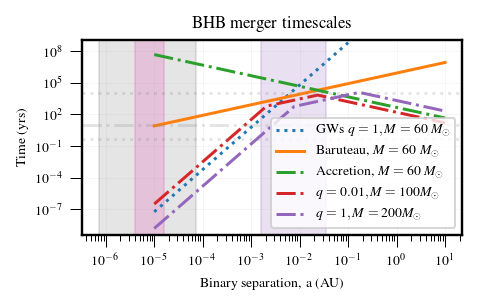

In [119]:
fig, ax1 = plt.subplots()
plt.title("BHB merger timescales")
#ax1 = fig.add_subplot(111)
#ax2 = ax1.twiny()

# Data
ax1.loglog(xaxis_t, t_gws60, label = "GWs $q=1, M=60~M_\odot$", linestyle = ":")
ax1.loglog(xaxis_t, t_bteau60, label = "Baruteau, $M=60~M_\odot$")
ax1.loglog(xaxis_t, t_acc60, label = "Accretion, $M=60~M_\odot$", linestyle="-.")

# Data
#ax1.loglog(xaxis_t, t_gws100, label = "GWs $q=1, M=60~M_\odot$", linestyle = ":")
#ax1.loglog(xaxis_t, t_bteau100, label = "Baruteau, $M=60~M_\odot$")
#ax1.loglog(xaxis_t, t_acc100, label = "Accretion, $M=60~M_\odot$", linestyle="-.")
ax1.loglog(xaxis_t, t_all100, label = "$q=0.01, M=100M_\odot$", linestyle="-.")
ax1.loglog(xaxis_t, t_all200, label = "$q=1, M=200M_\odot$", linestyle="-.")





# GW Detectors
ax1.axvspan(lisa_min, lisa_max, alpha=0.2,  color = 'C4' ) #LISA band
ax1.axvspan(et_min, et_max, alpha=0.2,  color = 'C7') #ET band
ax1.axvspan(ligo_min, ligo_max, alpha=0.3,  color = 'C6') #LIGO band

# Fine tuning
ax1.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
ax1.minorticks_on()
# Customize the major grid
#ax1.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
#ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

ax1.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(10))
#ax1.set_yscale('log')
ax1.grid(True, alpha=0.1, linewidth=0.5)
ax1.axhline(y=.5, alpha=0.2, linestyle = ":", color = 'grey')
ax1.axhline(y=10, alpha=0.2, linestyle = "-.", color = 'grey')
ax1.axhline(y=1e4, alpha=0.2, linestyle = ":", color = 'grey')


ax1.set_ylim((0.013157894736842105 / 31556926),1e9) # ymin is 1/f_isco
ax1.set_ylabel("Time (yrs)")
ax1.set_xlabel("Binary separation, a (AU)")
plt.legend(loc=4)
plt.tight_layout()
#plt.savefig("BHB_in_AGN_disk-25oct19-vary_qx2.pdf")

# Add LIGO and LISA Frequency bands!

## What are the limitations of this scaling law? When $c_S = da/dt$ from Baruteau et al. 2011

In [266]:
# What is da/dt from Baruteau? Divide a list define by Baruteau by time list..

tmpLst = []
for ii in range(1,100):
    tmpLst.append(31556926*t_acc[ii]/(xaxis_t[ii]*499))

In [267]:
(c*50*499/900/pi/1e7)

264.5445816065816

In [278]:
riseA = (t_acc[-1] - t_acc[0])*31556926
riseB = (t_bteau[-1] - t_bteau[0])*31556926

In [279]:
run = (xaxis_t[-1]-xaxis_t[0])*499

In [280]:
slopeA = run/riseA
slopeB = run/riseB

In [281]:
"%2e"%(riseB)

'3.689428e+09'

In [282]:
"%2e"%run

'4.990000e+04'

In [283]:
slopeB*c ### GOOD!! 4km/s, less than disk sound speed.

4054.732022416672

# Plotting preamble

In [45]:
fig_width_pt = 245.27 #513.17           # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

params = {'backend': 'pdf',
        'axes.labelsize': 7,
        'lines.markersize': 4,
        'font.size': 7,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        #'axes.color_cycle': ['b', 'lime', 'r', 'purple', 'g', 'c', 'm', 'orange', 'darkblue', \
        #                        'darkcyan', 'y','orangered','chartreuse','brown','deeppink','lightgreen', 'k'],
        #'font.serif':cm,
        'figure.figsize': fig_size}
plt.rcParams.update(params)